In [1]:
import sys
sys.path.append('..')
import os, glob, cv2, time
import numpy as np
import tensorflow as tf

from utils import *
from scipy import io as mat
from matplotlib import pyplot as plt

tf.set_random_seed(777)

In [2]:
tmp = np.load('../data/input/data_2d.npz')
img = tmp['img']
img = np.reshape(img, (img.shape[0], img.shape[1], img.shape[2], 1))
lab = np.ceil(tmp['lab'])
lab = np.reshape(lab, (lab.shape[0], lab.shape[1], lab.shape[2], 1))

In [3]:
tum_in_img = []
tum_in_lab = []

tum_no_img = []
tum_no_lab = []
count = 0
for idx, i in enumerate(lab):
    sum_ = np.sum(i)
    if sum_ != 0:
        tum_in_img.append(img[idx])
        tum_in_lab.append(i)
    else : 
        tum_no_img.append(img[idx])
        tum_no_lab.append(i)
        
tum_in_img = np.array(tum_in_img)
tum_in_lab = np.array(tum_in_lab)
tum_no_img = np.array(tum_no_img)
tum_no_lab = np.array(tum_no_lab)

In [4]:
print(tum_in_img.shape)
print(tum_in_lab.shape)
print(tum_no_img.shape)
print(tum_no_lab.shape)

del img, lab, tmp

(633, 256, 256, 1)
(633, 256, 256, 1)
(2955, 256, 256, 1)
(2955, 256, 256, 1)


In [5]:
X = tf.placeholder(tf.float32, shape=[None, 256, 256, 1])
Y = tf.placeholder(tf.float32, shape=[None, 256, 256, 1])

weight = {
    'we1_1':init_w('we1_1', [3, 3, 1, 64]),
    'we1_2':init_w('we1_2', [3, 3, 64, 64]),
    'we2_1':init_w('we2_1', [3, 3, 64, 128]),
    'we2_2':init_w('we2_2', [3, 3, 128, 128]),
    'we3_1':init_w('we3_1', [3, 3, 128, 256]),
    'we3_2':init_w('we3_2', [3, 3, 256, 256]),
    'we4_1':init_w('we4_1', [3, 3, 256, 512]),
    'we4_2':init_w('we4_2', [3, 3, 512, 512]),
    'we5_1':init_w('we5_1', [3, 3, 512, 1024]),
    'we5_2':init_w('we5_2', [3, 3, 1024, 1024]),
    
    'wd4_3':init_w('wd4_3', [4, 4, 1024, 1024]),
    'wd4_2':init_w('wd4_2', [3, 3, 1536, 512]),
    'wd4_1':init_w('wd4_1', [3, 3, 512, 512]),
    'wd3_3':init_w('wd3_3', [4, 4, 512, 512]),
    'wd3_2':init_w('wd3_2', [3, 3, 768, 256]),
    'wd3_1':init_w('wd3_1', [3, 3, 256, 256]),
    'wd2_3':init_w('wd2_3', [4, 4, 256, 256]),
    'wd2_2':init_w('wd2_2', [3, 3, 384, 128]),
    'wd2_1':init_w('wd2_1', [3, 3, 128, 128]),
    'wd1_3':init_w('wd1_3', [4, 4, 128, 128]),
    'wd1_2':init_w('wd1_2', [3, 3, 192, 64]),
    'wd1_1':init_w('wd1_1', [3, 3, 64, 64]),
    
    'wout':init_w('wout', [1,1,64,1])
}

In [6]:
def model(X, w):
    
    en1 = tf.nn.relu(conv2d(X, w['we1_1']))
    en1 = tf.nn.relu(conv2d(en1, w['we1_2']))
    
    en2 = max_pool_2d(en1)
    en2 = tf.nn.relu(conv2d(en2, w['we2_1']))
    en2 = tf.nn.relu(conv2d(en2, w['we2_2']))
    
    en3 = max_pool_2d(en2)
    en3 = tf.nn.relu(conv2d(en3, w['we3_1']))
    en3 = tf.nn.relu(conv2d(en3, w['we3_2']))
    
    en4 = max_pool_2d(en3)
    en4 = tf.nn.relu(conv2d(en4, w['we4_1']))
    en4 = tf.nn.relu(conv2d(en4, w['we4_2']))
    
    en5 = max_pool_2d(en4)
    en5 = tf.nn.relu(conv2d(en5, w['we5_1']))
    en5 = tf.nn.relu(conv2d(en5, w['we5_2']))
    
    de4 = deconv2d(en5, w['wd4_3'], (tf.shape(X)[0],32,32,1024),
                   strides=[1,2,2,1])
    de4 = tf.concat((en4, de4), axis = 3)
    de4 = tf.nn.relu(conv2d(de4, w['wd4_2']))
    de4 = tf.nn.relu(conv2d(de4, w['wd4_1']))

    de3 = deconv2d(de4, w['wd3_3'], (tf.shape(X)[0],64,64,512),
                   strides=[1,2,2,1])
    de3 = tf.concat((en3, de3), axis = 3)
    de3 = tf.nn.relu(conv2d(de3, w['wd3_2']))
    de3 = tf.nn.relu(conv2d(de3, w['wd3_1']))
    
    de2 = deconv2d(de3, w['wd2_3'], (tf.shape(X)[0],128,128,256),
                   strides=[1,2,2,1])
    de2 = tf.concat((en2, de2), axis = 3)
    de2 = tf.nn.relu(conv2d(de2, w['wd2_2']))
    de2 = tf.nn.relu(conv2d(de2, w['wd2_1']))
    
    de1 = deconv2d(de2, w['wd1_3'], (tf.shape(X)[0],256,256,128),
                   strides=[1,2,2,1])
    de1 = tf.concat((en1, de1), axis = 3)
    de1 = tf.nn.relu(conv2d(de1, w['wd1_2']))
    de1 = tf.nn.relu(conv2d(de1, w['wd1_1']))
    
    out = conv2d(de1, w['wout'])
    
    output = {
        
        'out':out,
        'en1':en1,
        'en2':en2,
        'en3':en3,
        'en4':en4,
        'en5':en5,
        'de4':de4,
        'de3':de3,
        'de2':de2,
        'de1':de1,
    }
    
    return output

def dice_coefficient(label, infer):
    
    label_flatten = tf.layers.flatten(label)
    infer_flatten = tf.layers.flatten(infer)
    TP = tf.reduce_sum(label_flatten*infer_flatten) + 1e-7
    FN = tf.reduce_sum(label_flatten*(1-infer_flatten)) + 1e-7
    FP = tf.reduce_sum((1-label_flatten)*infer_flatten) + 1e-7
    
    bottom = FN+FP+(2*TP) + 1e-7
    up = 2*TP + 1e-7
    return up/bottom + 1e-7

def make_batch(batch_size):
    thr = np.uint8(batch_size/2)
    tum_seq = np.random.choice(len(tum_in_img), thr, replace=False)
    no_seq = np.random.choice(len(tum_no_img), batch_size-thr, replace=False)
    
    batch_x = tum_in_img[tum_seq]
    batch_y = tum_in_lab[tum_seq]
    
    batch_x = np.concatenate((batch_x, tum_no_img[no_seq]), axis = 0)
    batch_y = np.concatenate((batch_y, tum_no_lab[no_seq]), axis = 0)
    
    return batch_x, batch_y

In [7]:
with tf.device('/gpu:1'):
    pred = model(X, weight)
    coeff = dice_coefficient(Y, tf.nn.sigmoid(pred['out']))
    cost = -coeff
with tf.device('/gpu:0'):
    train = tf.train.AdamOptimizer(1e-6).minimize(cost)

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


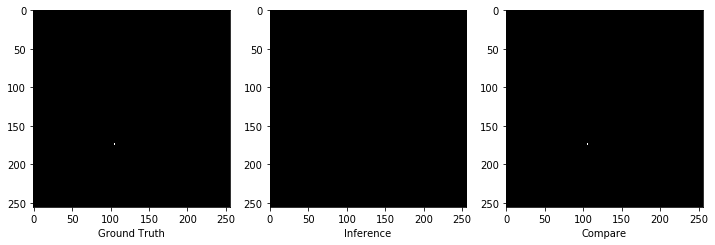

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


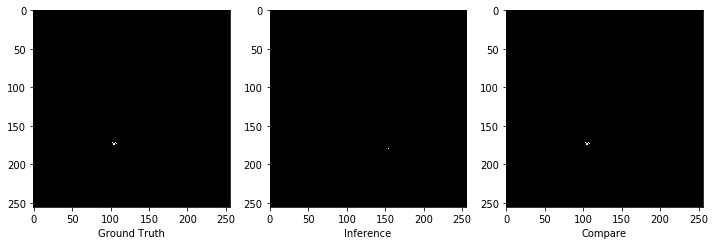

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


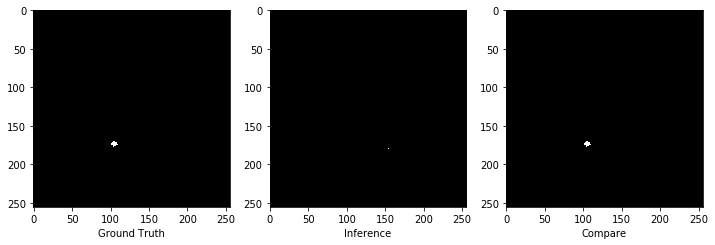

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


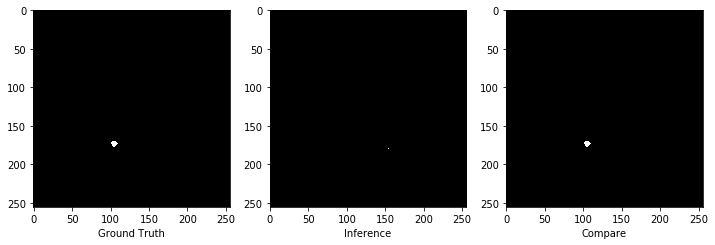

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


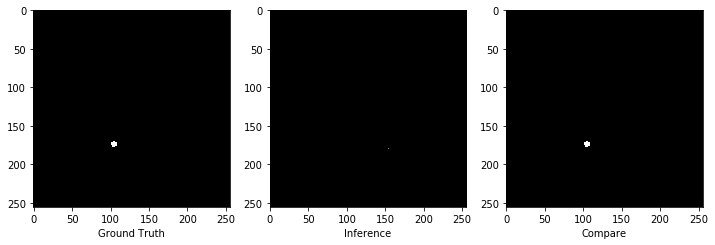

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


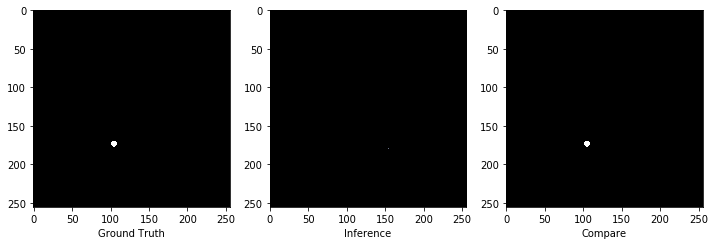

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


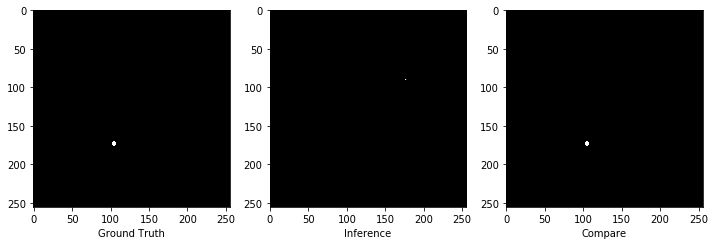

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


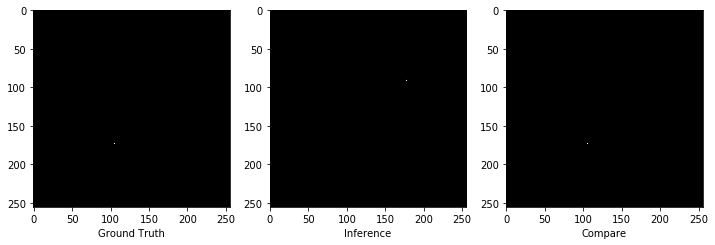

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


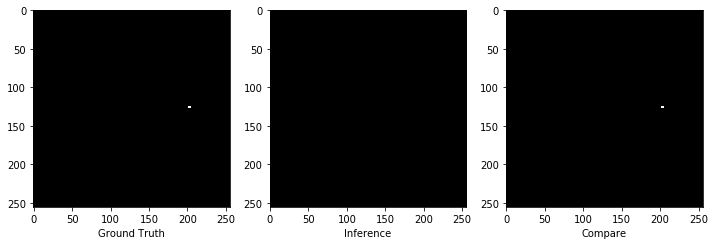

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


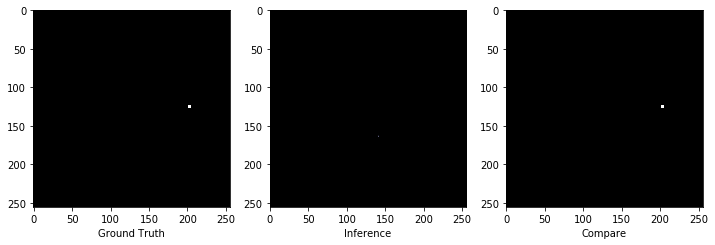

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


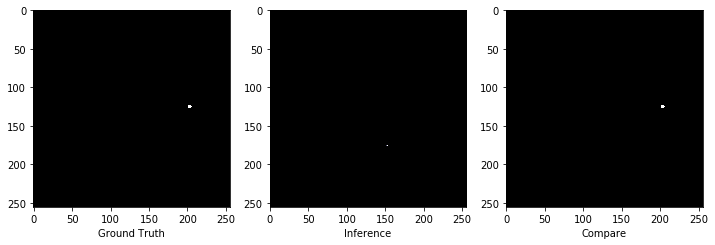

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


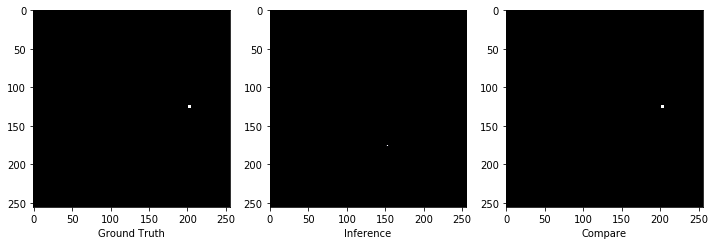

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


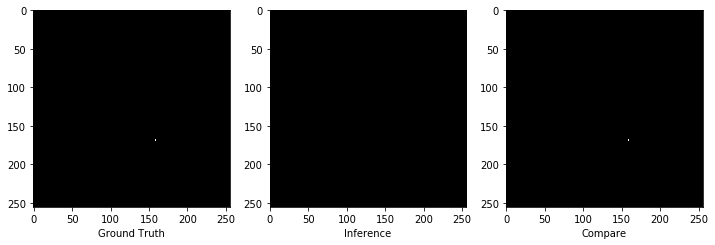

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


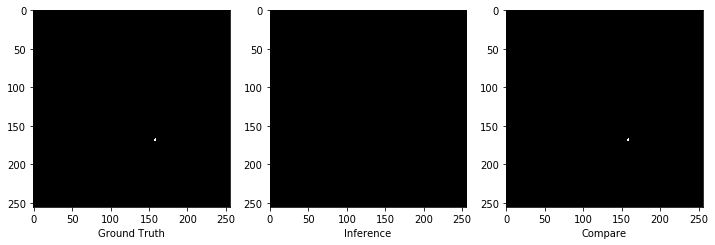

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


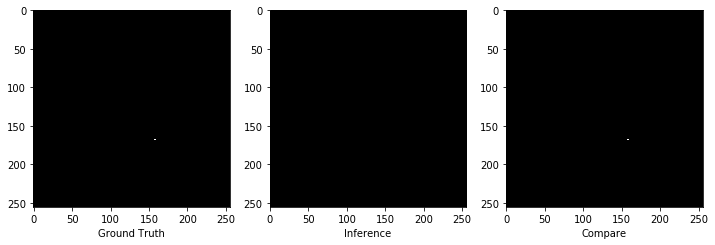

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


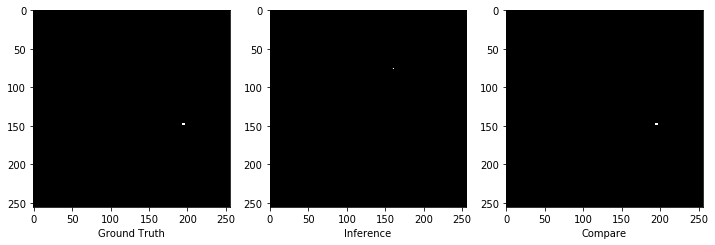

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


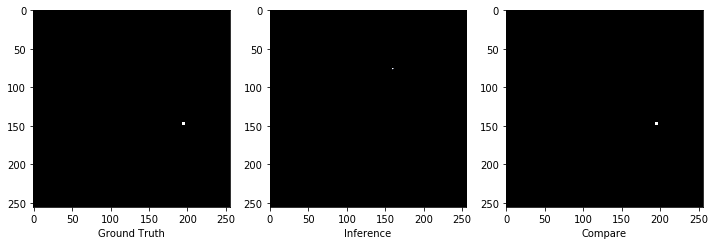

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


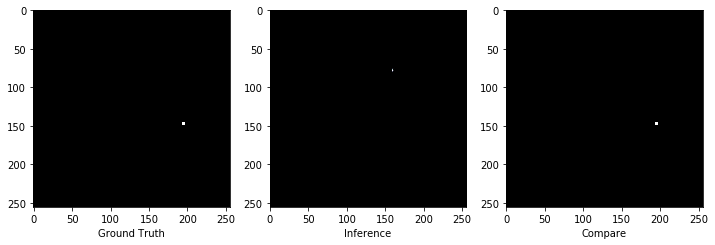

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


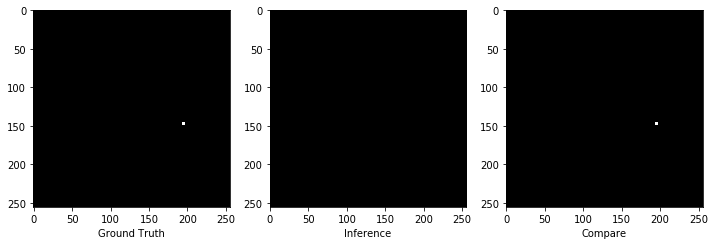

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


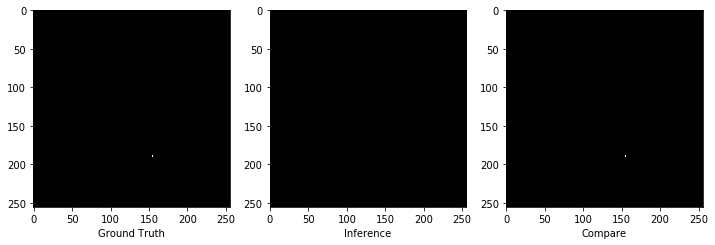

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


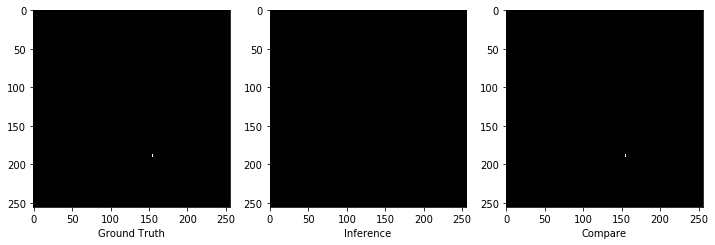

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


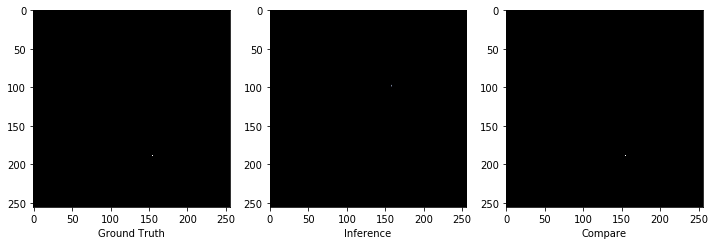

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


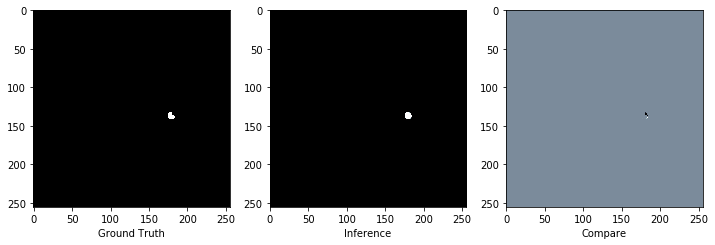

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


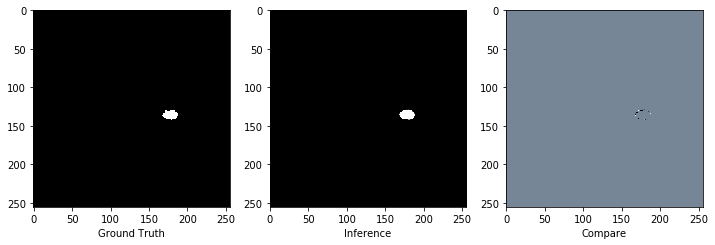

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


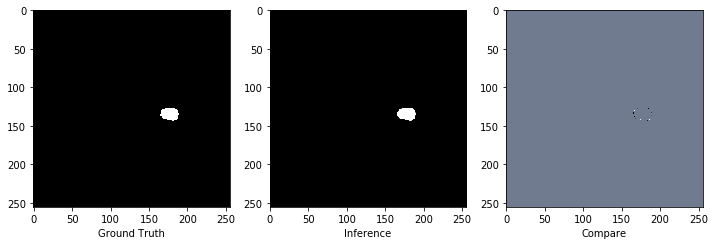

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


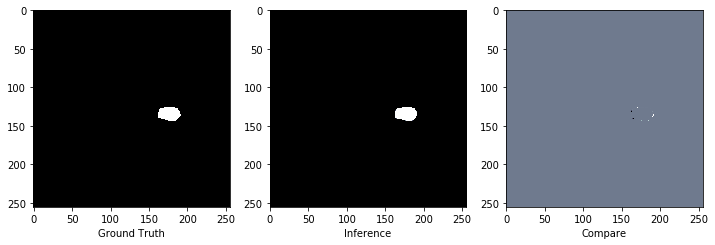

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


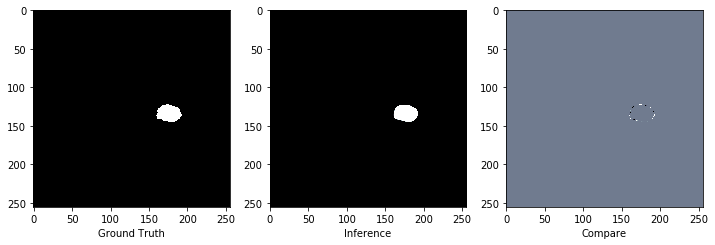

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


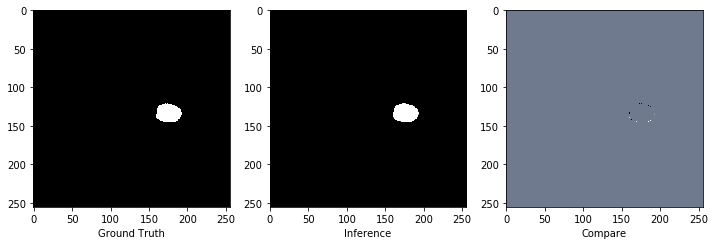

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


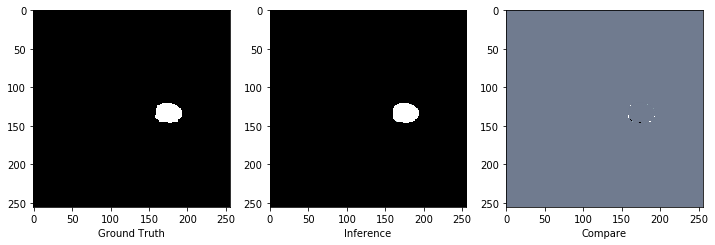

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


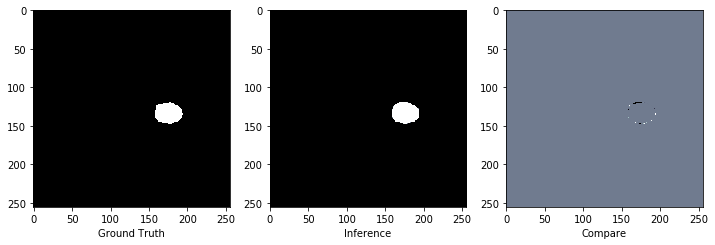

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


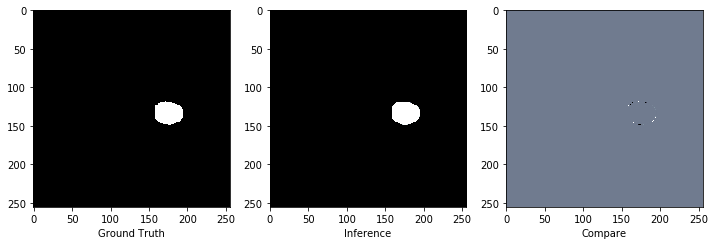

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


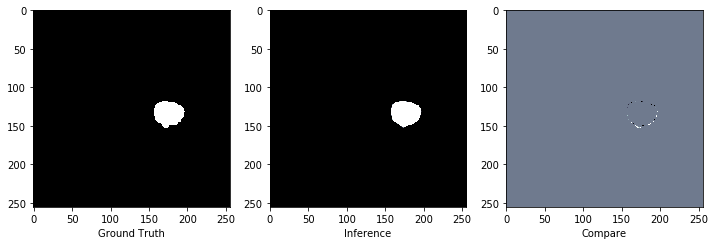

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


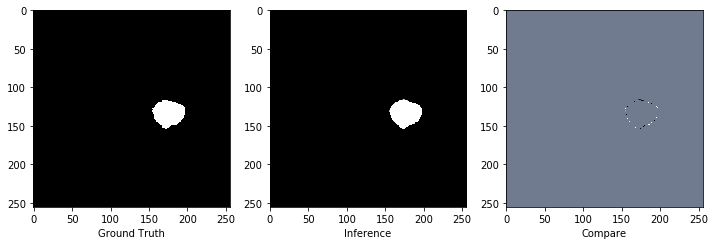

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


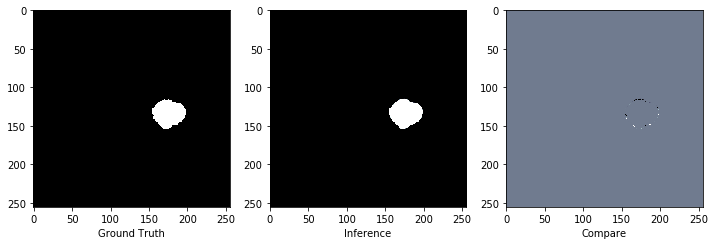

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


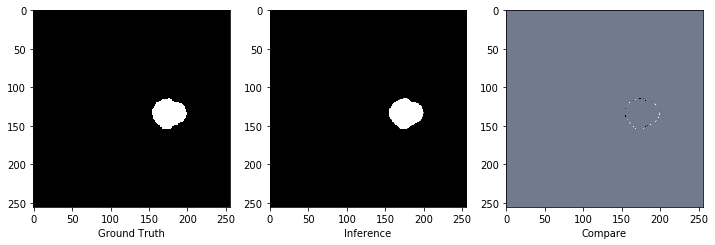

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


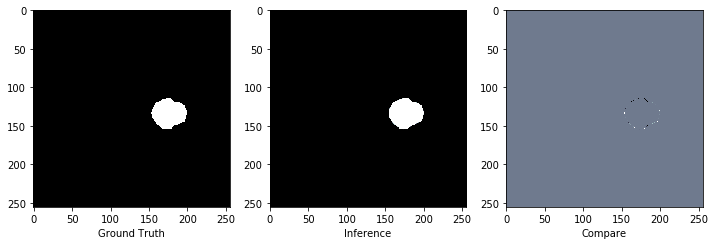

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


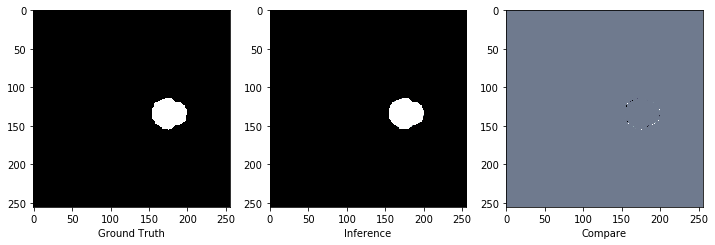

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


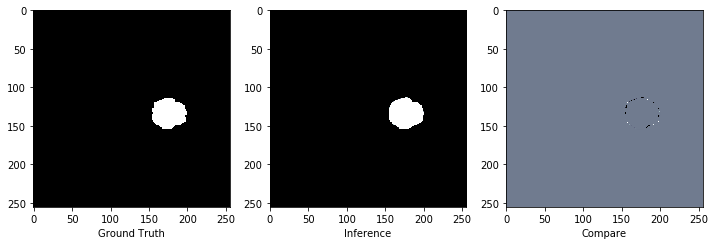

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


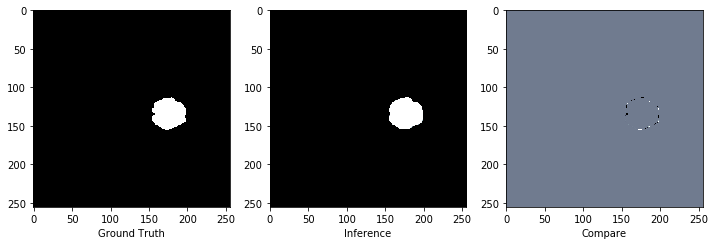

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


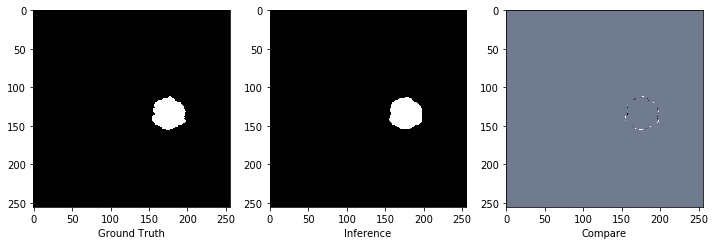

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


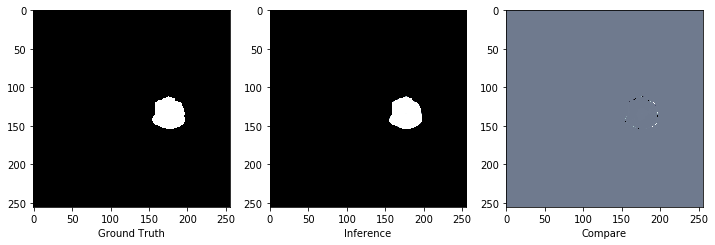

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


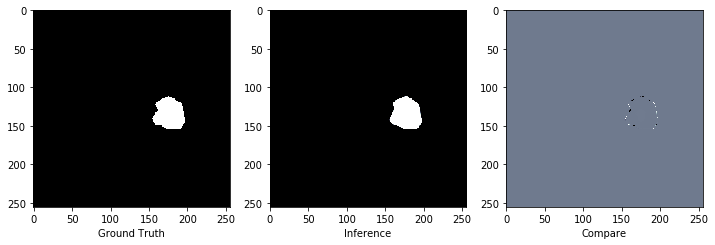

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


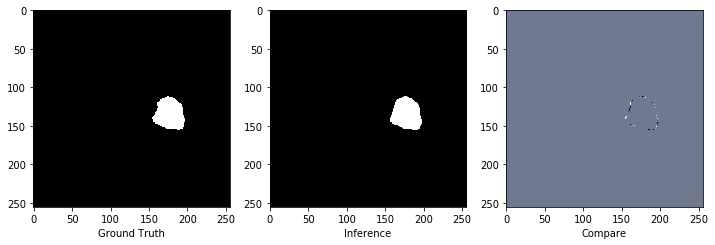

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


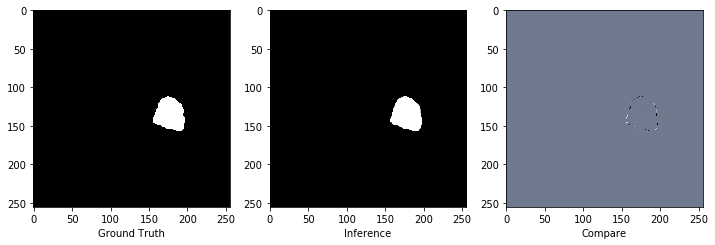

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


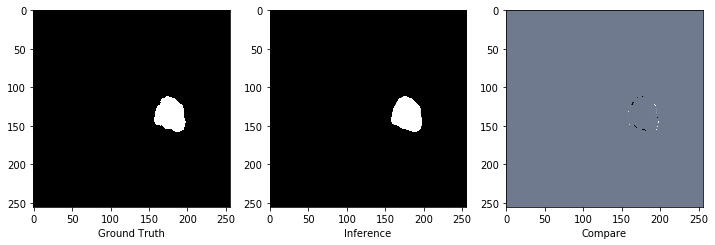

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


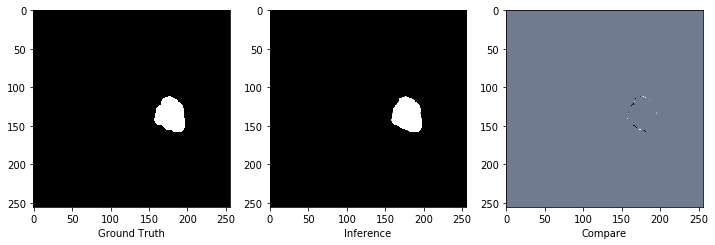

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


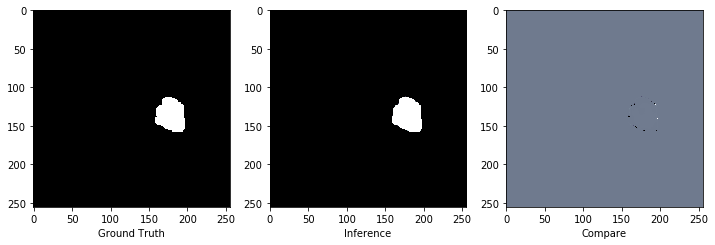

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


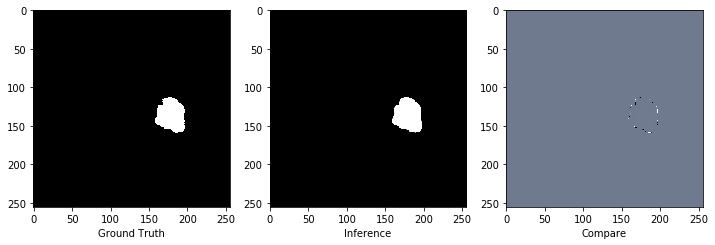

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


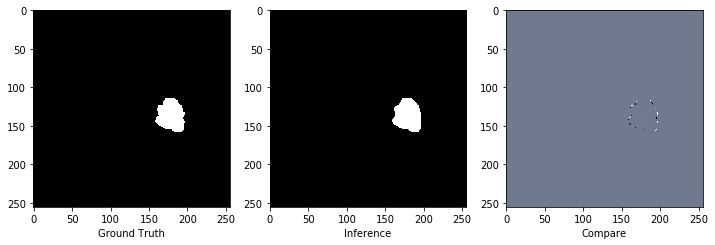

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


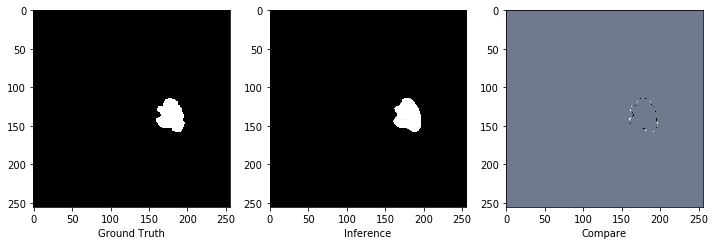

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


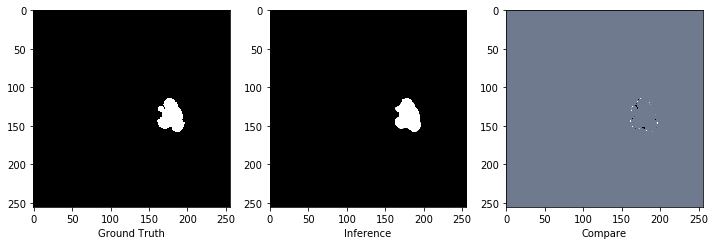

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


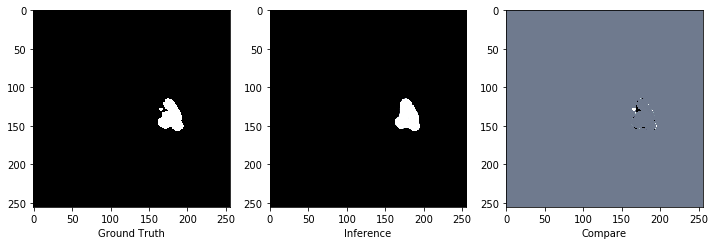

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


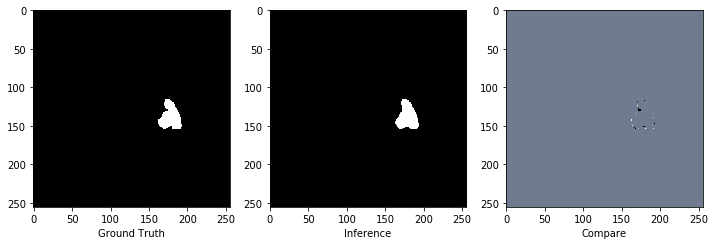

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


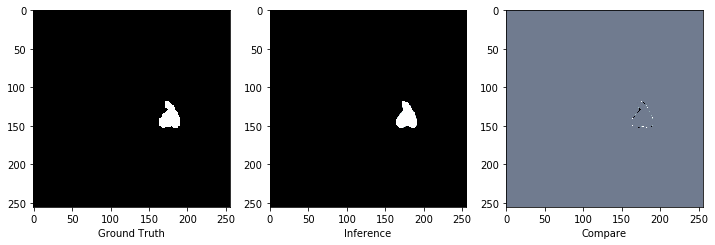

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


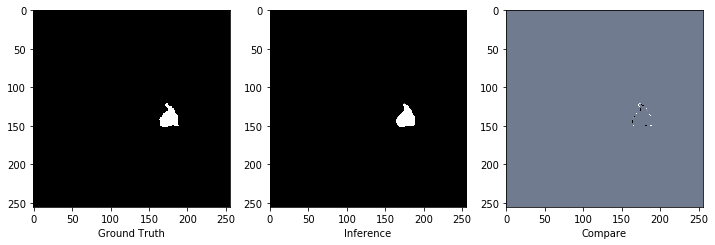

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


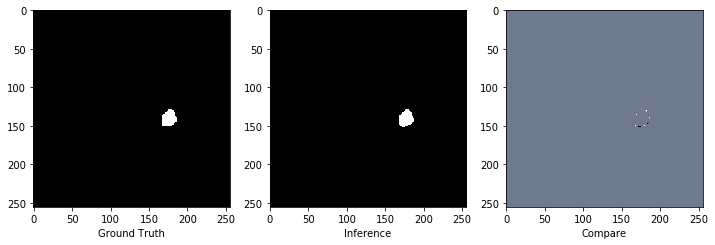

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


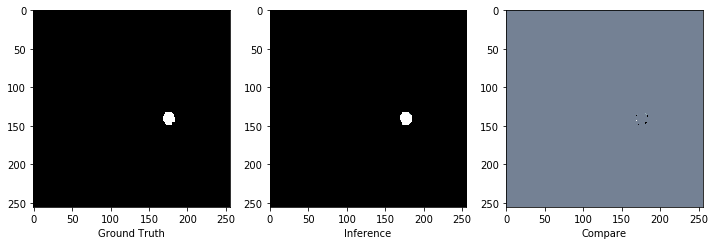

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


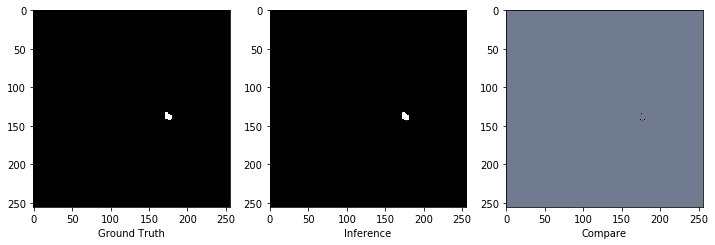

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


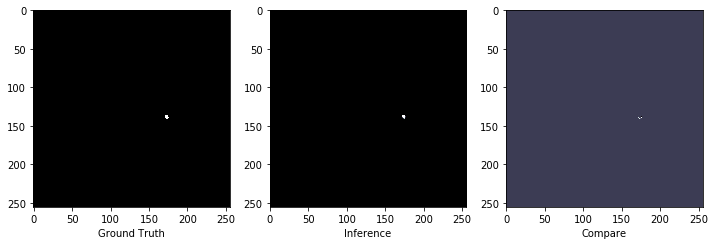

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


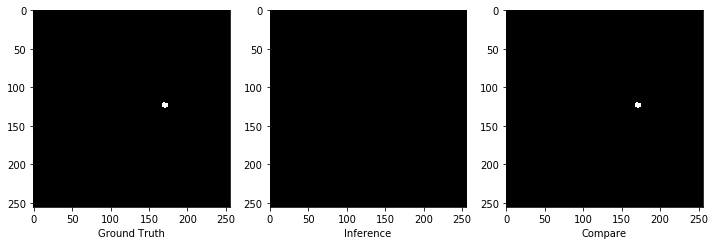

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


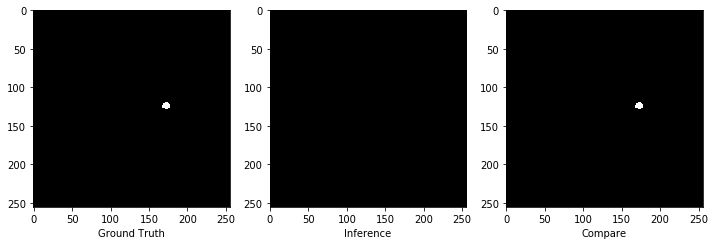

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


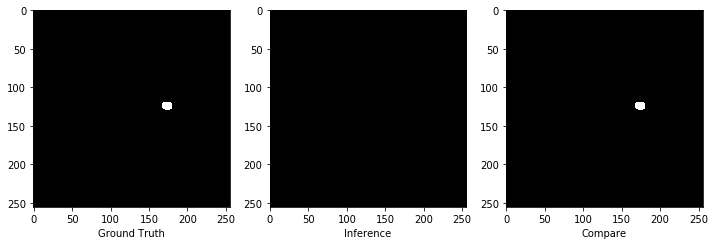

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


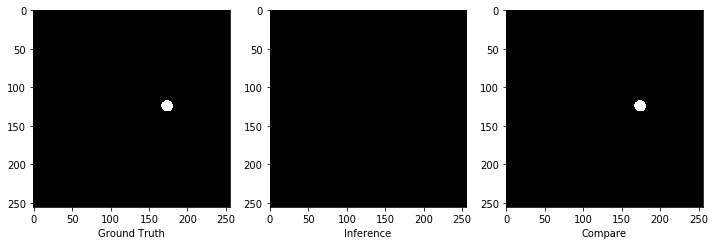

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


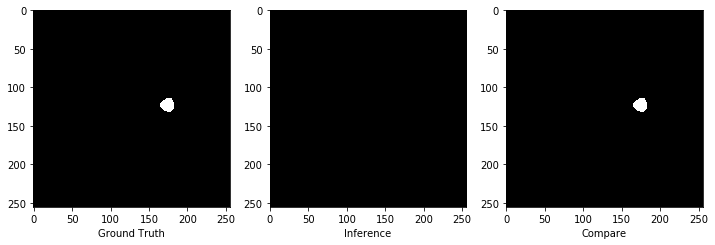

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


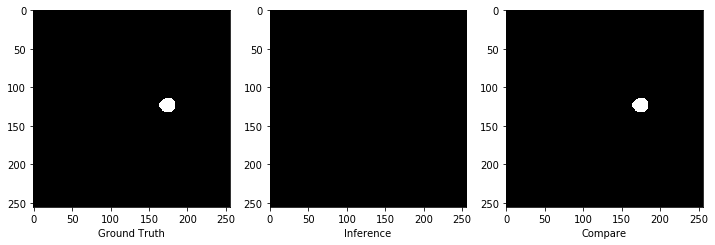

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


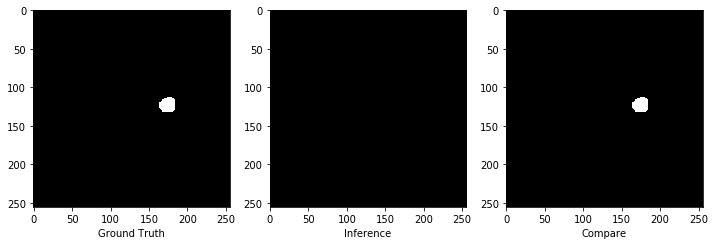

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


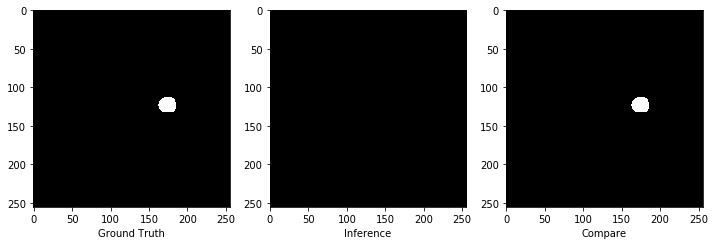

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


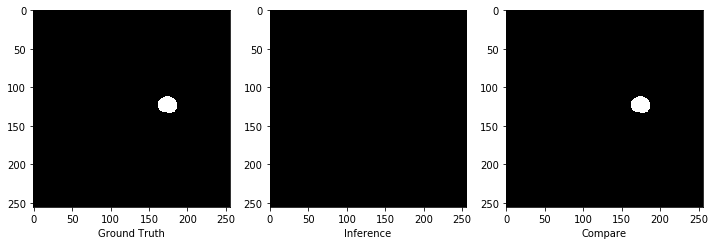

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


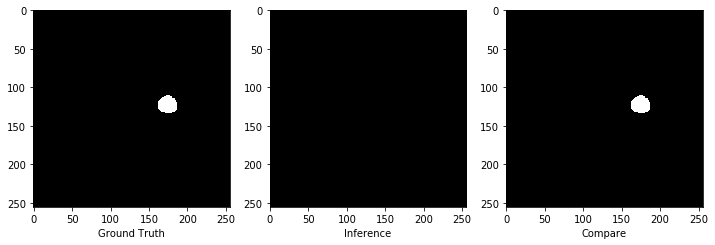

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


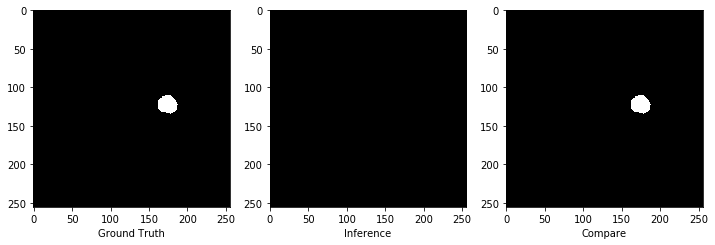

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


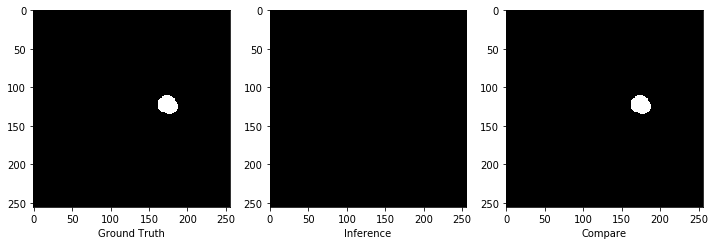

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


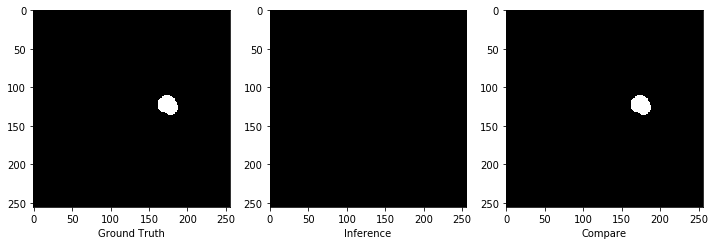

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


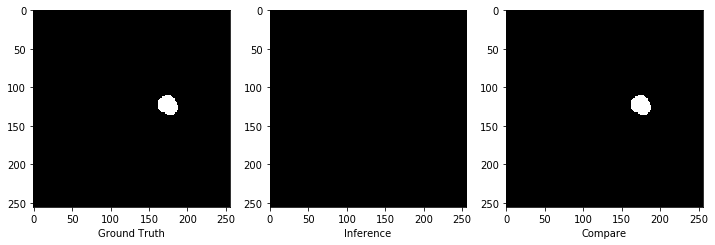

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


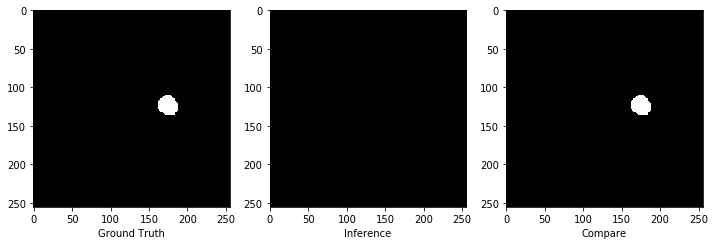

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


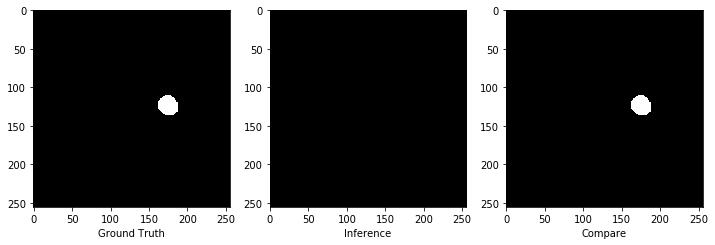

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


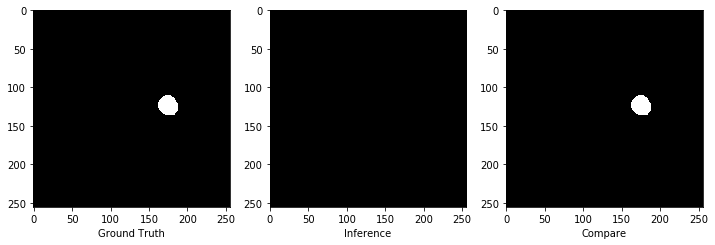

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


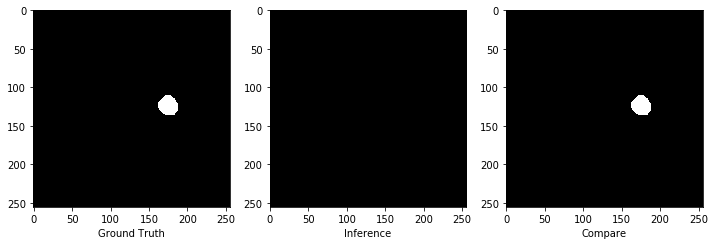

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


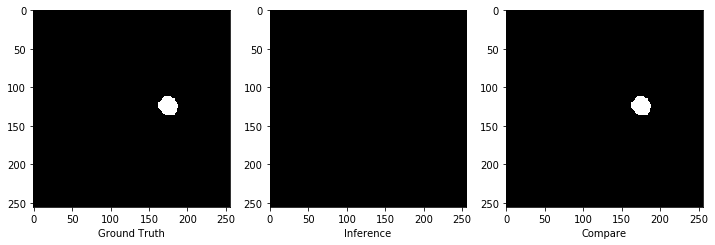

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


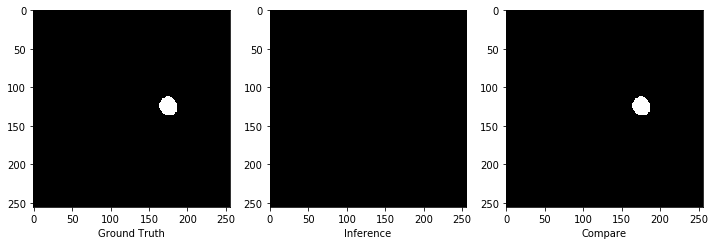

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


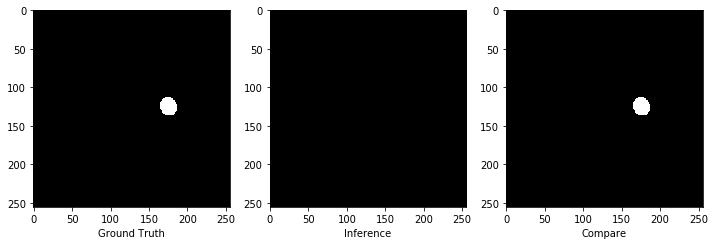

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


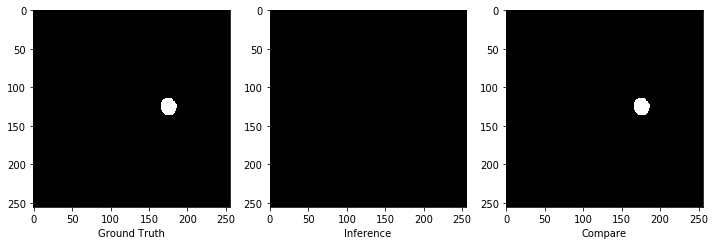

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


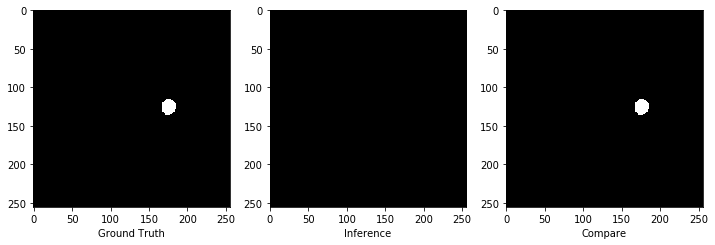

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


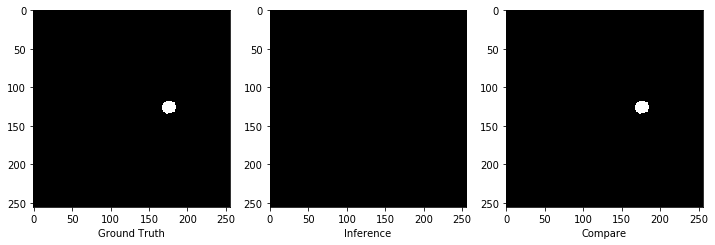

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


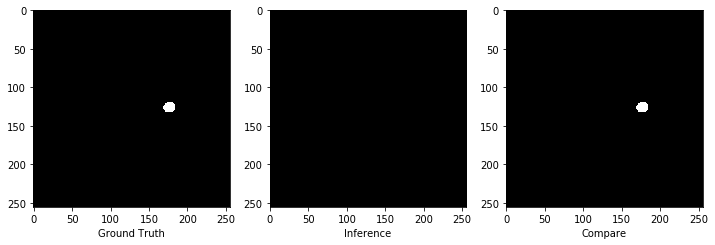

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


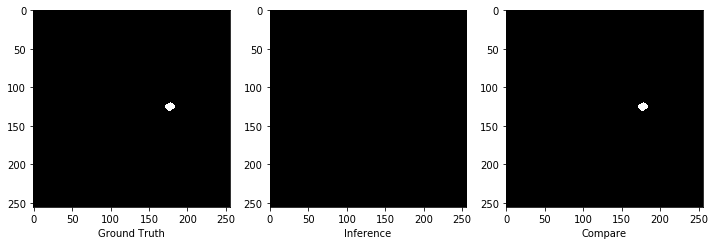

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


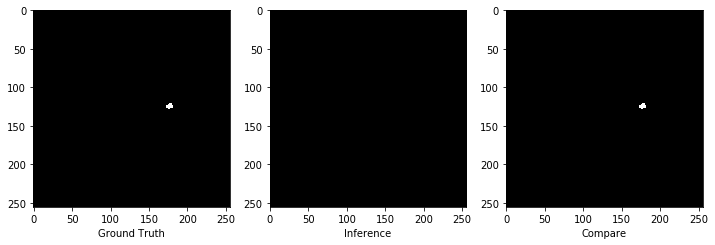

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


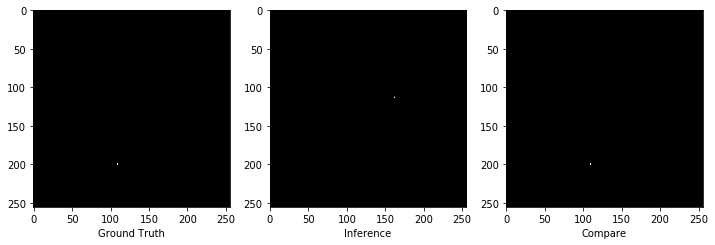

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


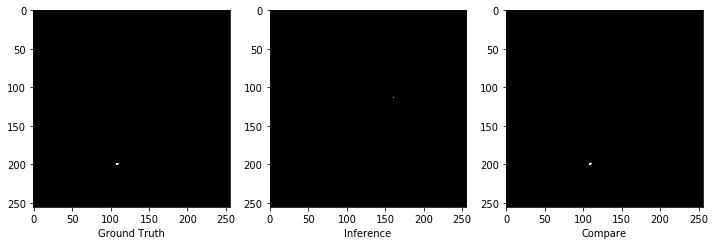

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


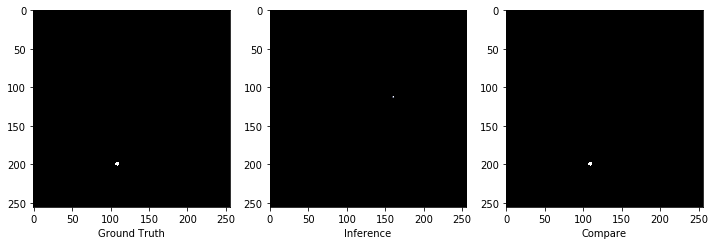

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


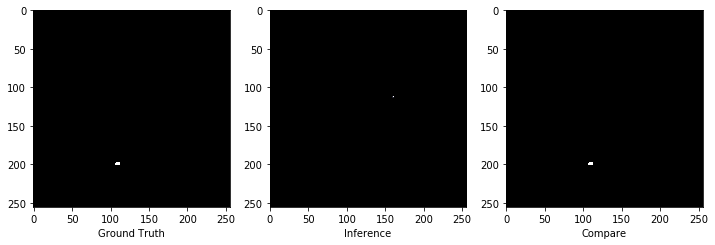

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


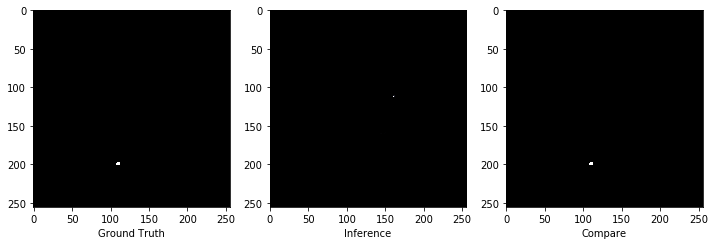

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


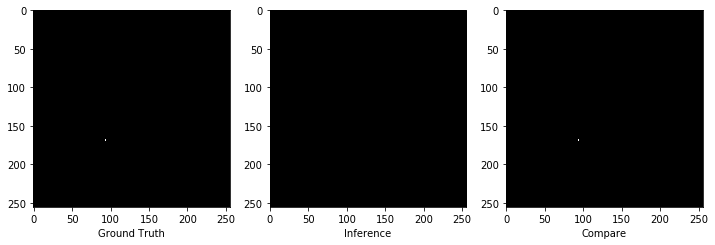

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


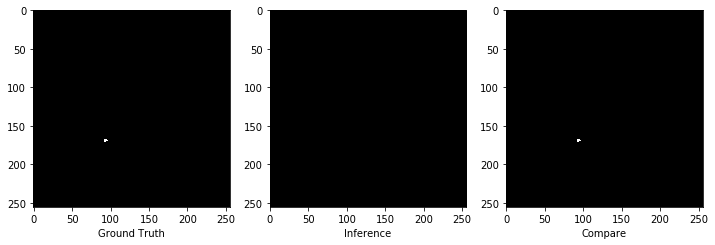

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


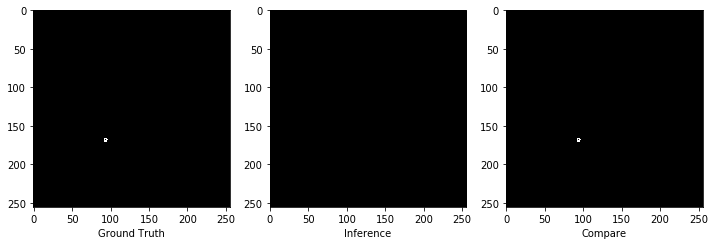

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


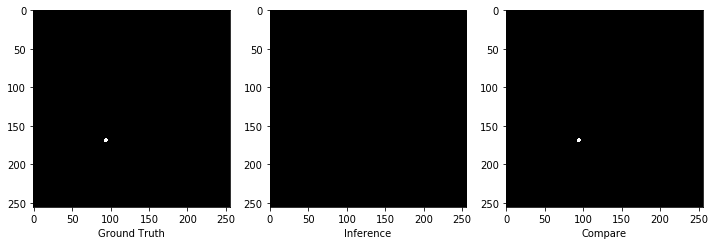

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


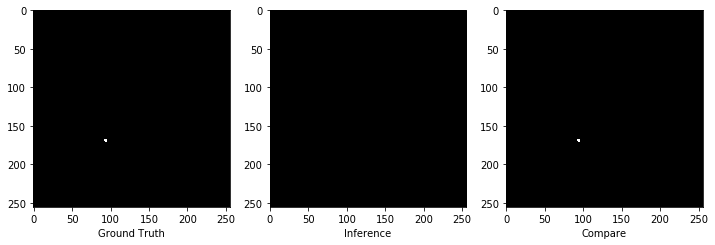

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


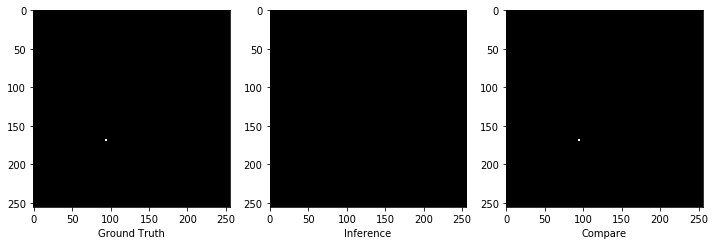

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


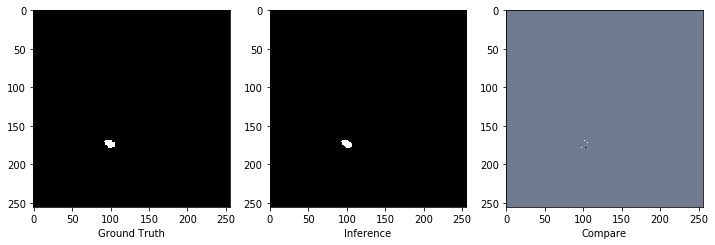

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


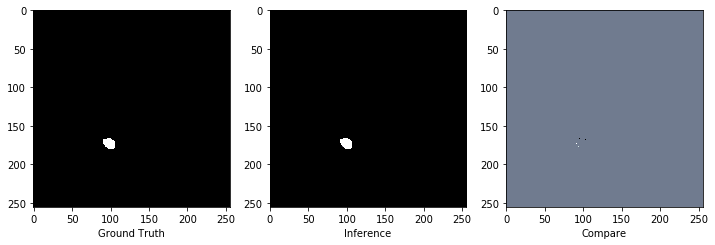

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


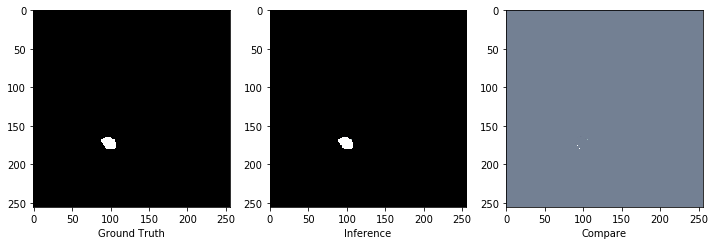

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


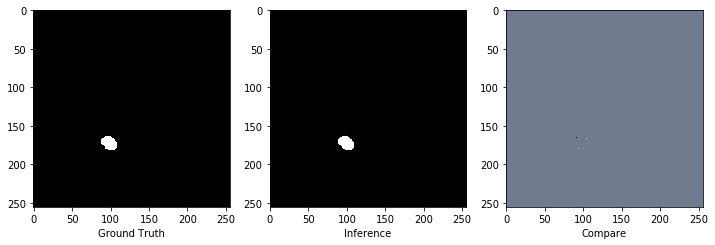

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


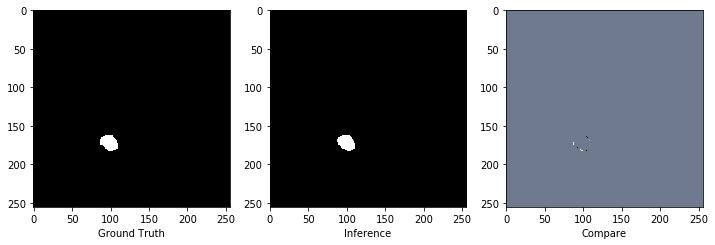

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


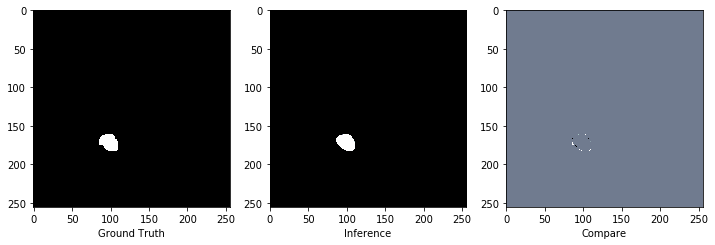

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


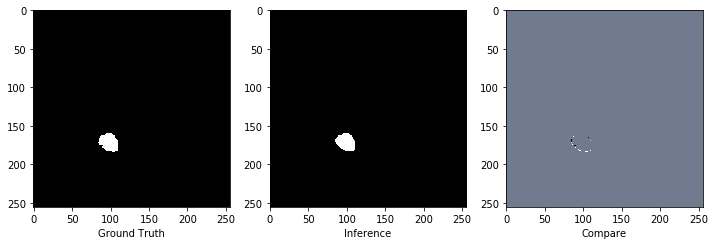

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


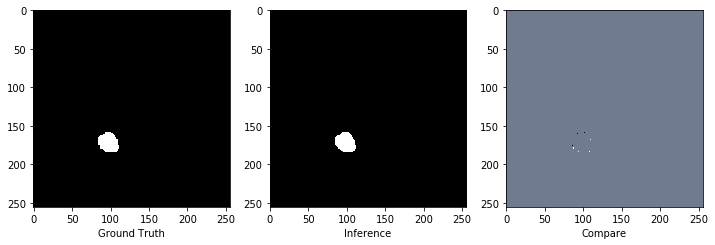

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


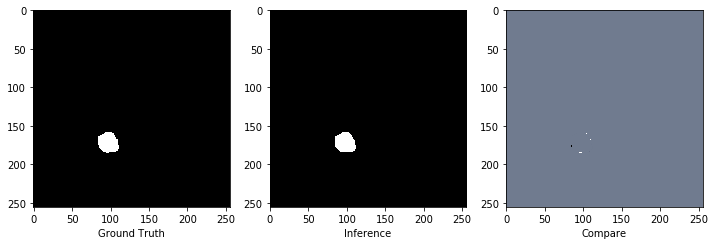

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


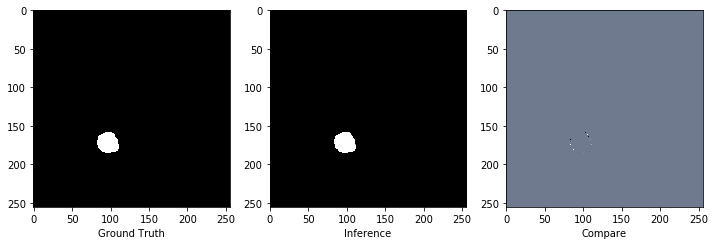

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


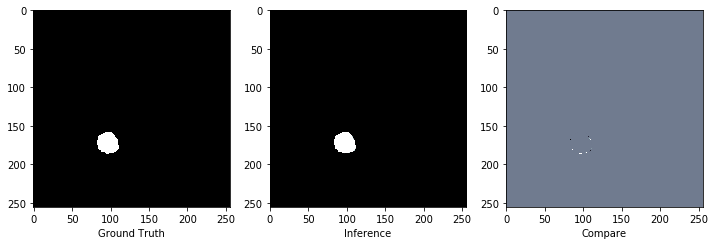

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


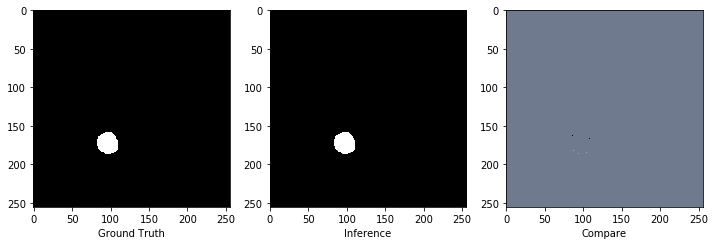

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


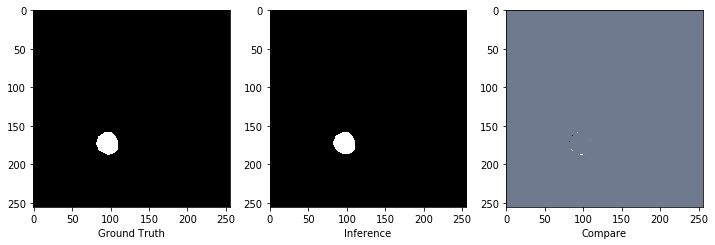

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


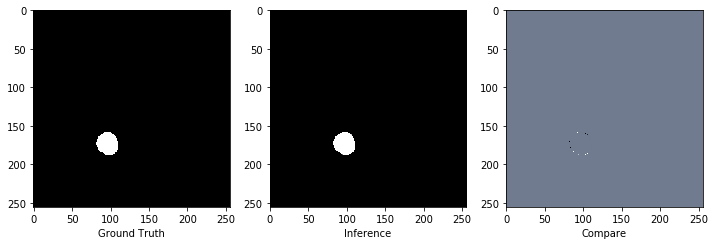

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


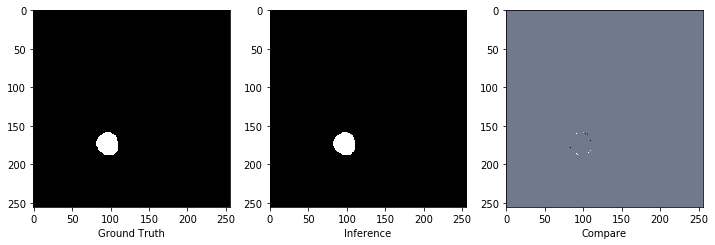

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


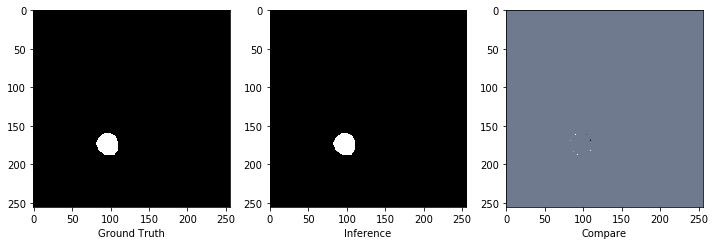

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


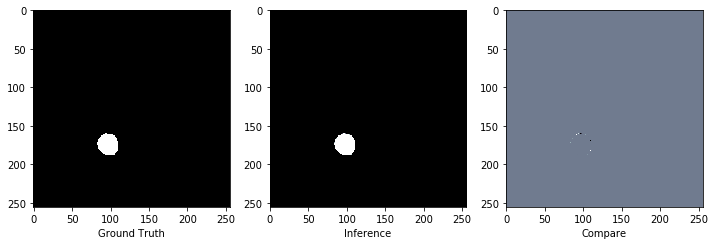

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


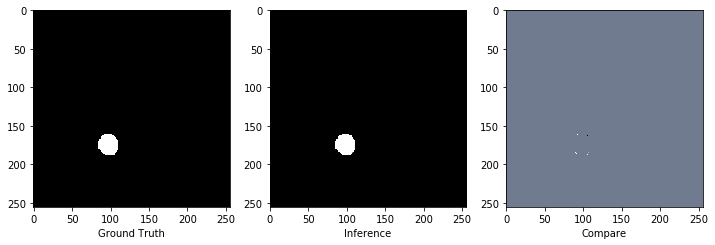

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


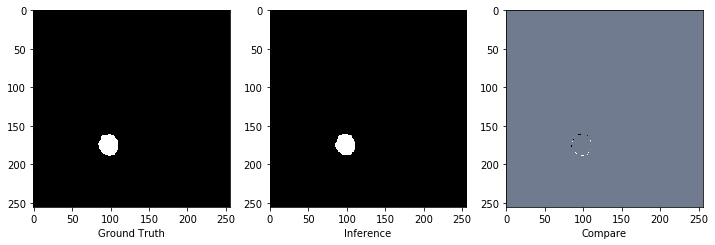

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


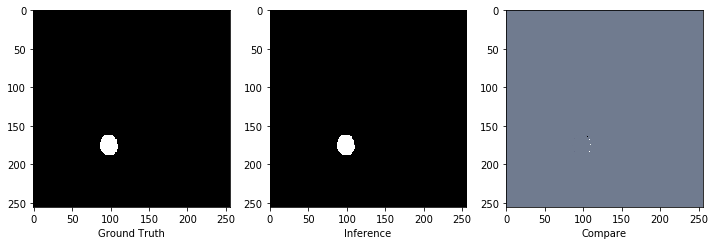

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


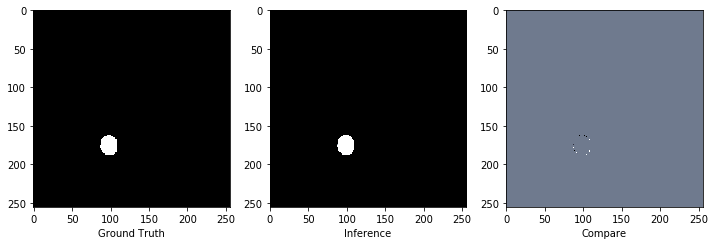

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


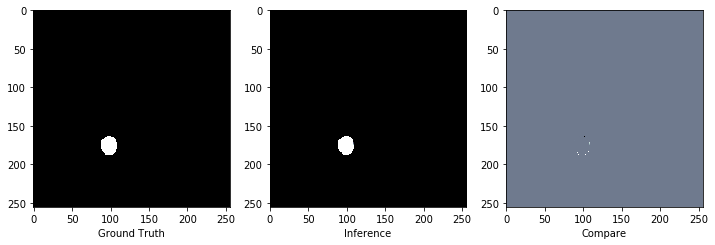

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


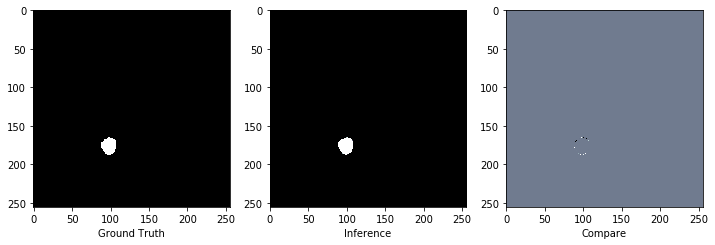

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


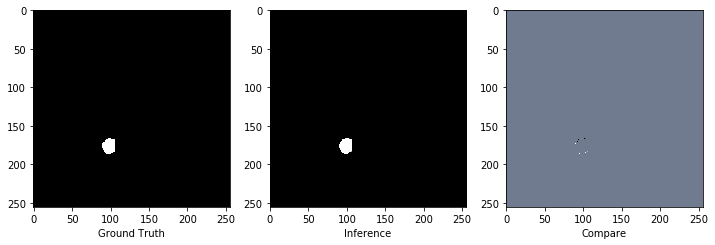

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


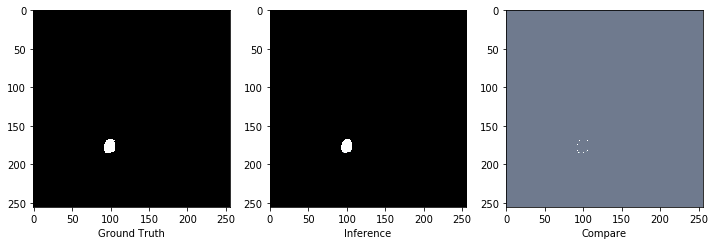

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


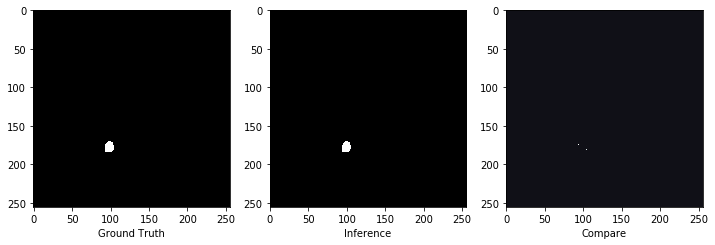

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


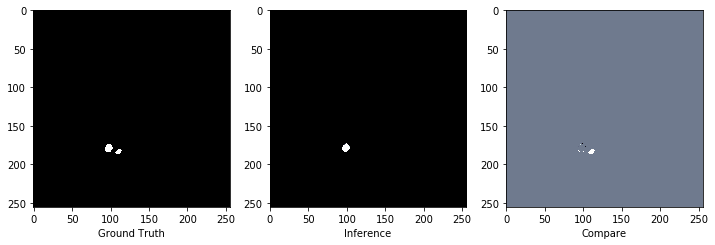

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


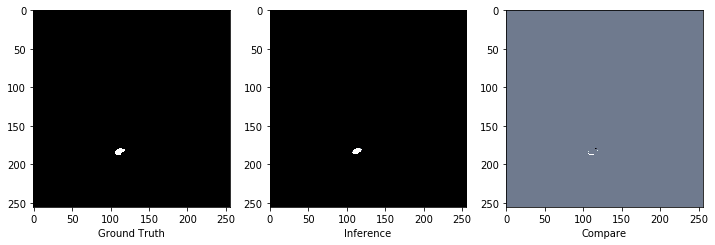

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


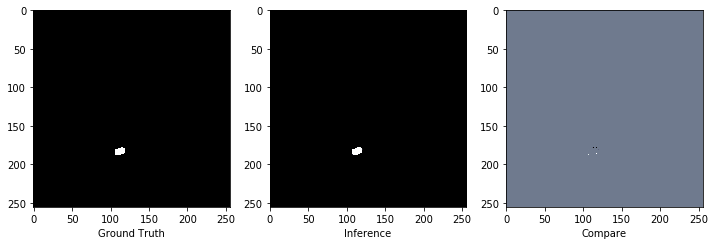

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


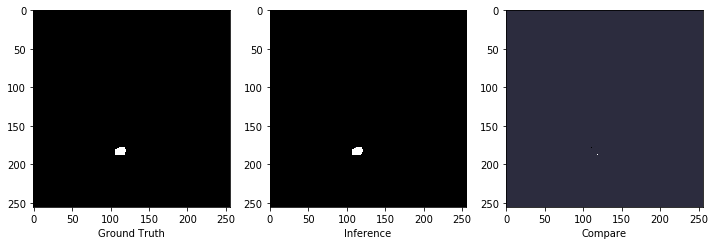

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


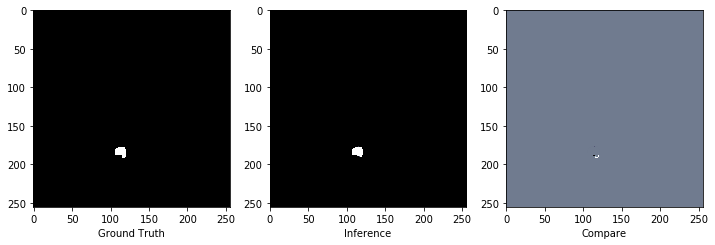

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


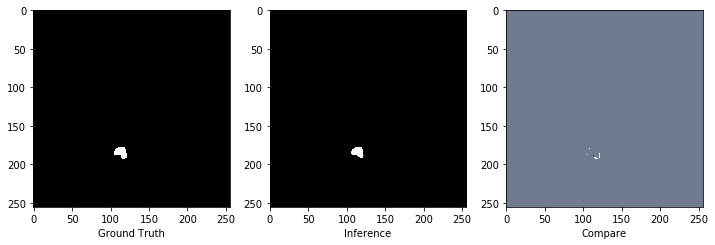

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


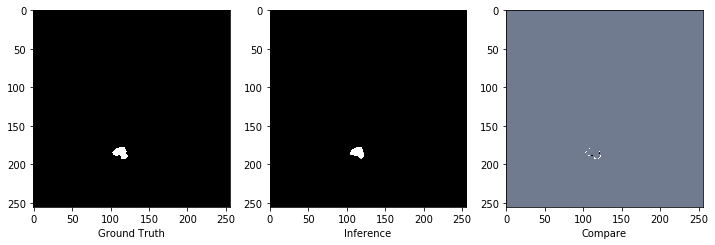

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


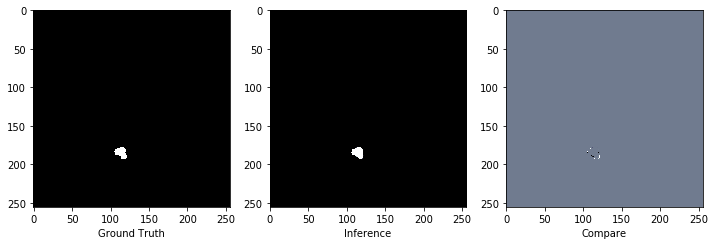

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


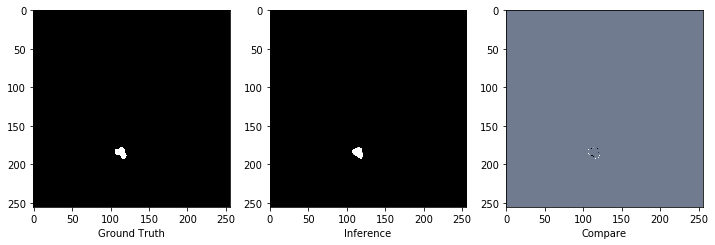

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


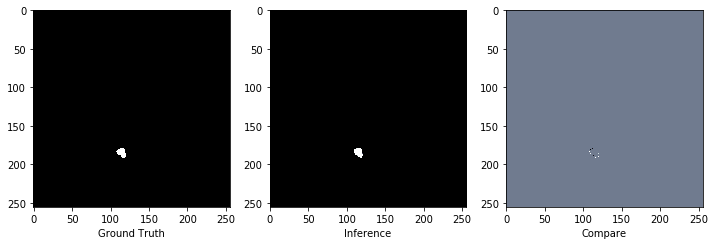

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


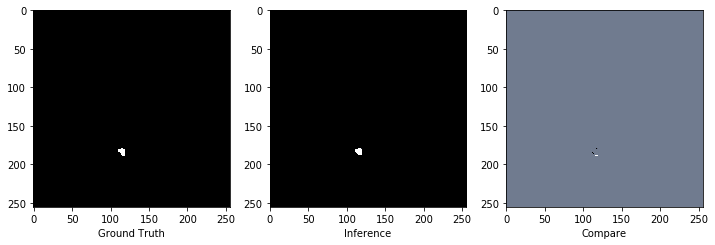

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


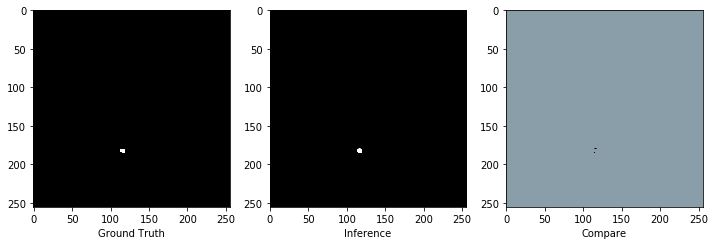

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


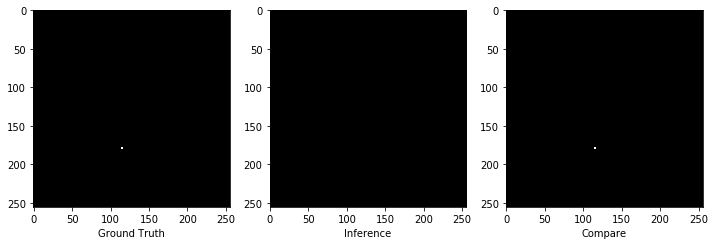

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


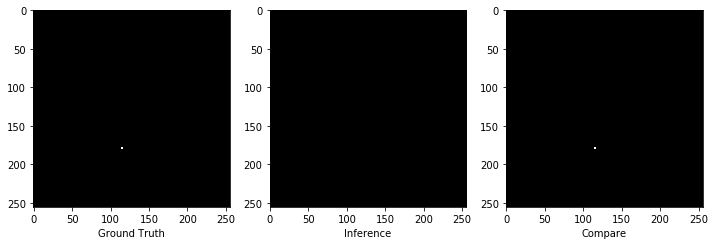

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


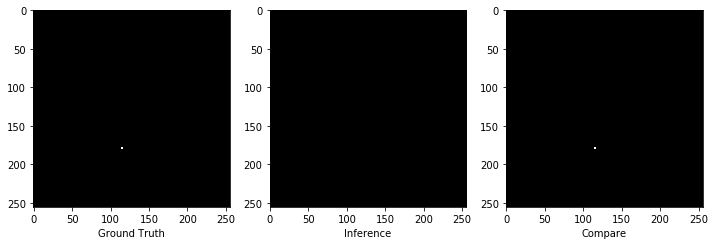

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


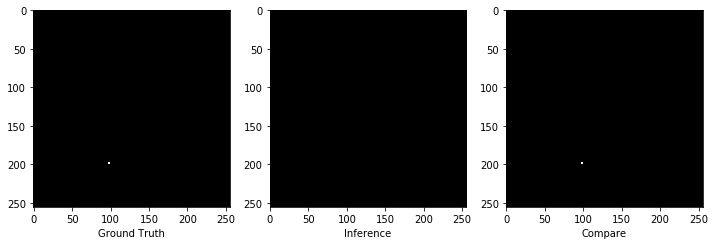

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


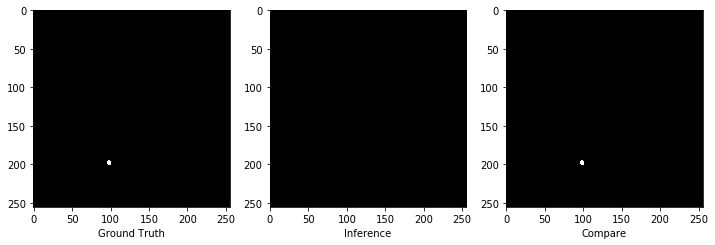

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


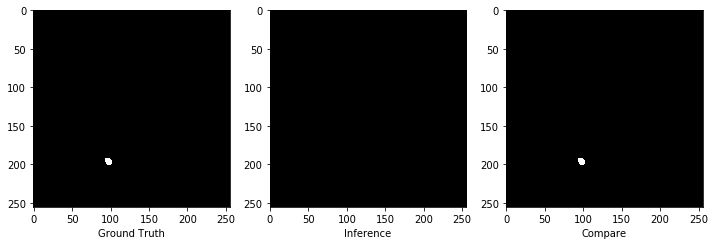

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


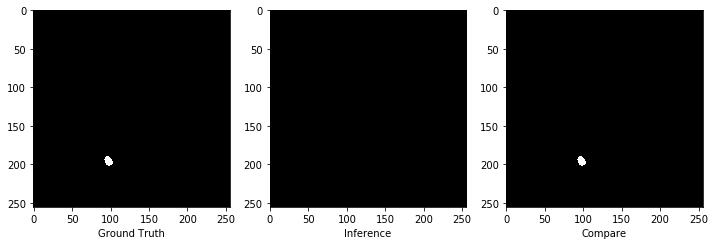

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


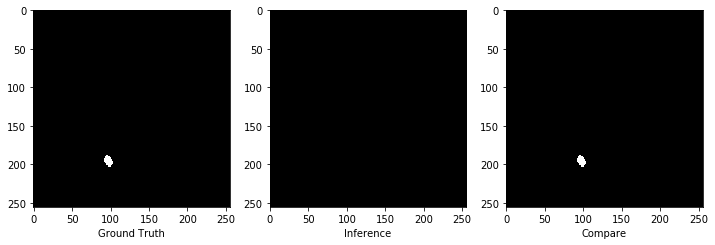

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


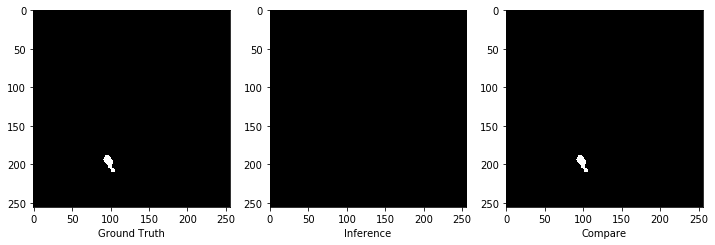

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


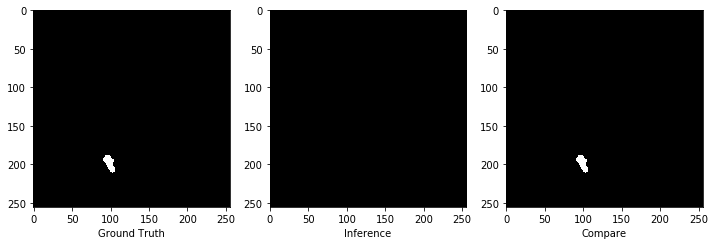

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


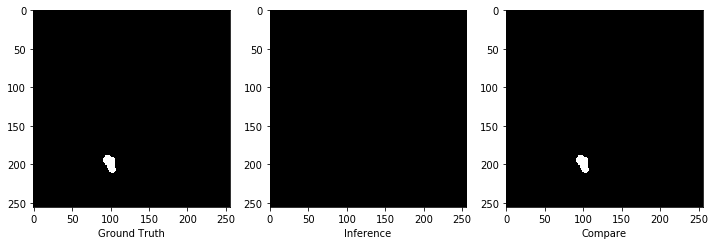

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


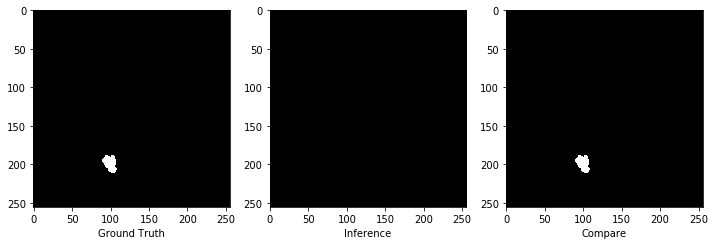

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


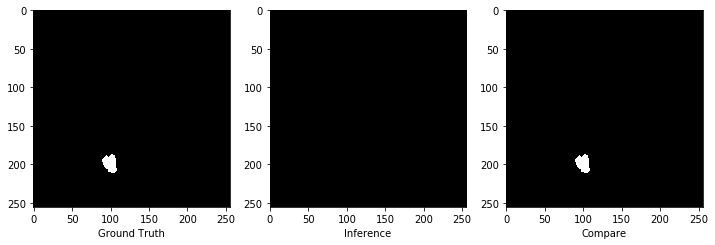

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


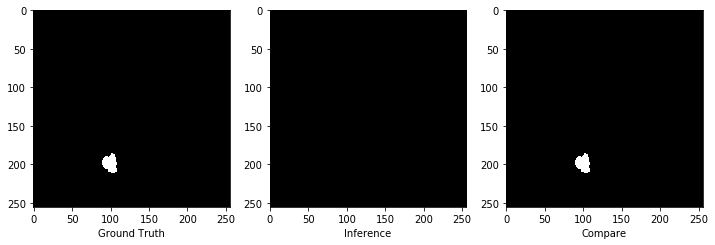

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


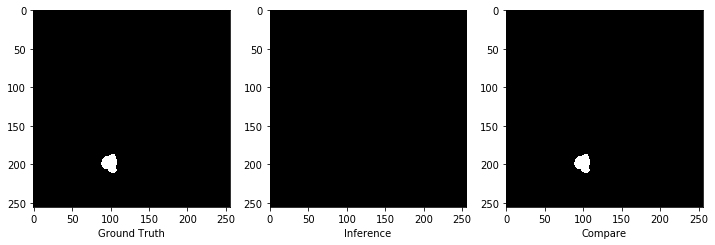

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


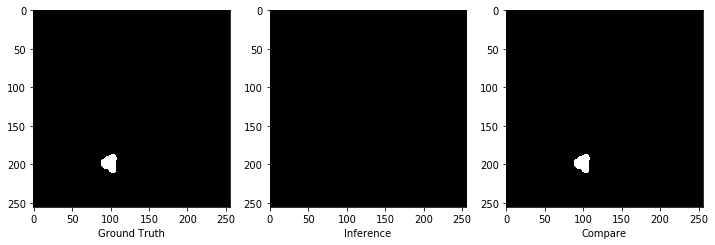

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


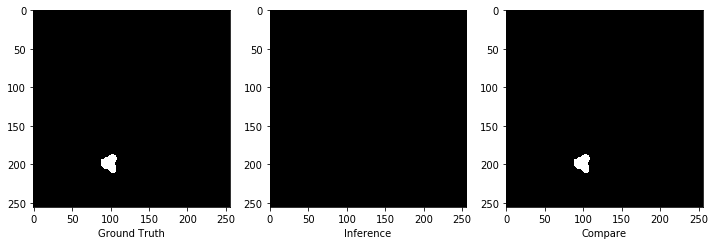

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


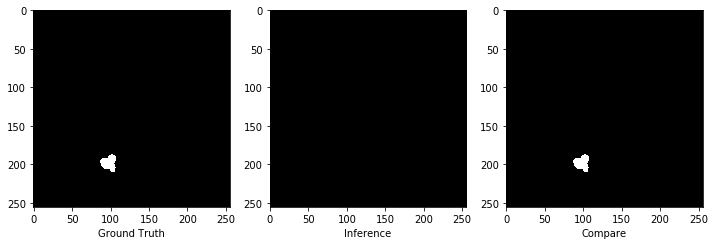

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


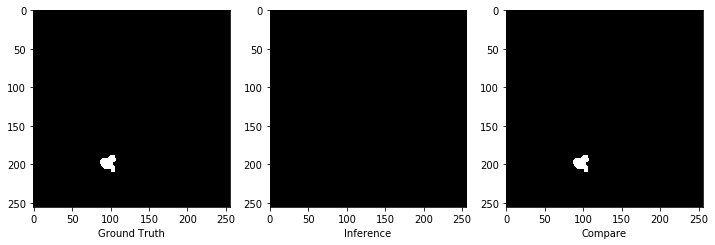

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


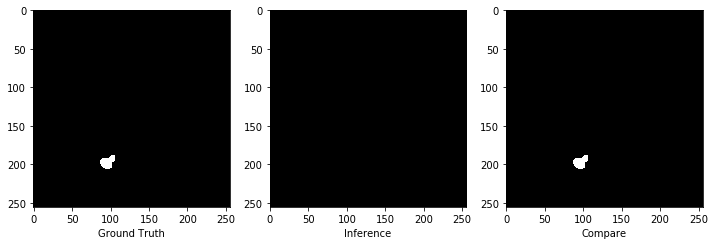

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


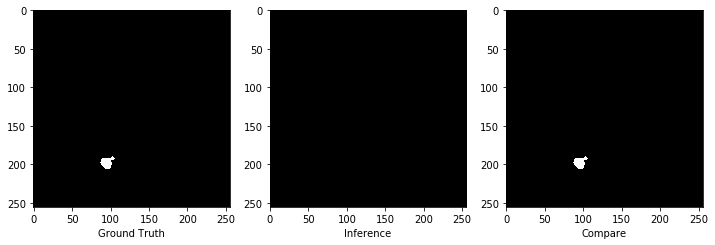

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


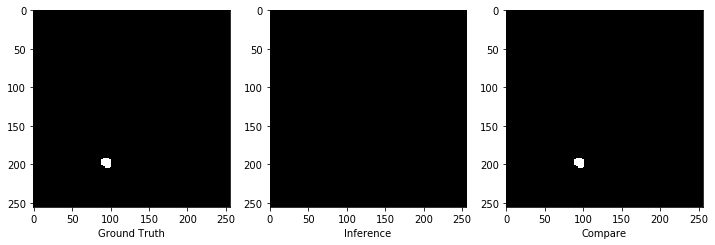

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


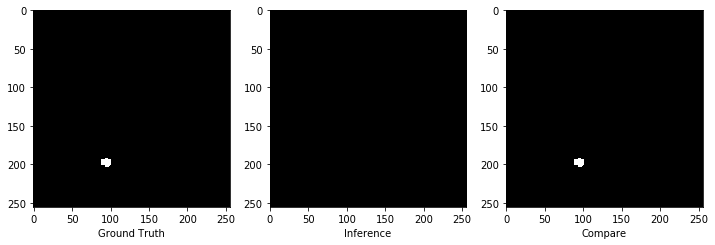

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


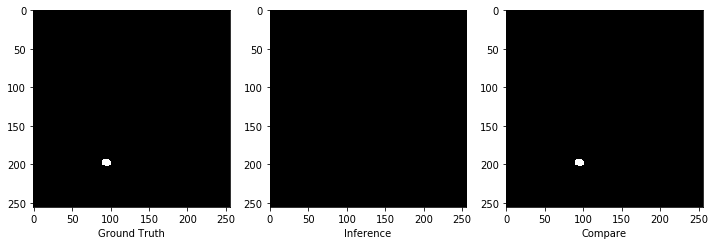

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


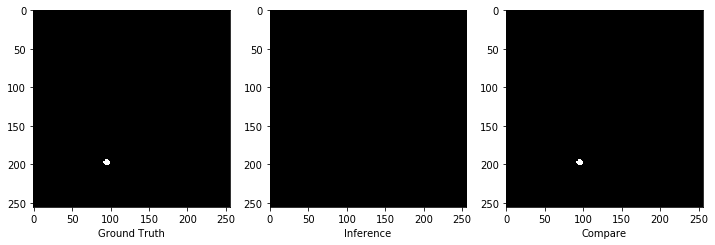

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


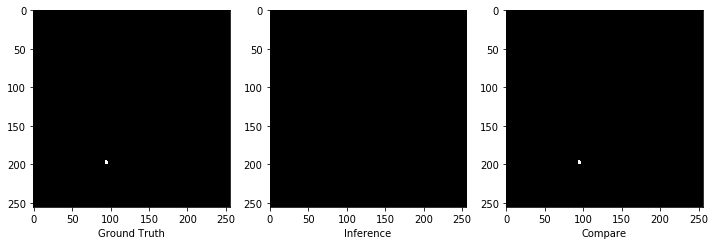

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


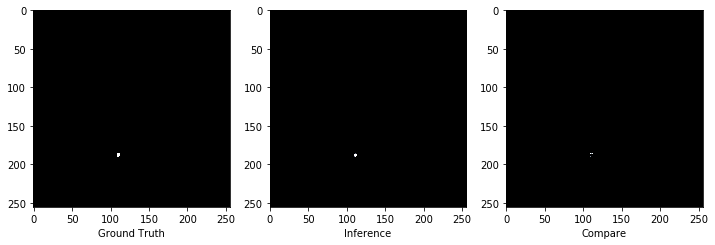

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


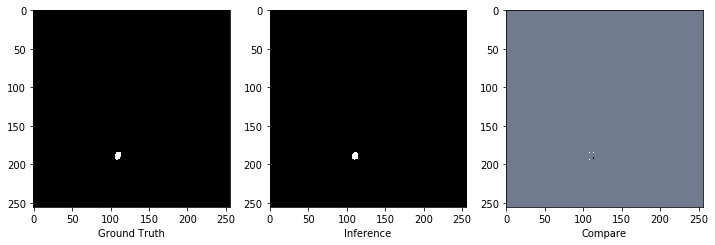

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


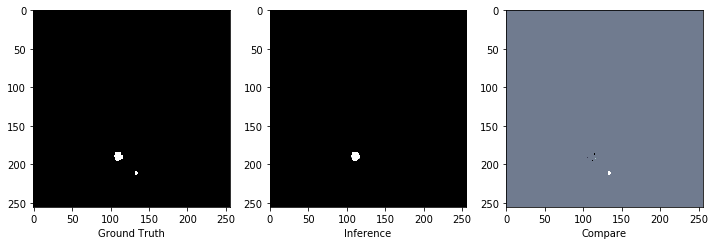

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


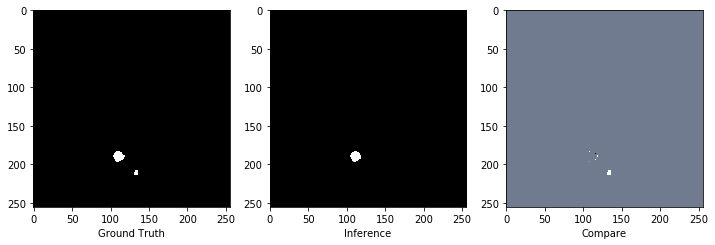

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


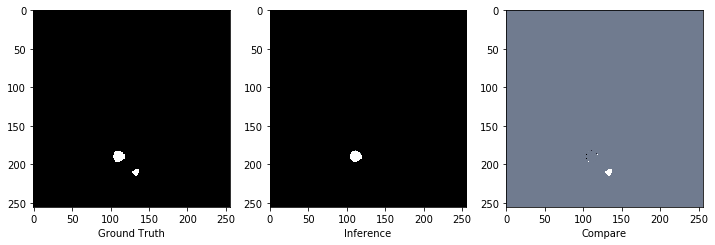

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


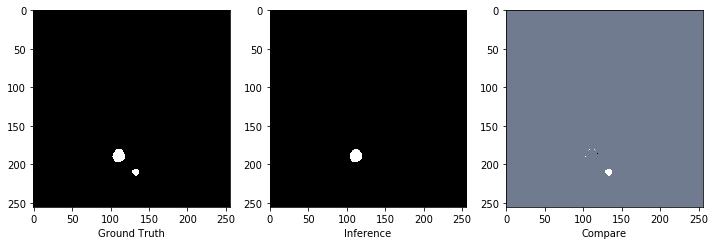

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


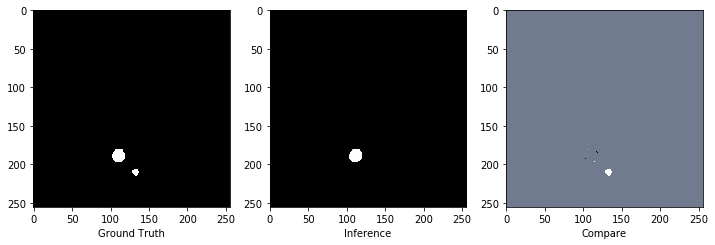

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


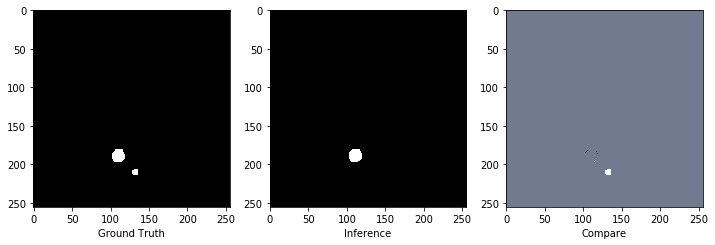

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


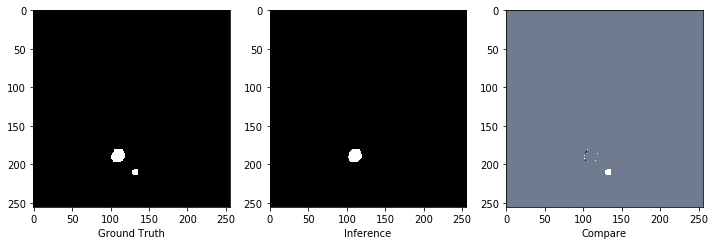

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


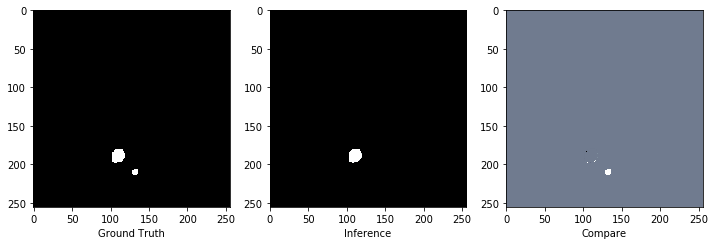

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


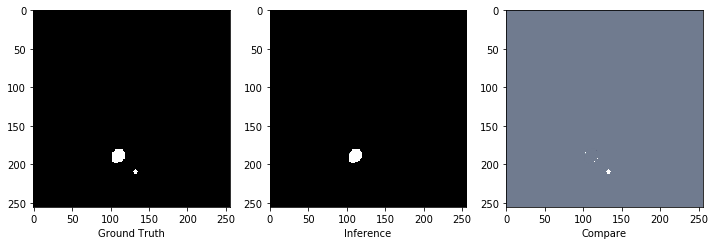

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


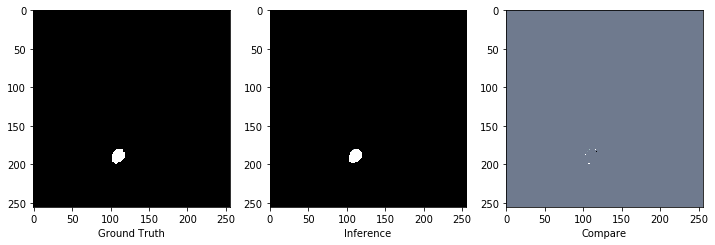

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


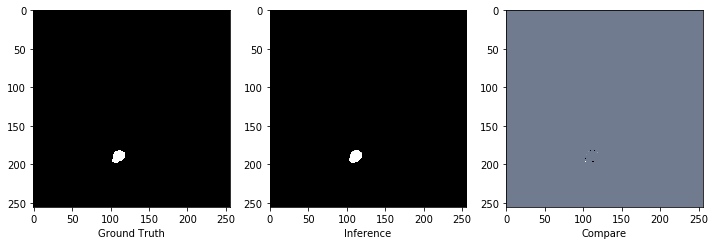

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


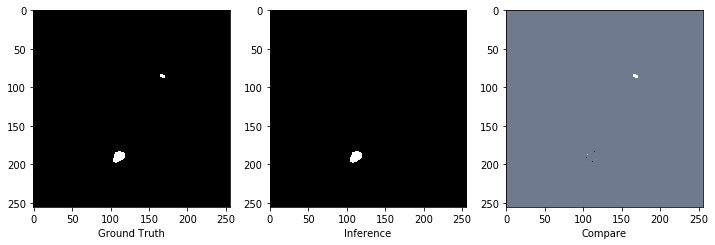

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


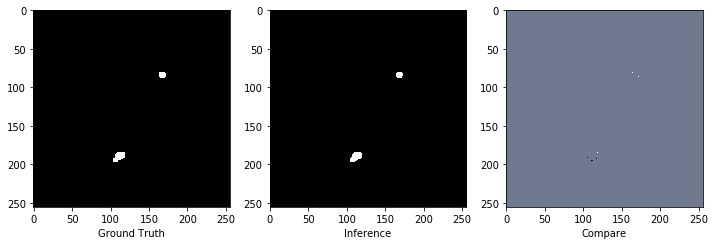

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


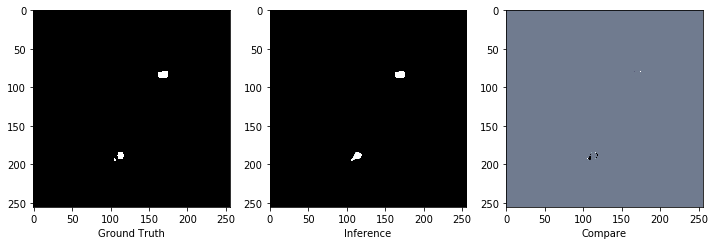

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


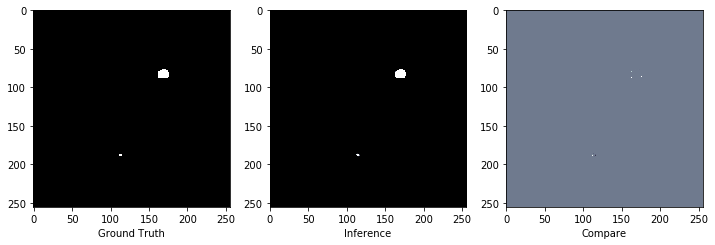

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


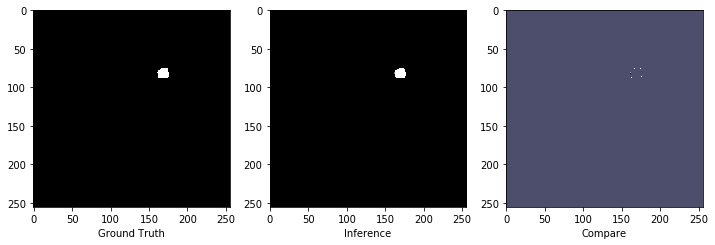

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


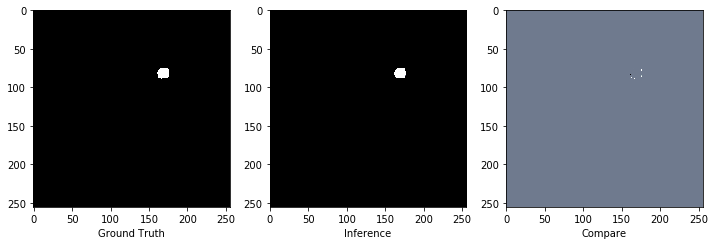

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


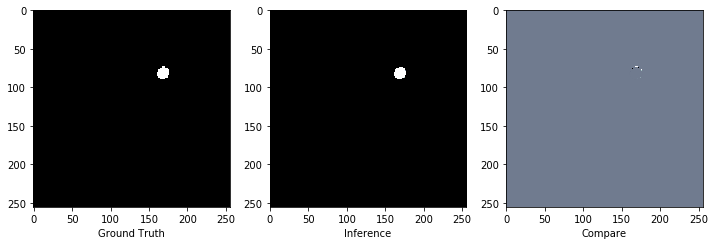

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


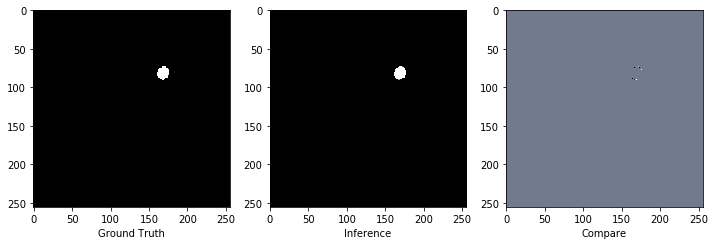

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


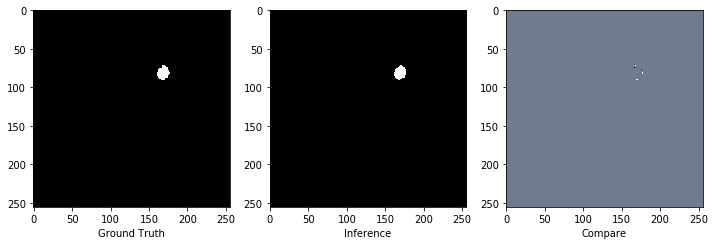

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


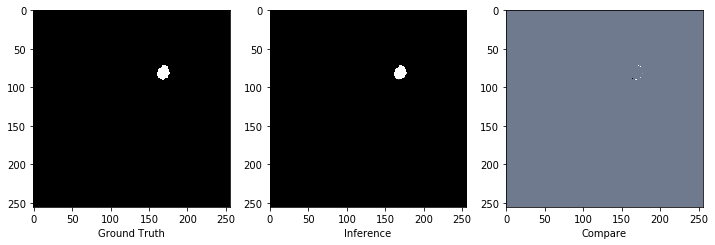

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


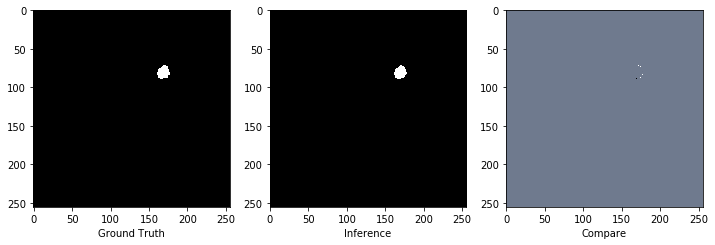

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


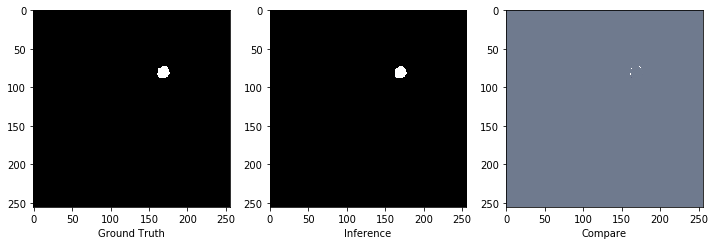

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


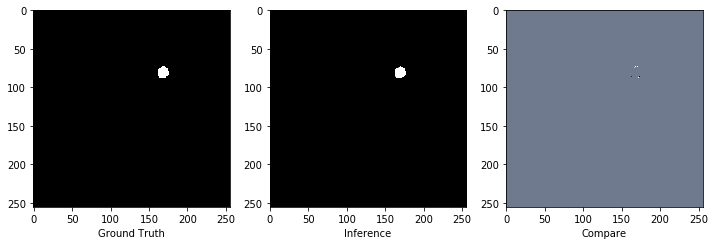

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


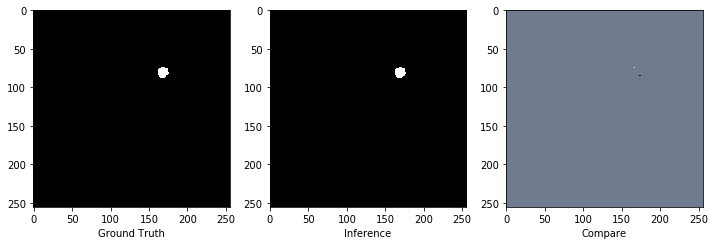

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


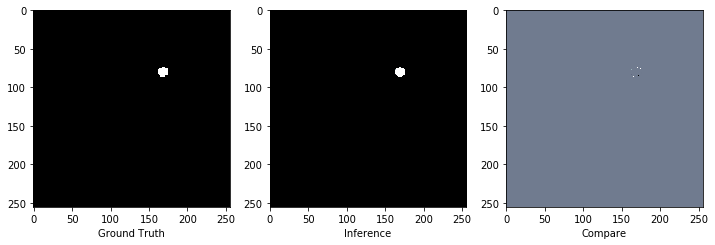

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


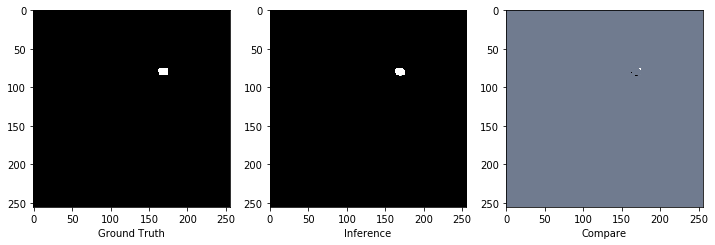

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


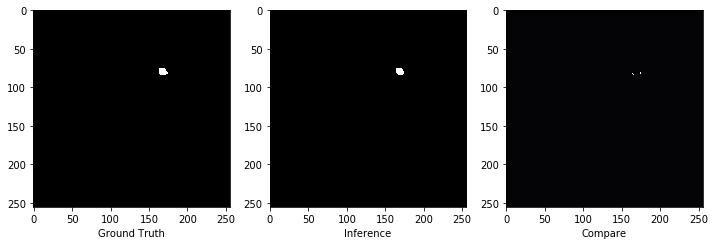

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


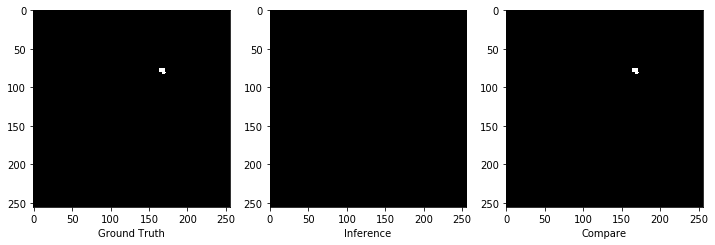

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


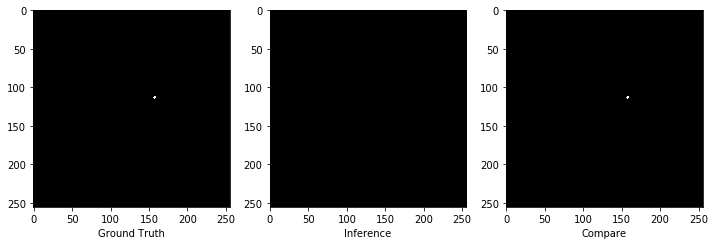

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


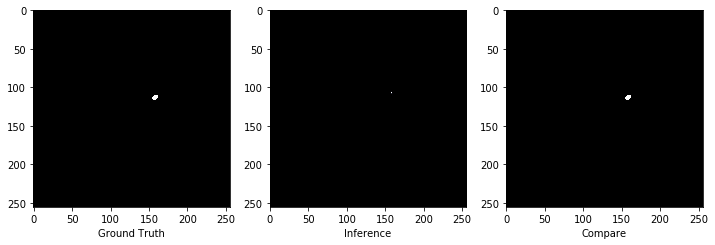

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


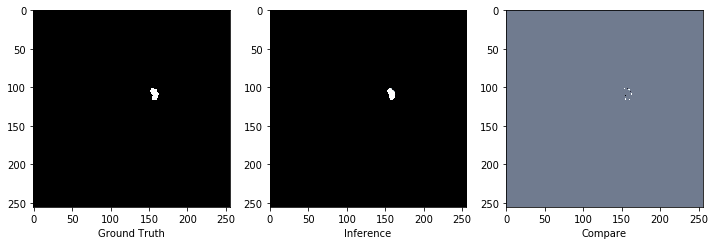

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


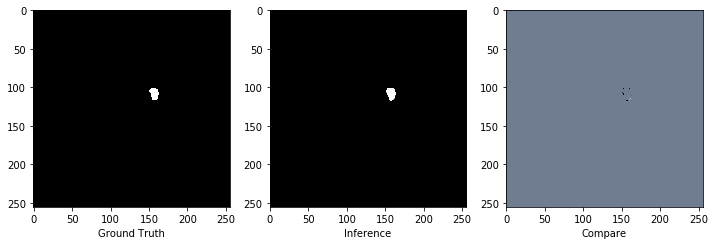

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


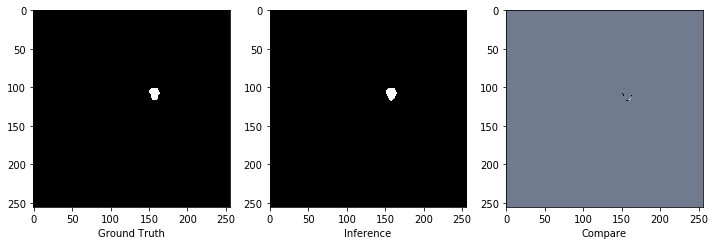

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


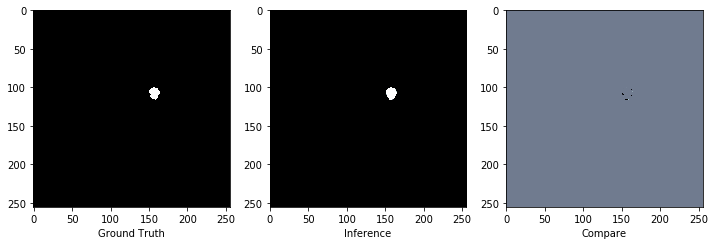

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


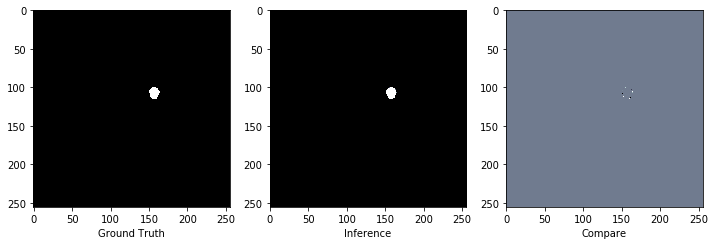

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


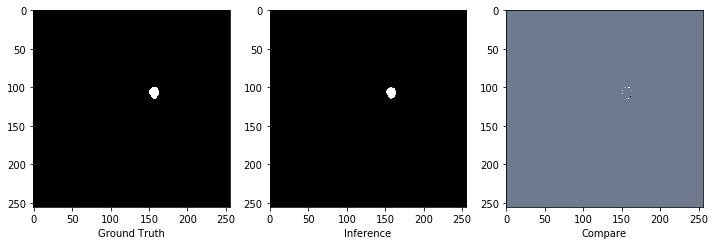

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


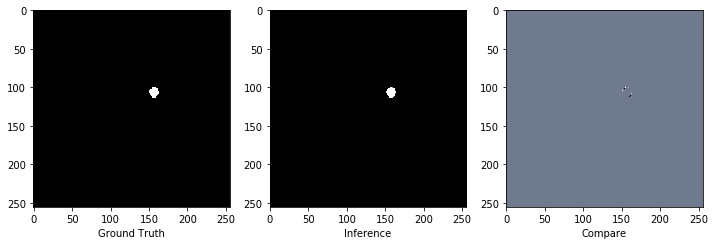

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


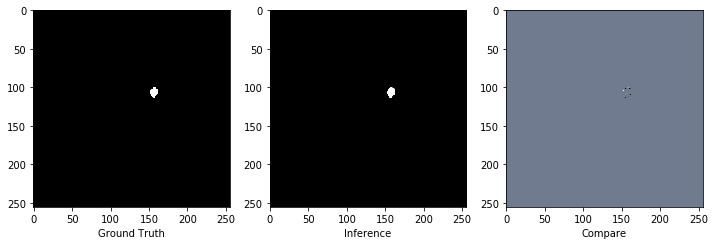

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


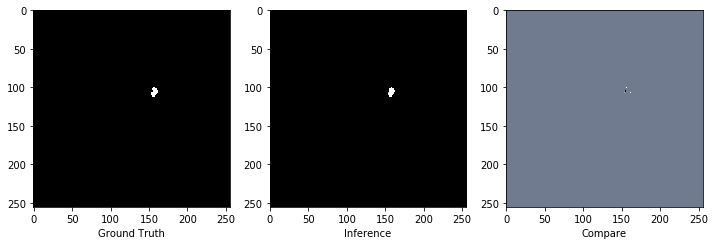

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


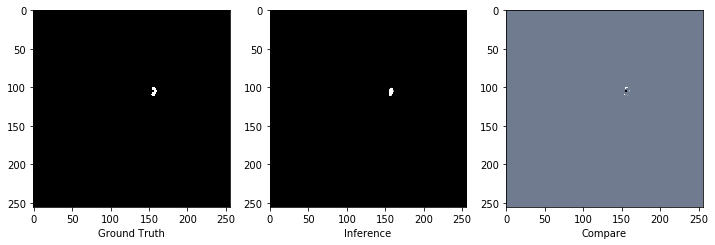

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


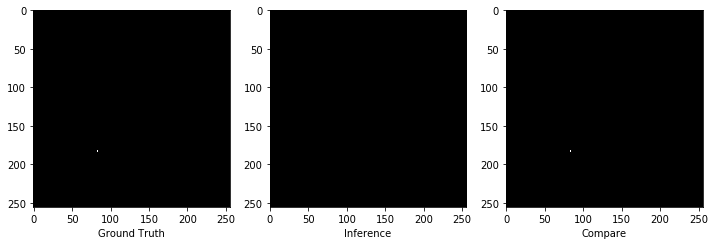

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


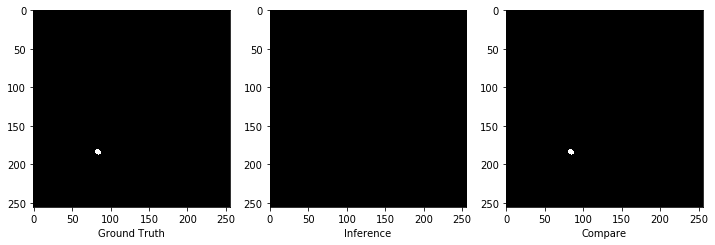

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


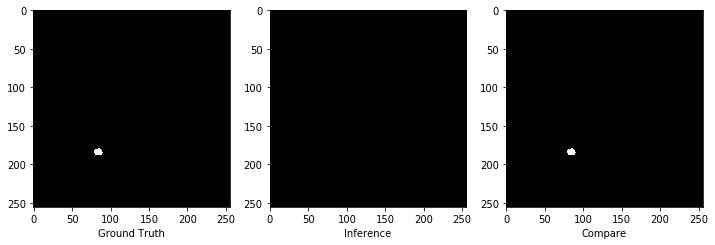

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


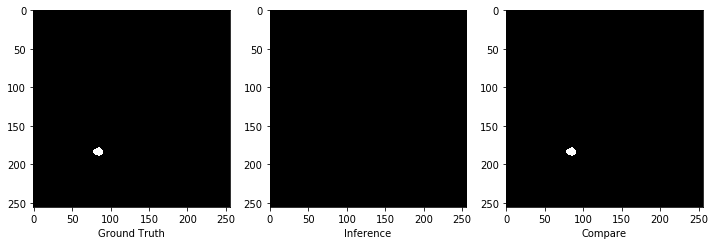

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


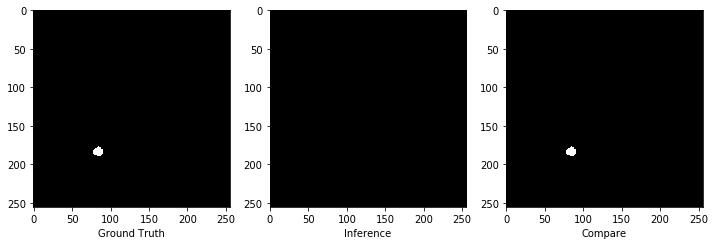

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


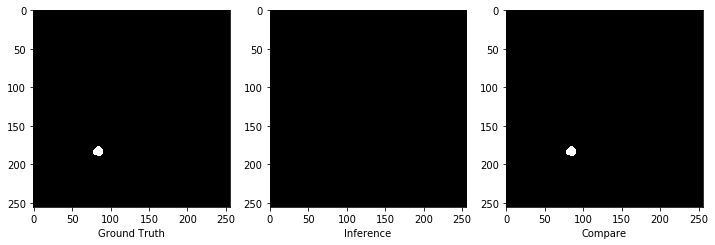

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


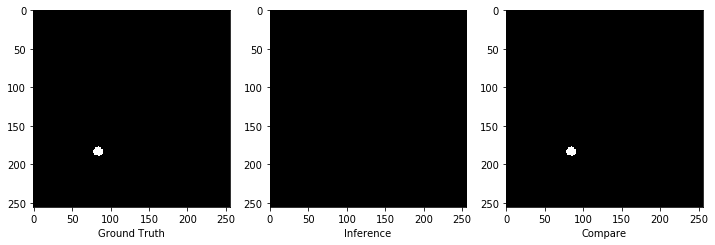

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


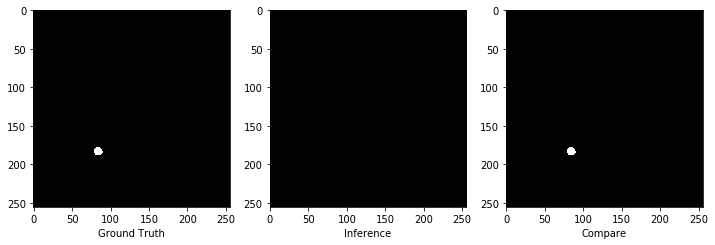

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


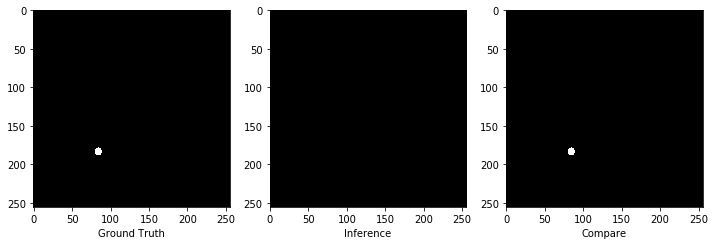

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


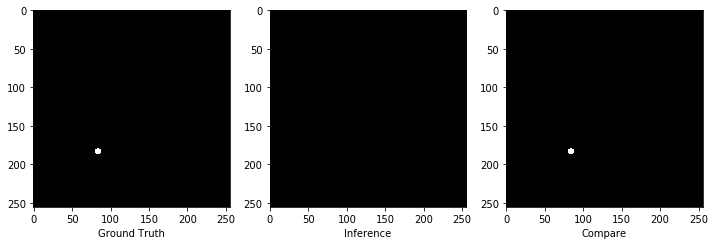

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


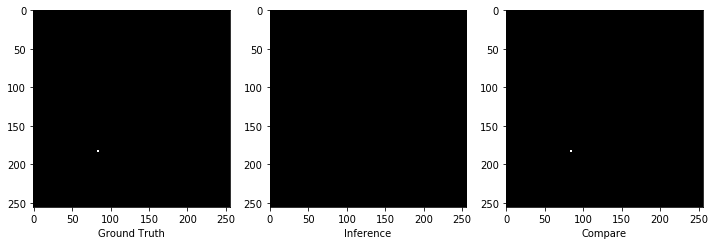

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


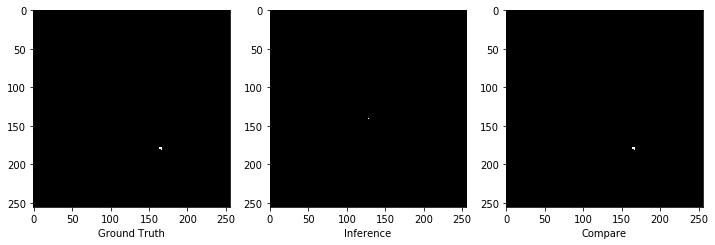

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


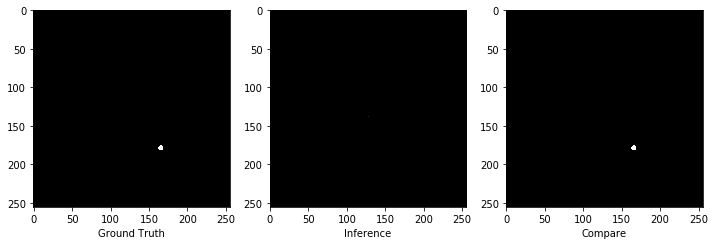

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


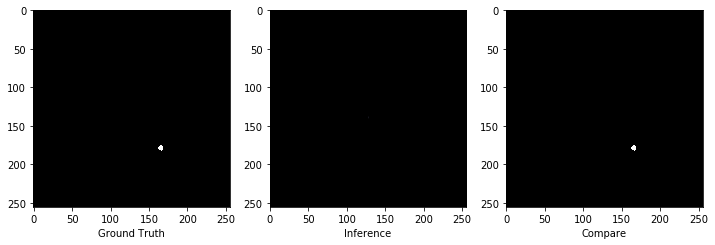

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


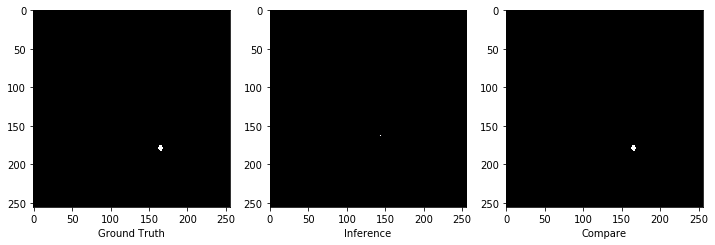

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


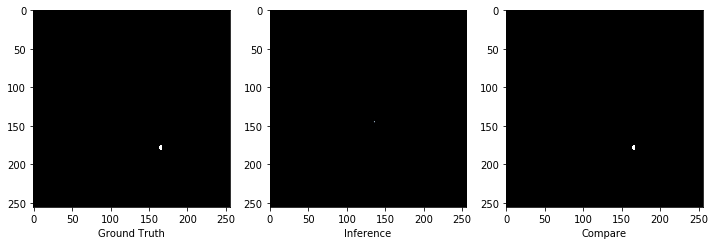

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


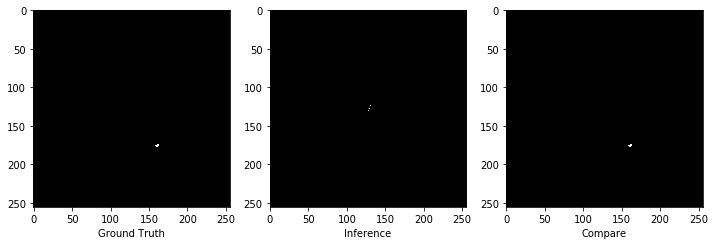

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


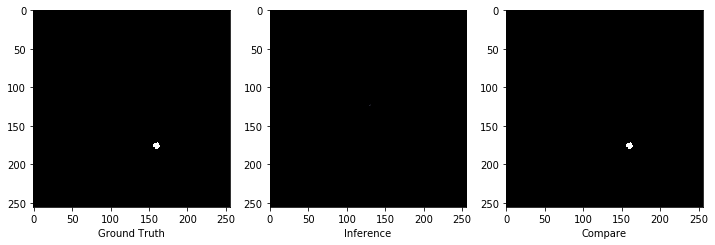

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


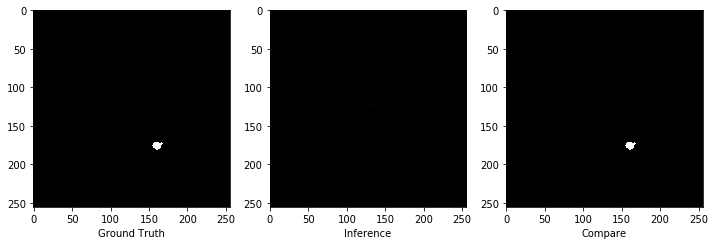

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


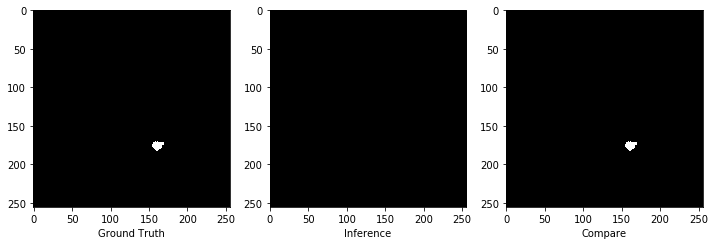

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


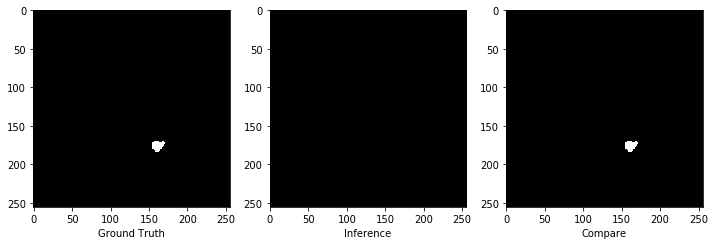

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


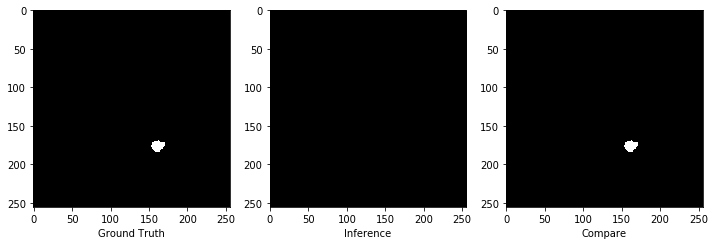

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


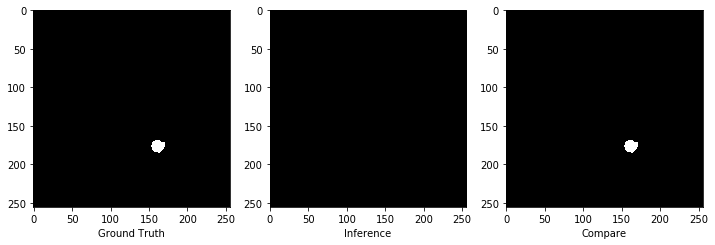

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


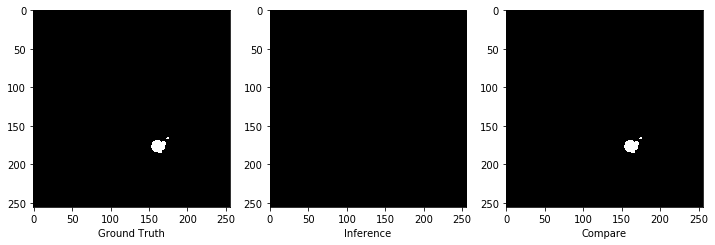

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


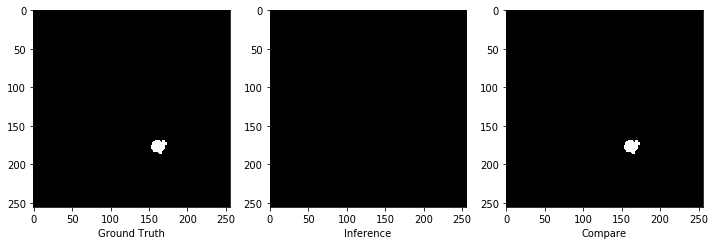

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


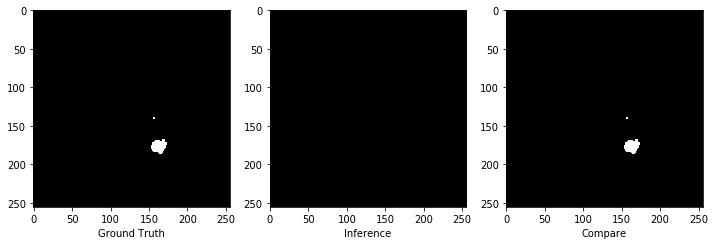

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


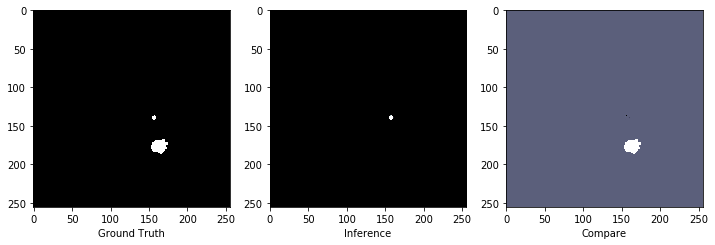

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


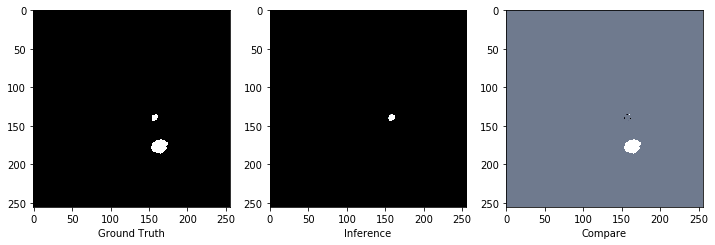

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


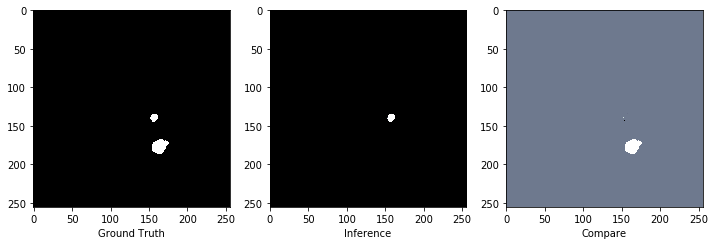

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


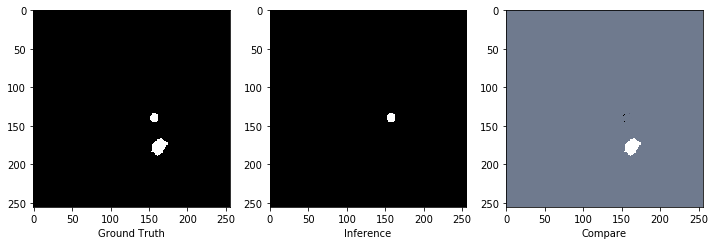

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


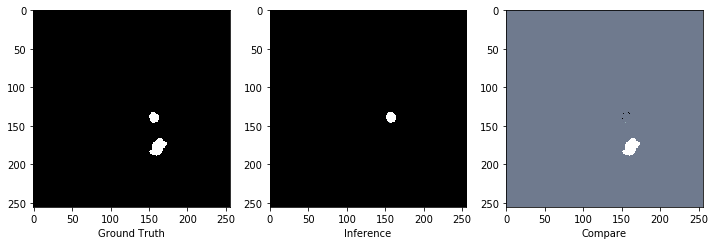

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


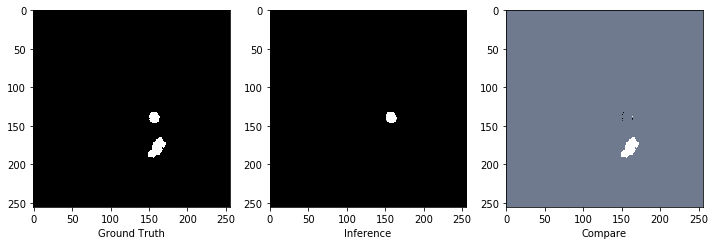

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


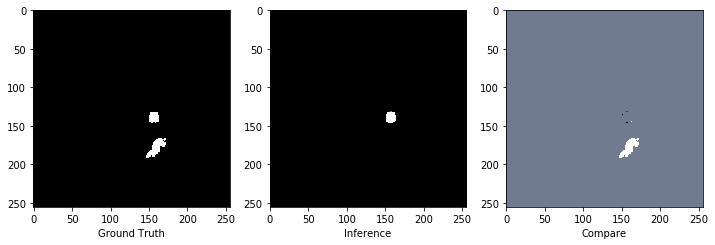

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


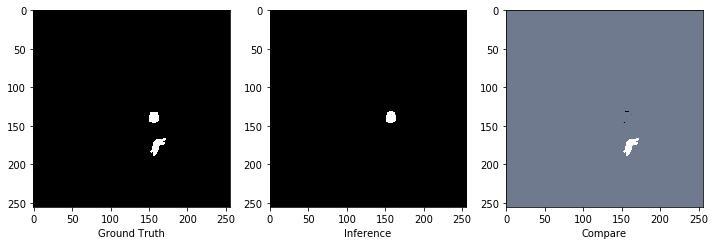

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


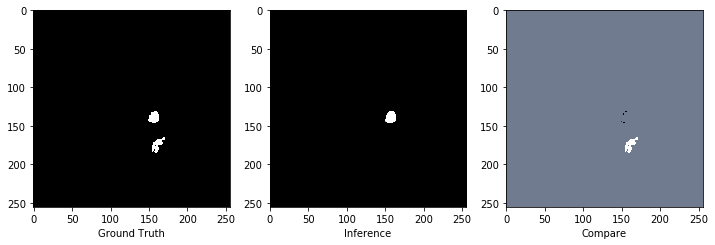

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


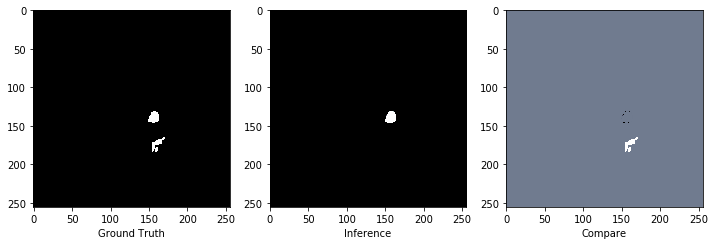

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


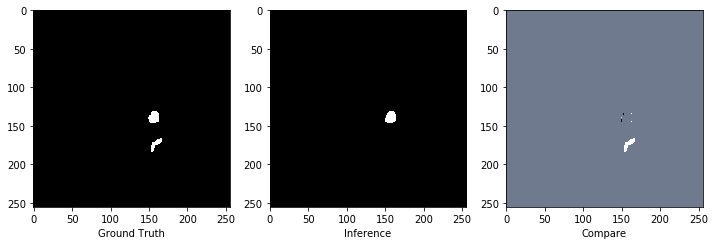

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


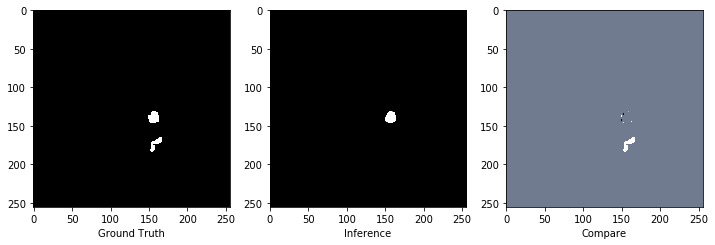

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


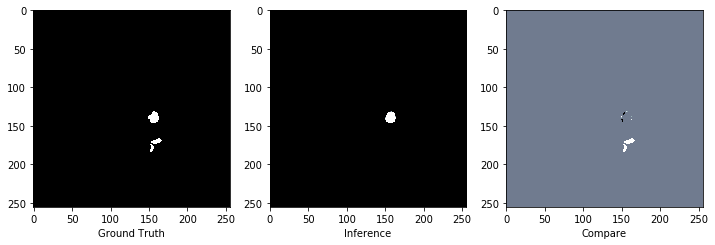

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


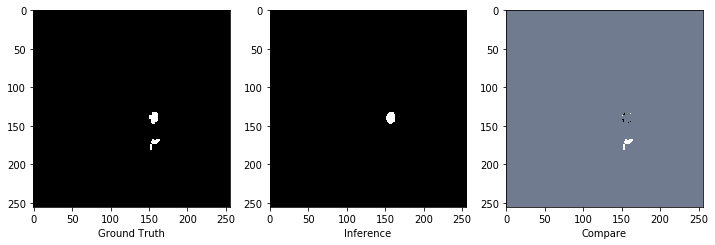

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


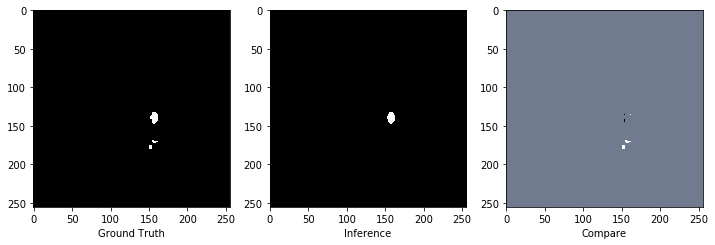

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


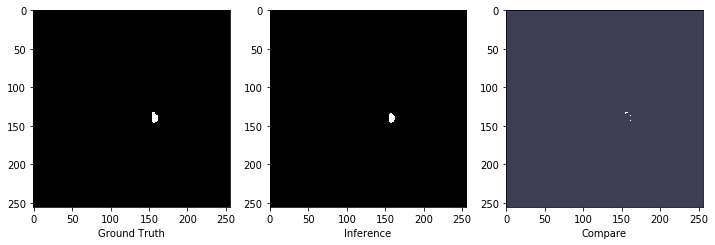

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


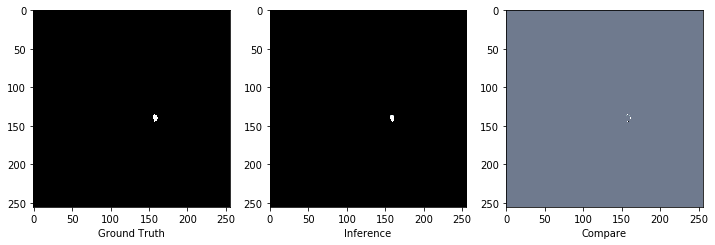

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


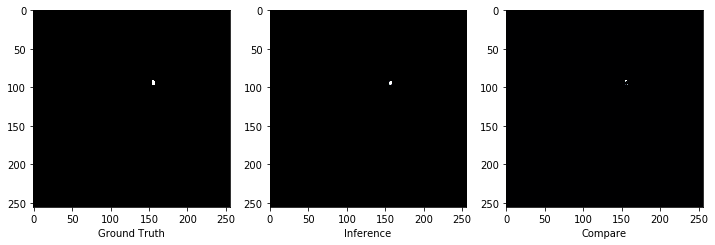

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


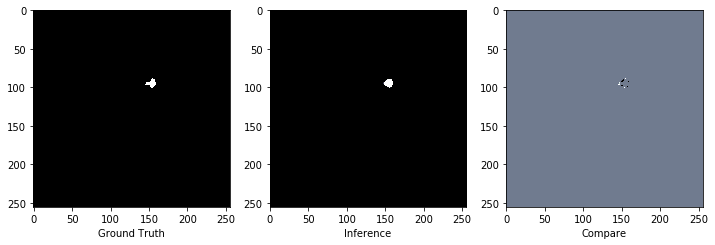

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


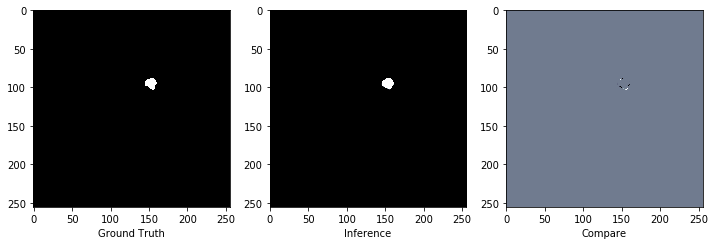

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


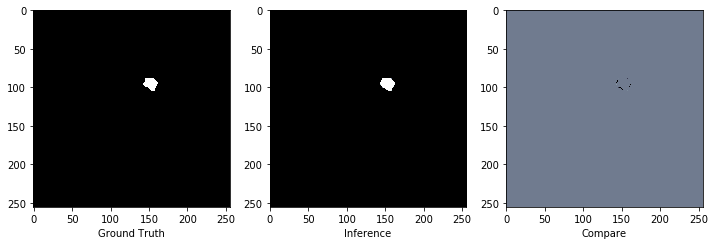

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


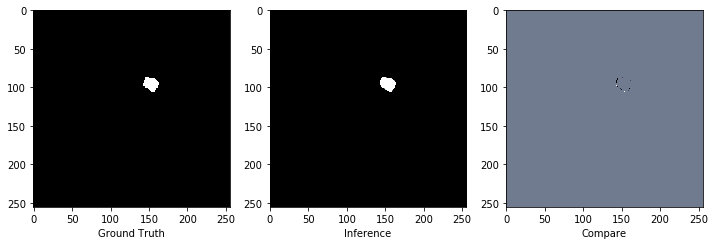

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


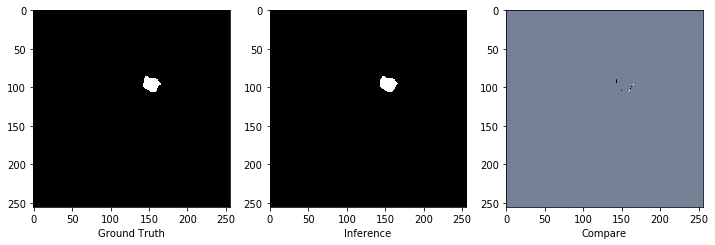

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


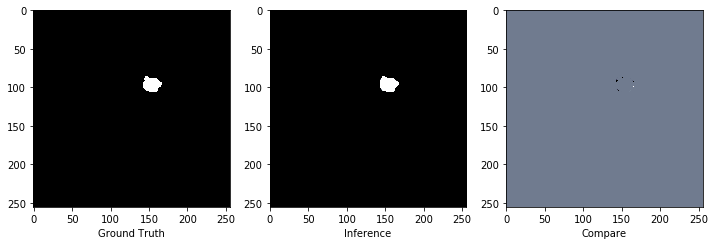

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


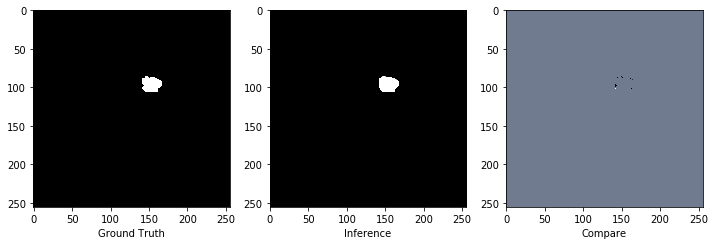

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


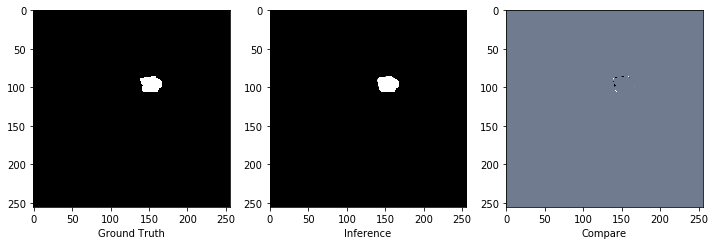

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


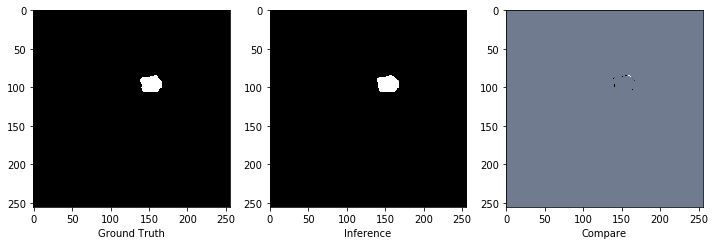

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


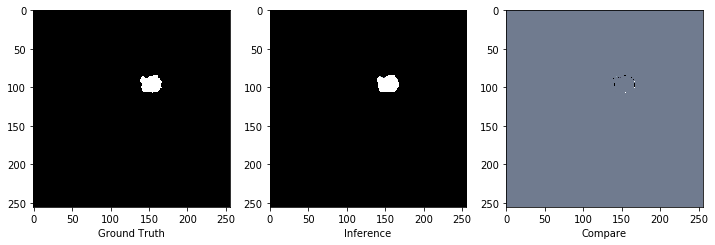

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


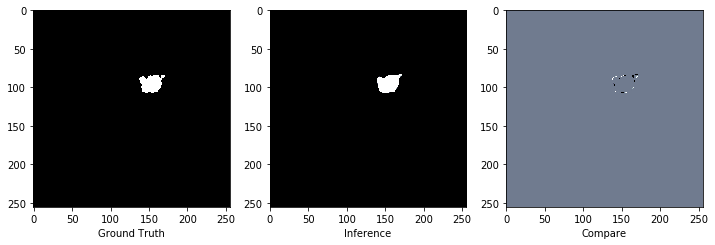

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


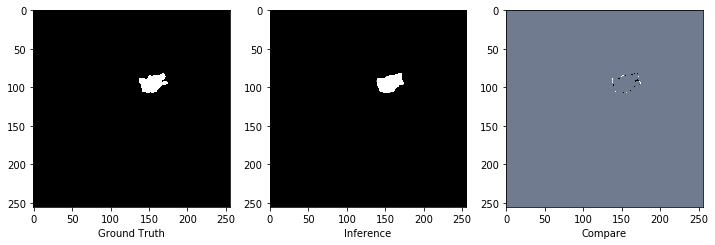

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


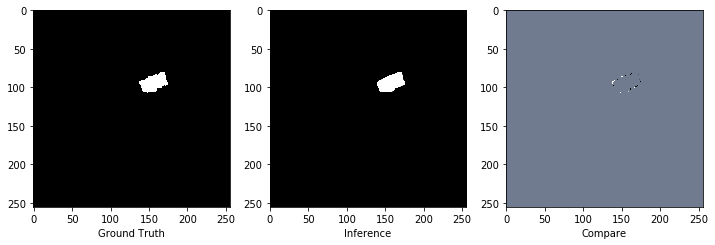

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


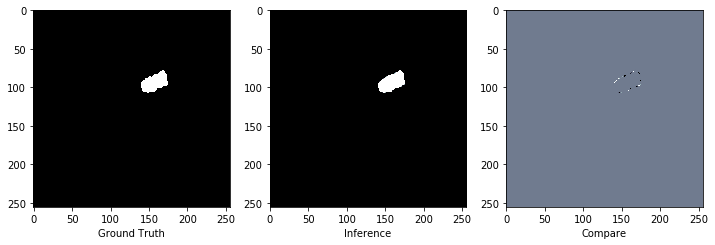

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


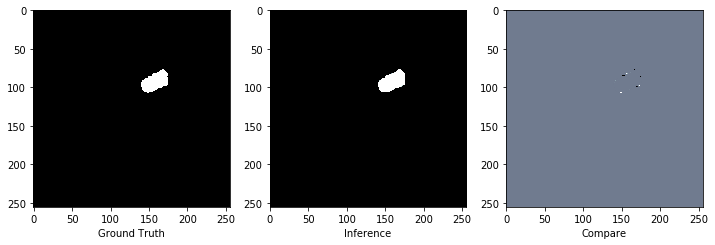

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


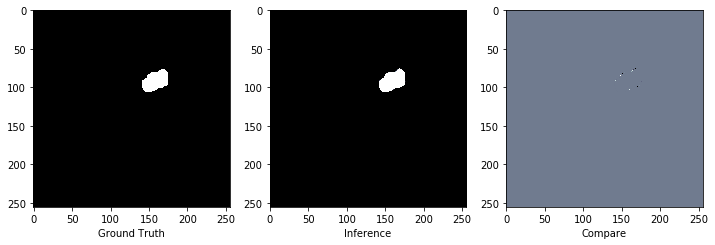

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


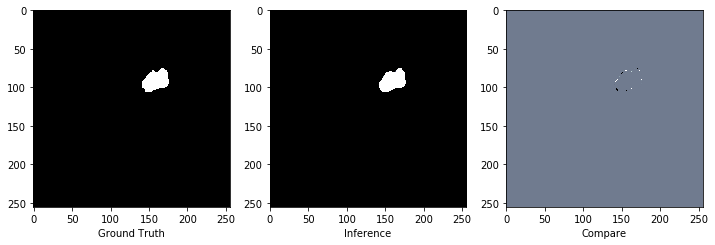

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


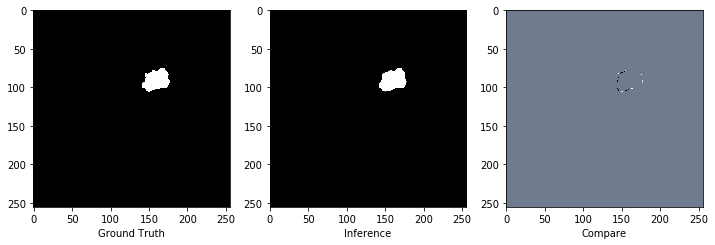

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


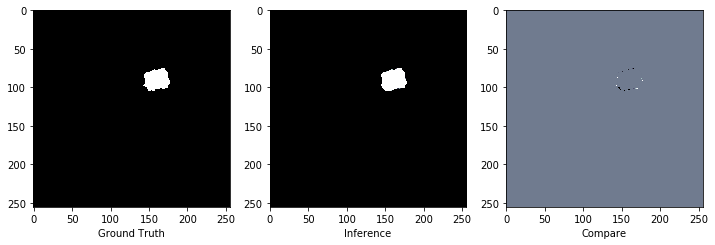

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


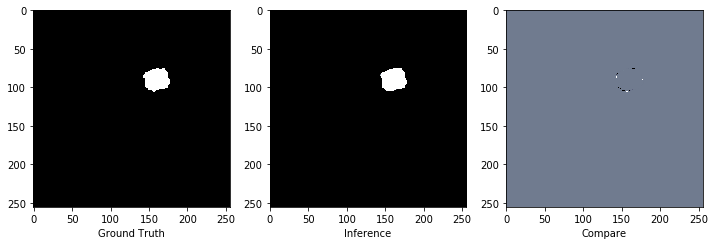

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


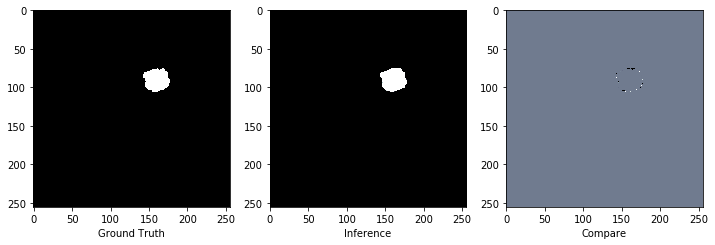

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


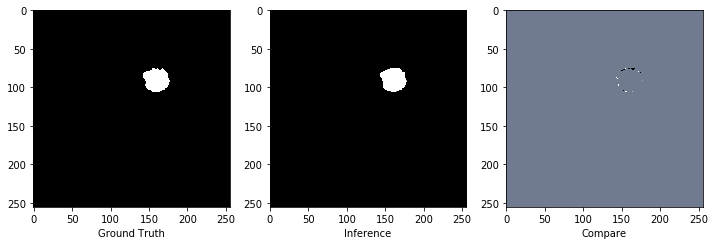

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


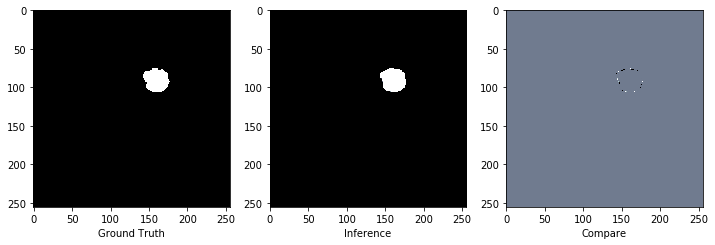

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


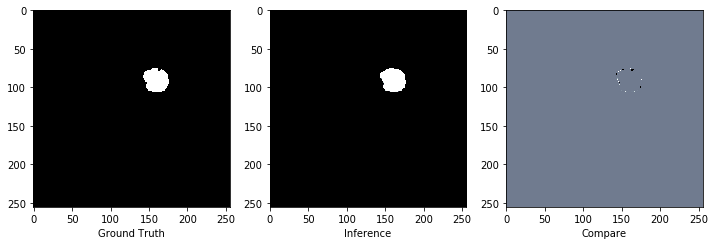

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


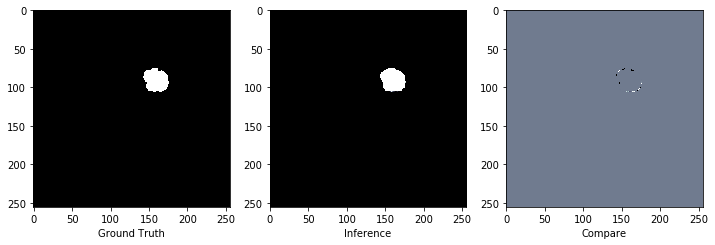

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


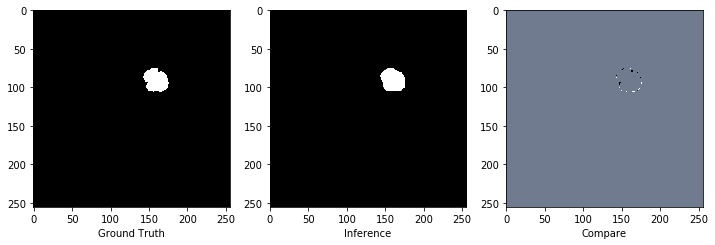

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


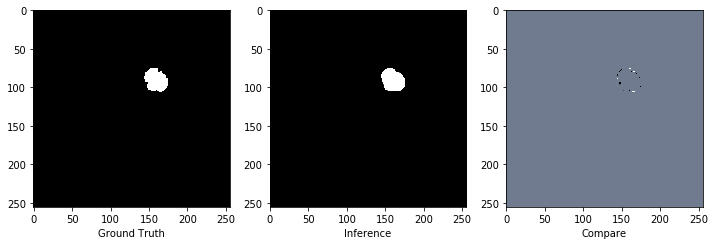

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


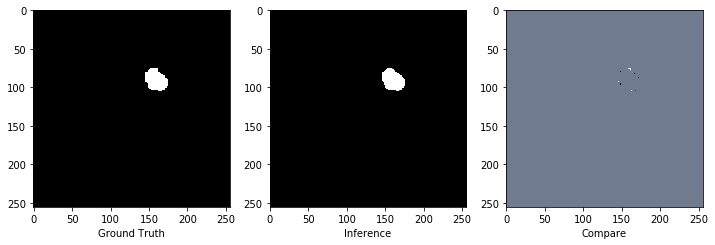

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


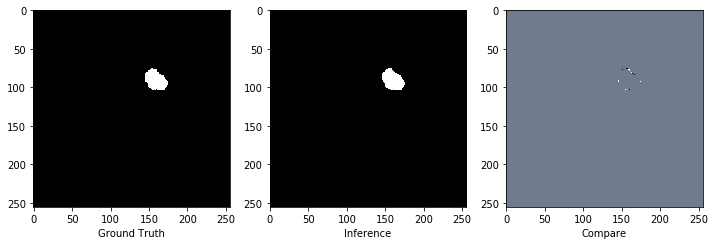

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


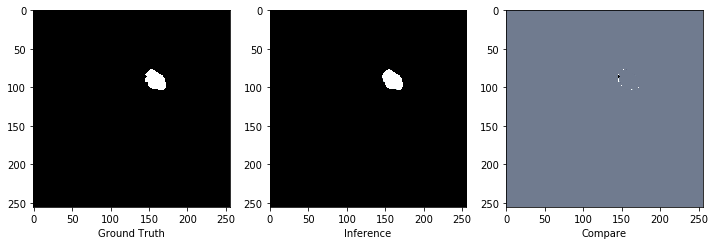

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


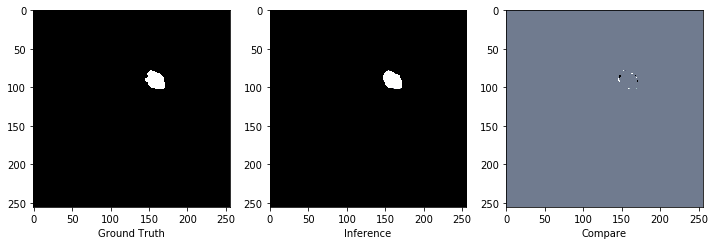

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


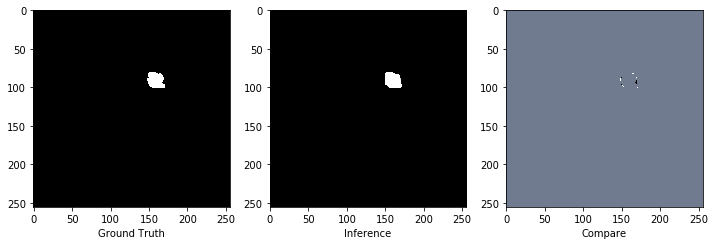

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


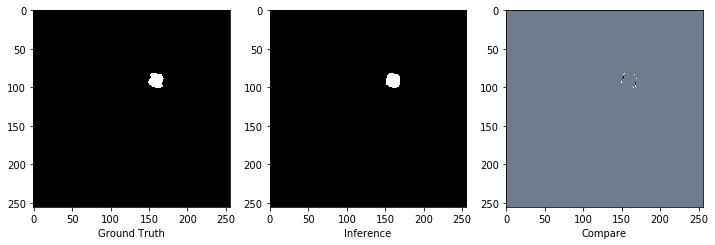

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


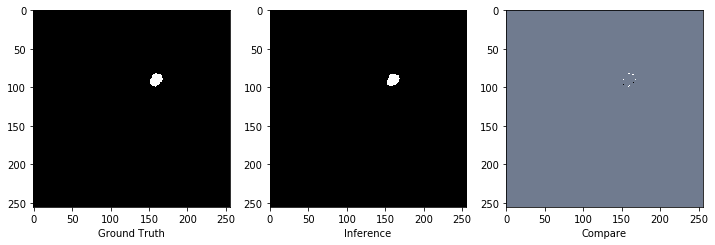

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


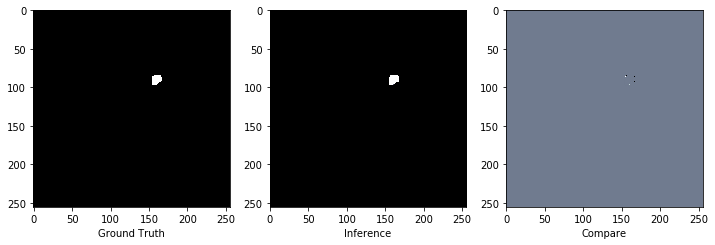

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


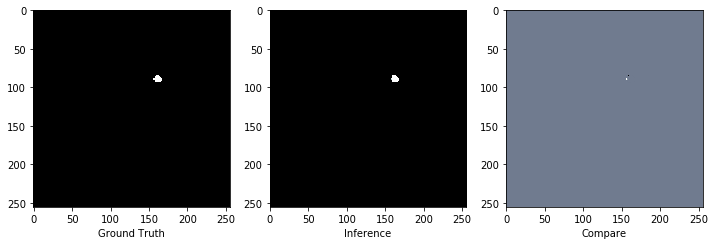

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


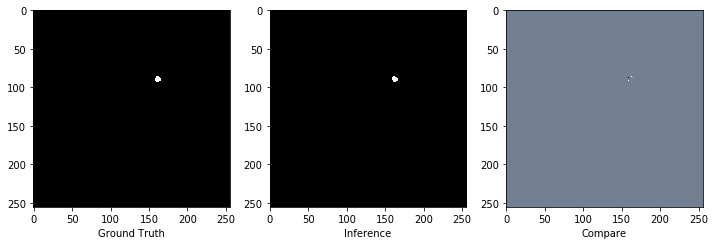

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


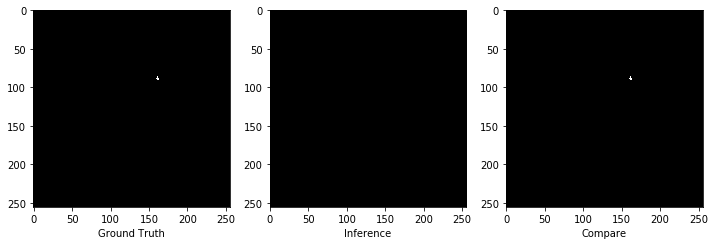

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


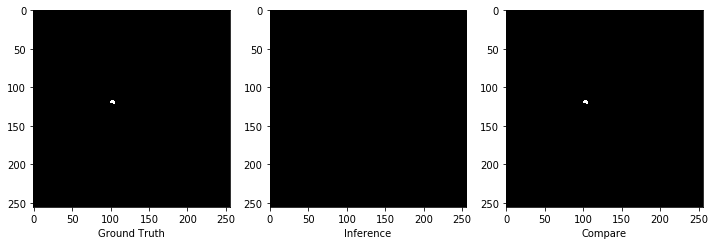

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


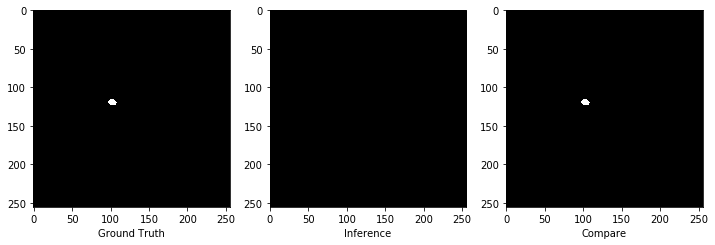

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


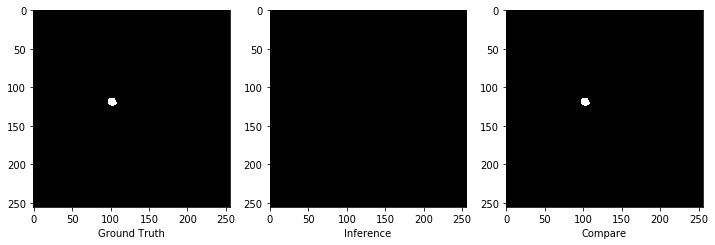

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


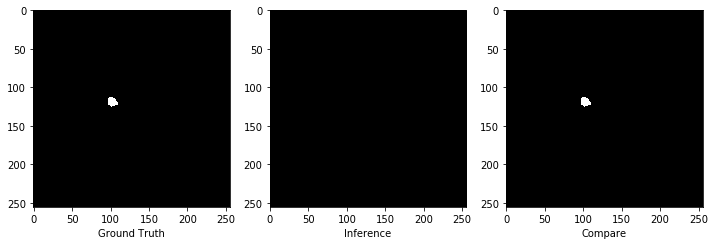

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


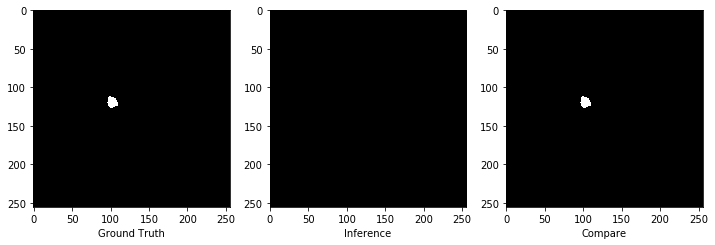

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


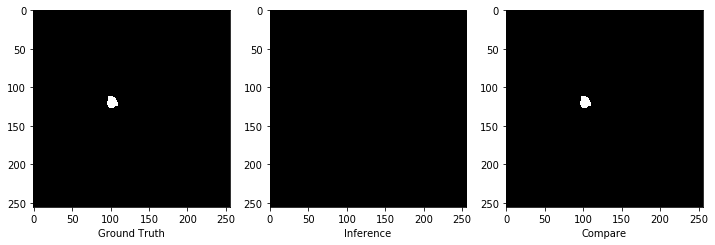

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


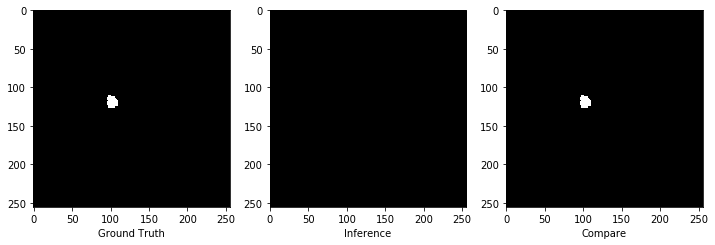

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


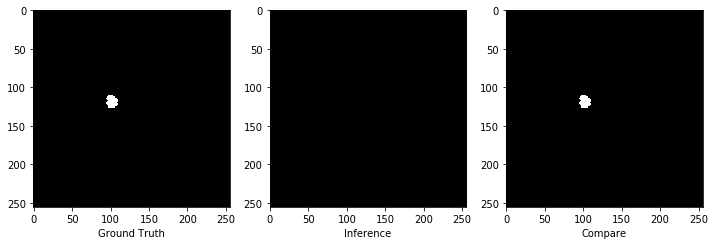

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


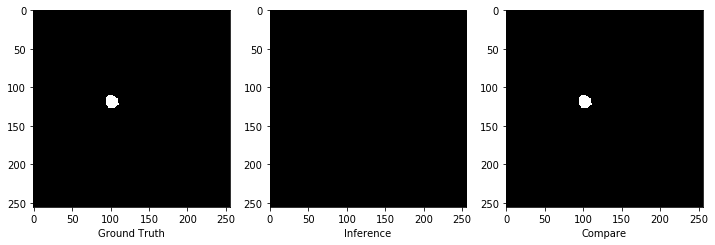

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


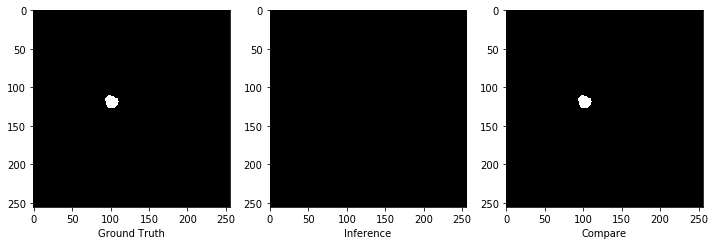

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


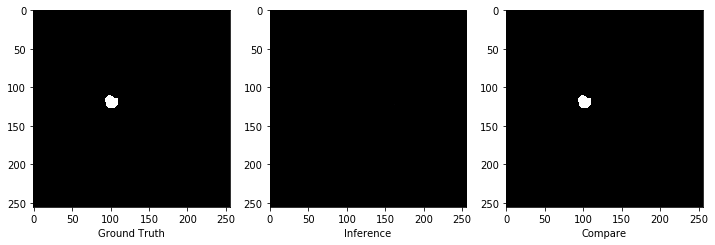

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


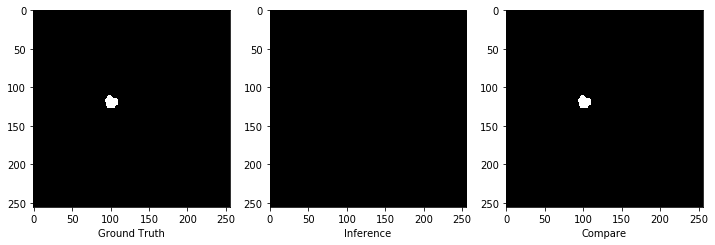

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


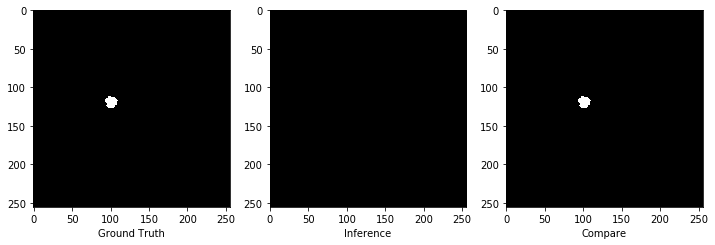

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


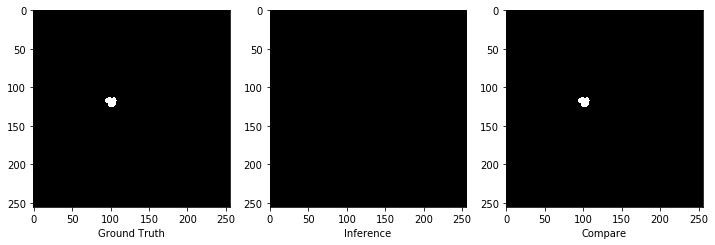

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


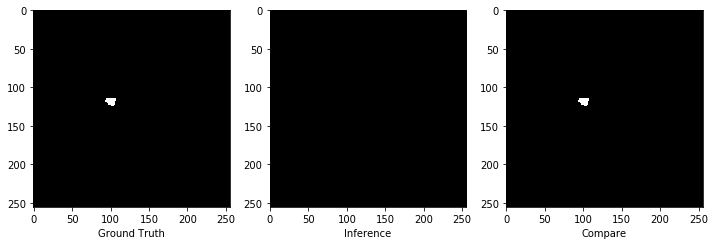

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


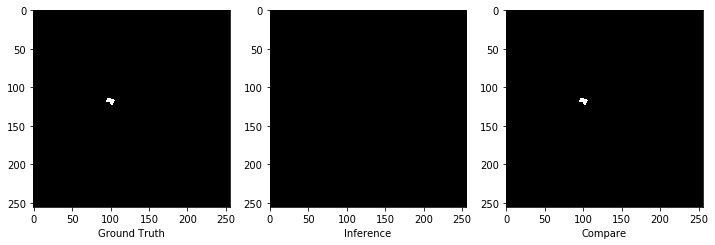

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


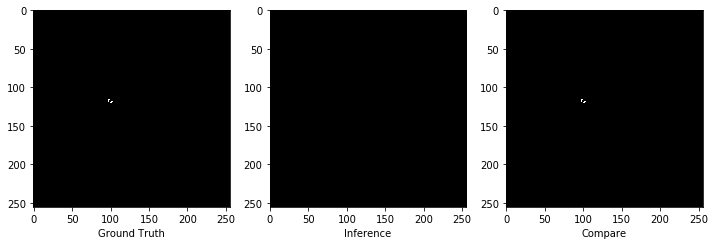

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


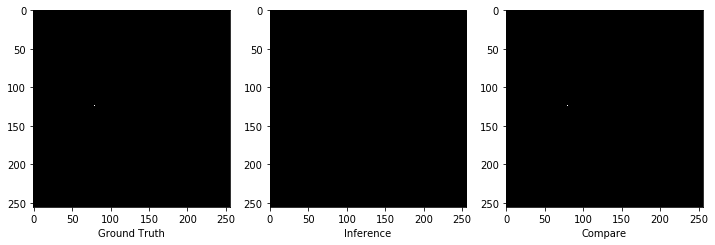

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


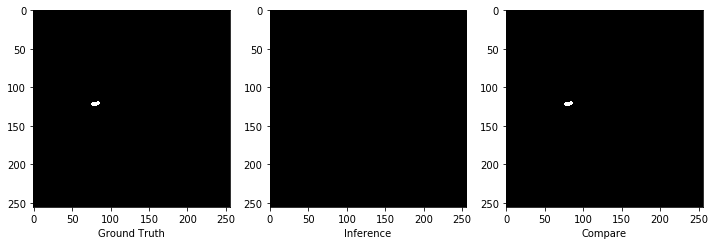

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


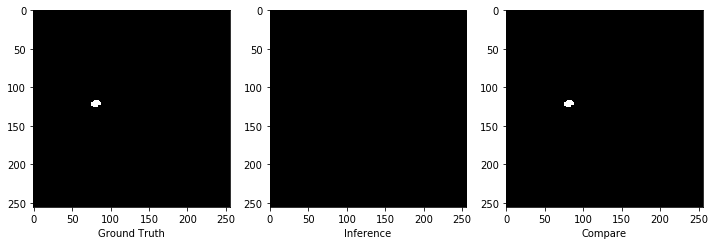

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


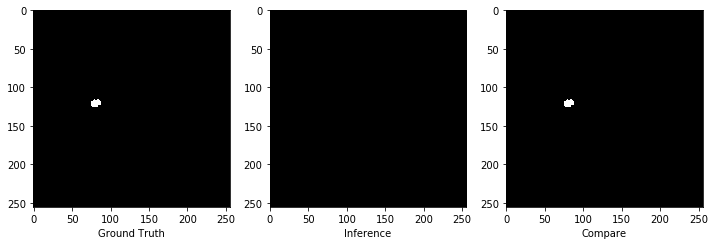

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


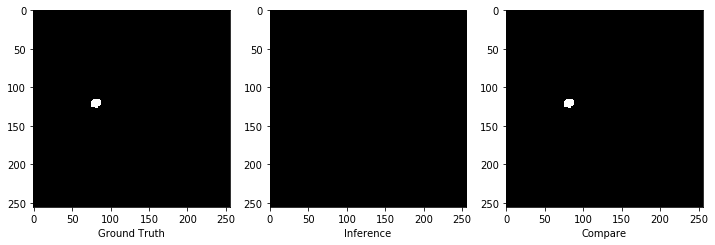

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


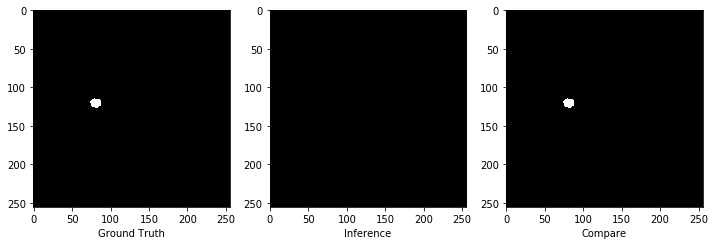

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


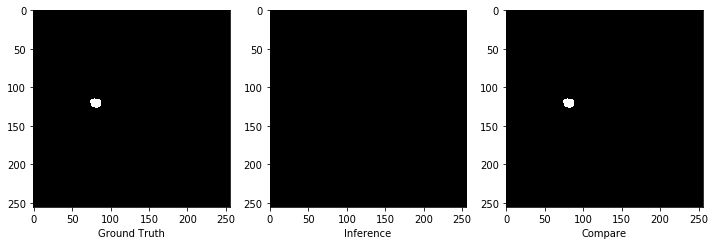

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


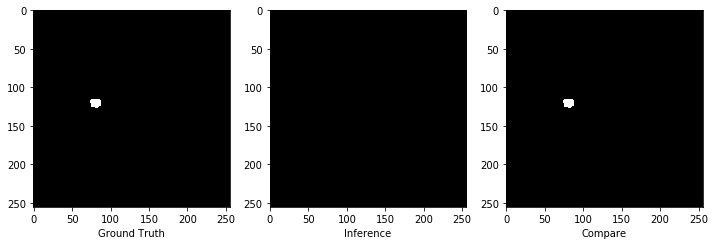

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


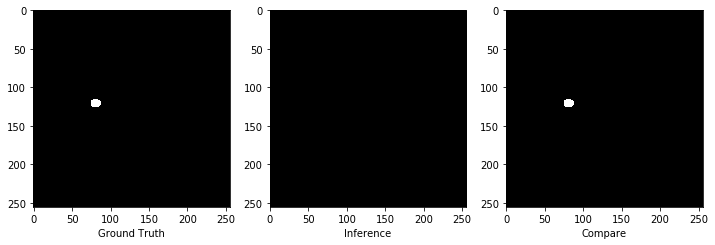

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


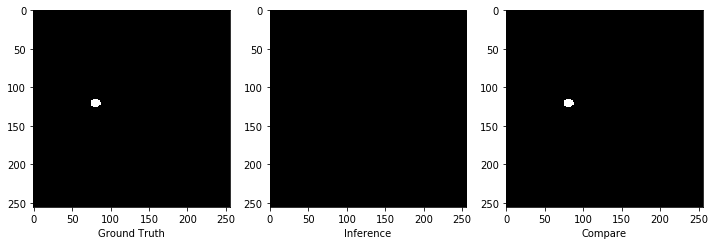

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


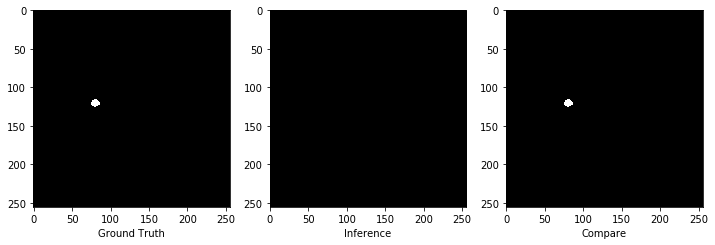

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


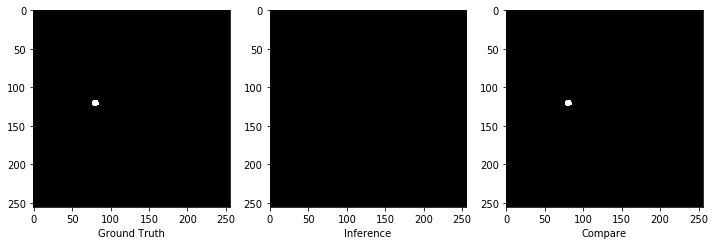

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


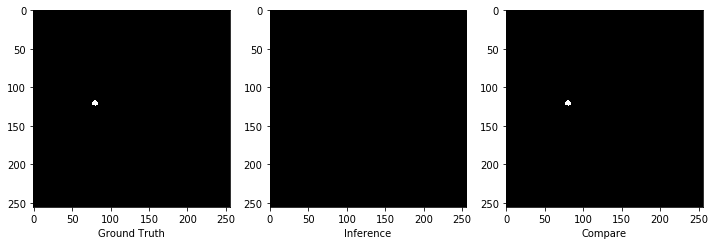

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


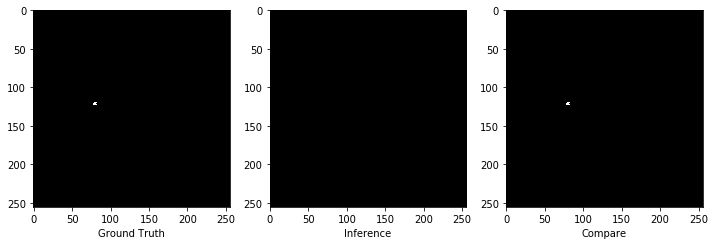

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


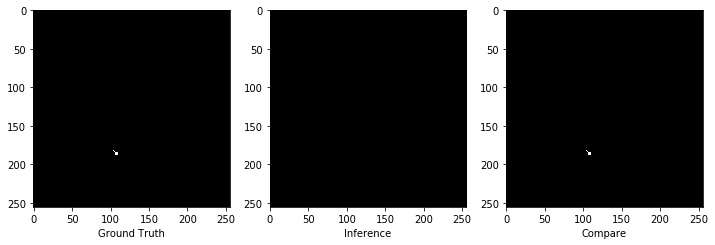

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


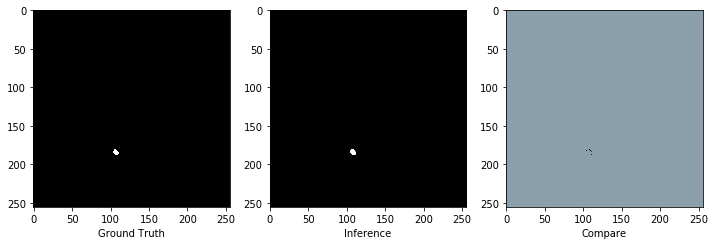

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


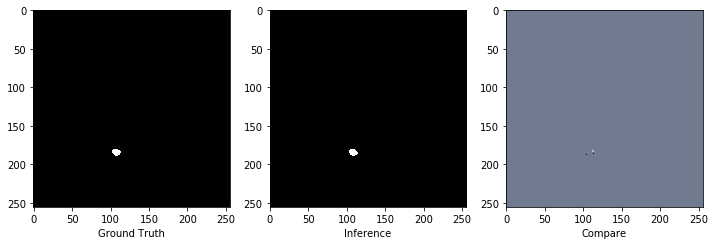

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


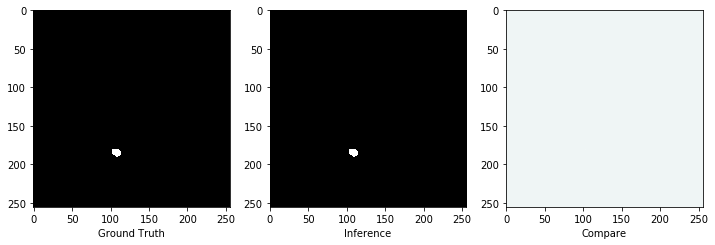

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


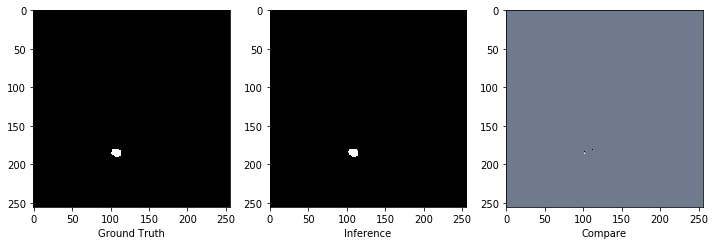

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


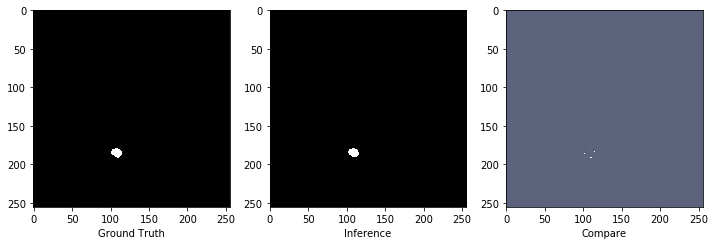

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


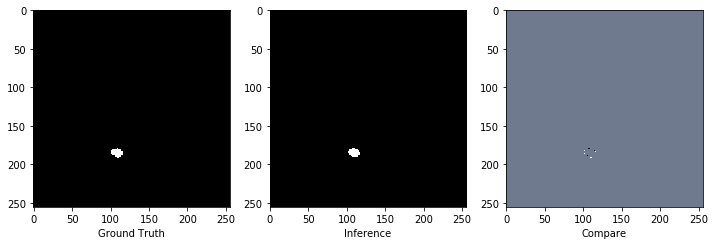

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


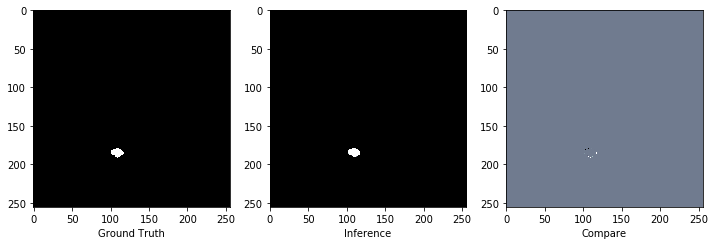

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


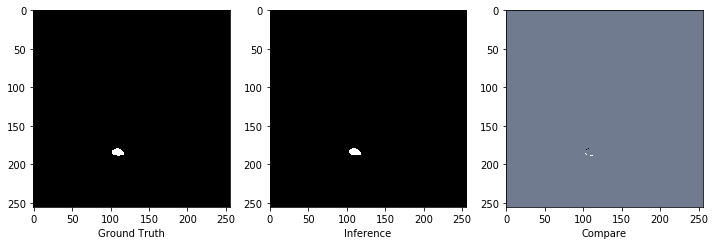

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


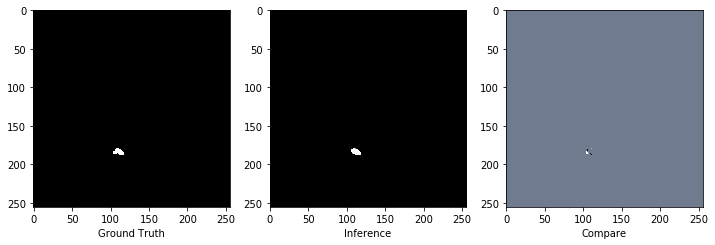

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


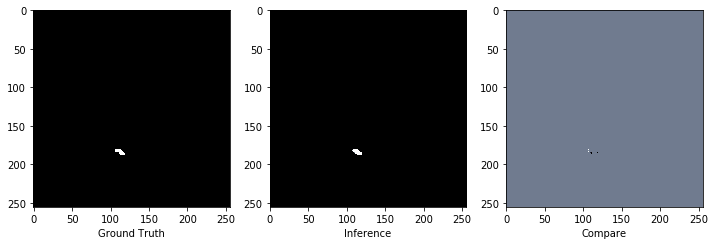

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


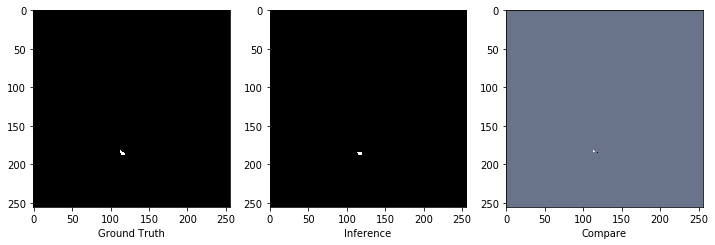

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


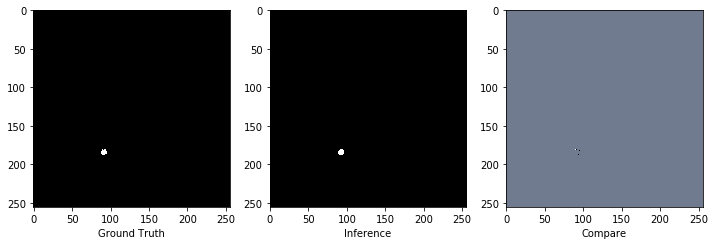

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


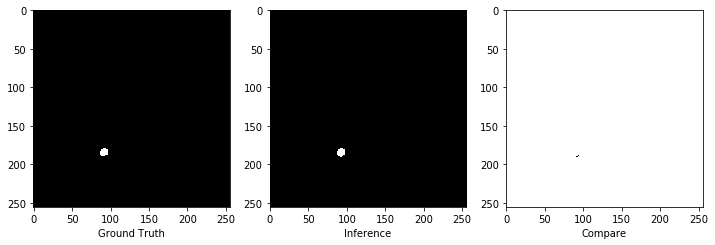

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


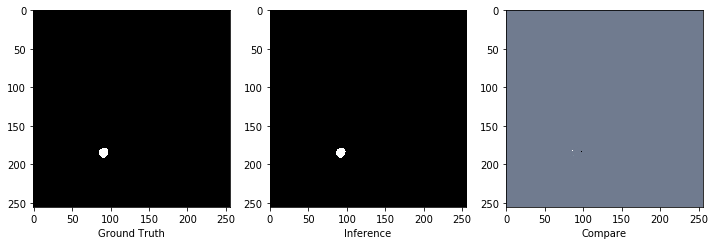

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


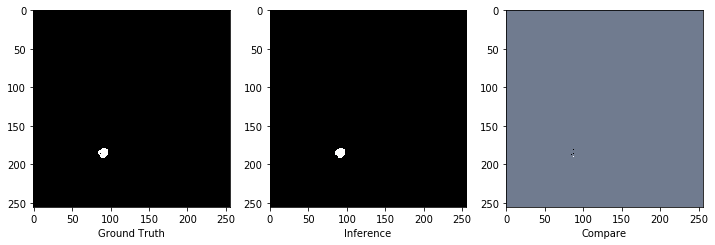

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


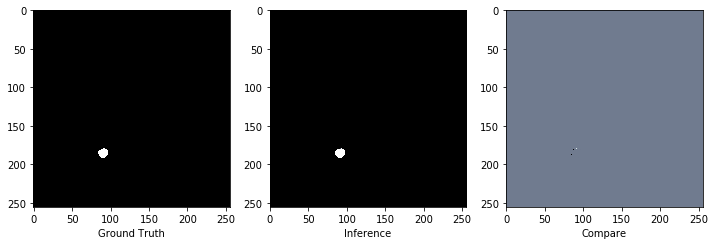

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


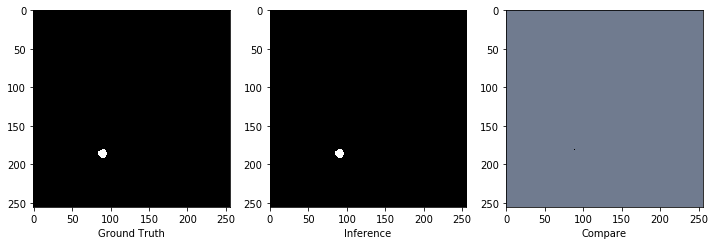

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


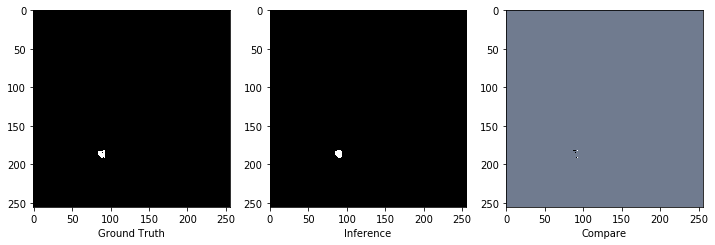

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


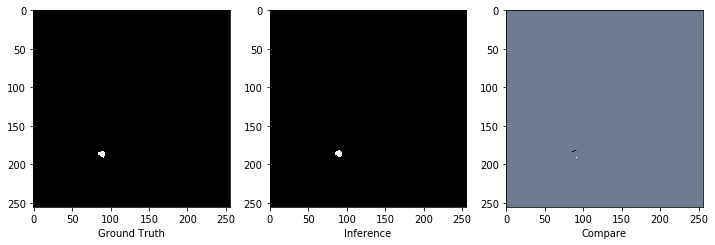

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


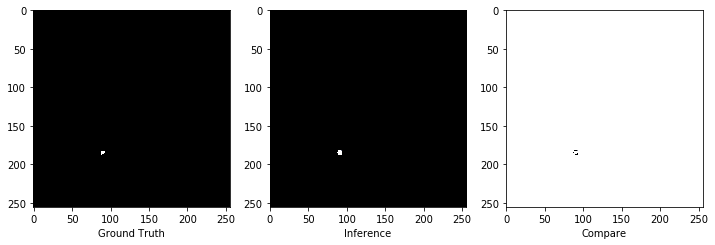

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


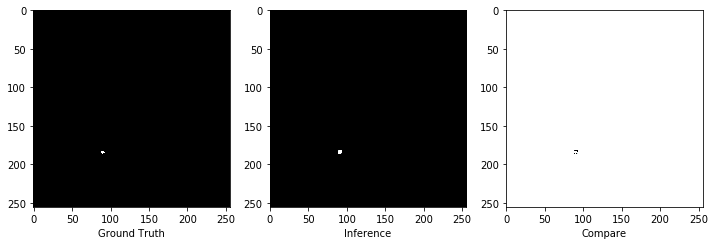

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


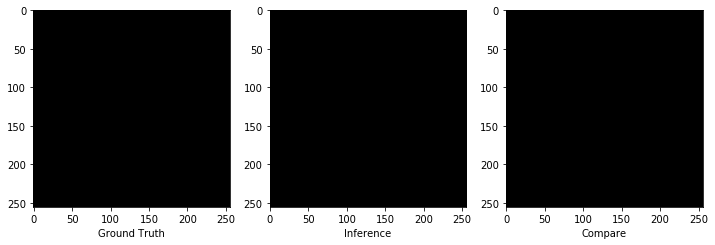

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


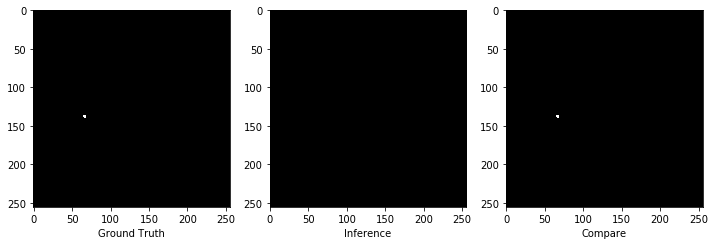

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


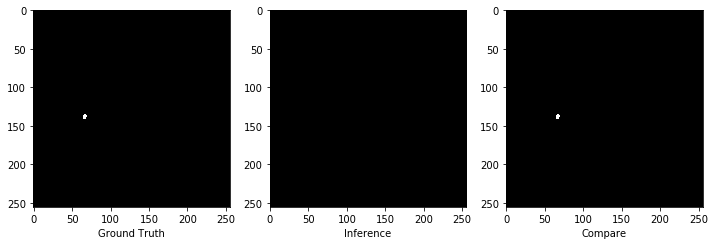

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


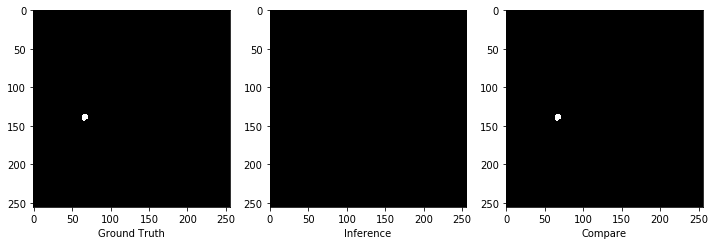

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


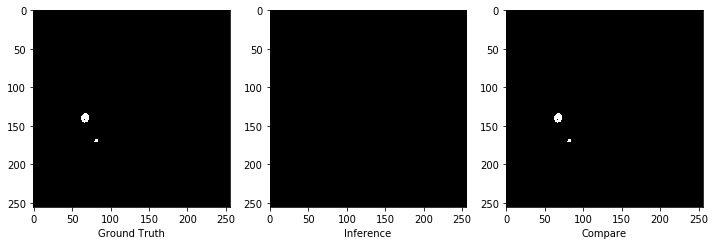

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


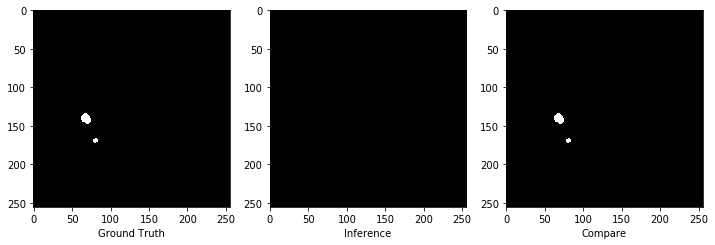

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


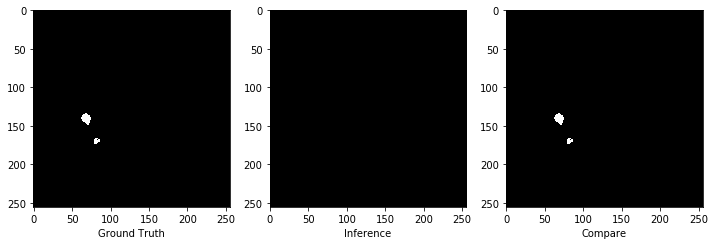

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


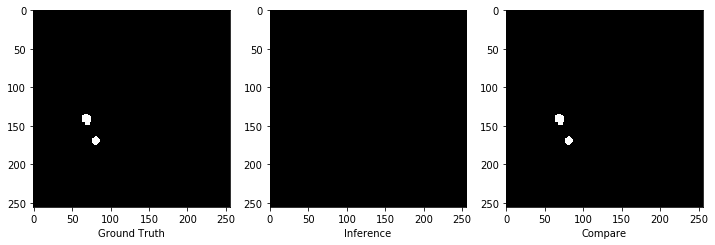

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


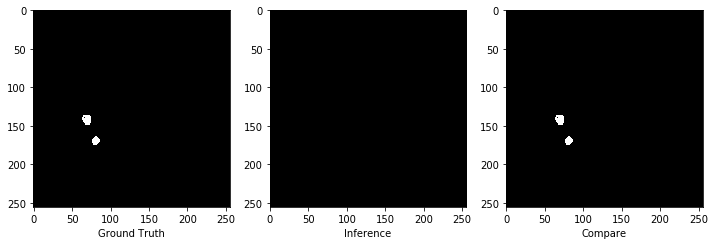

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


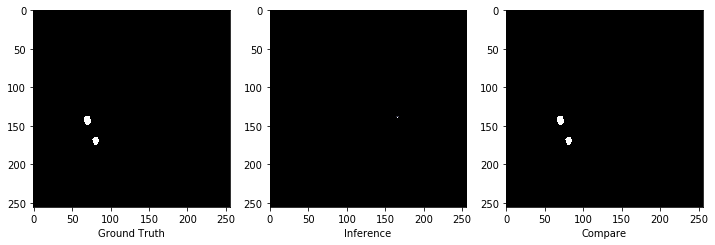

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


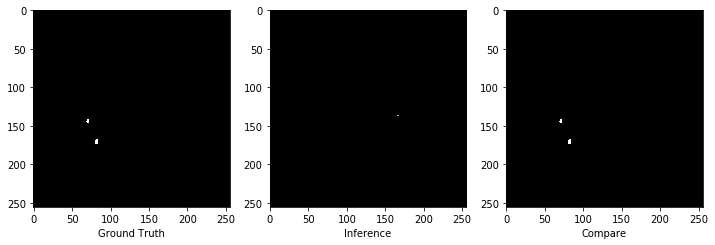

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


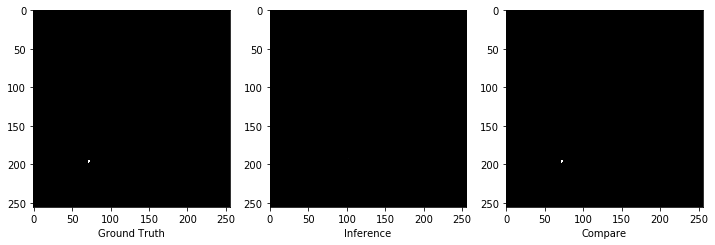

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


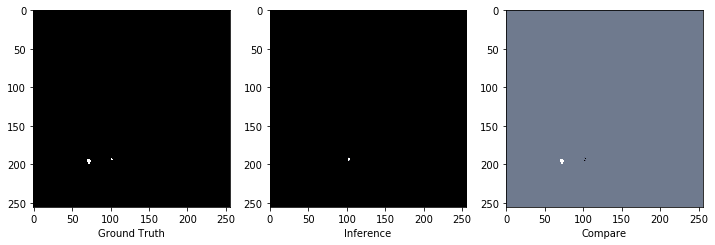

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


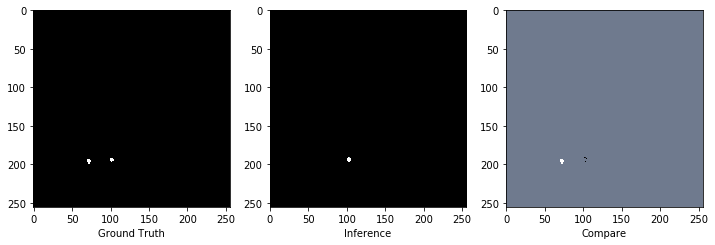

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


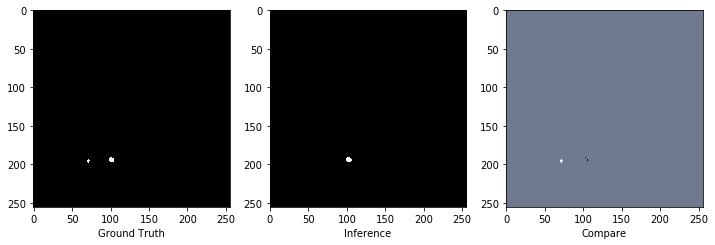

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


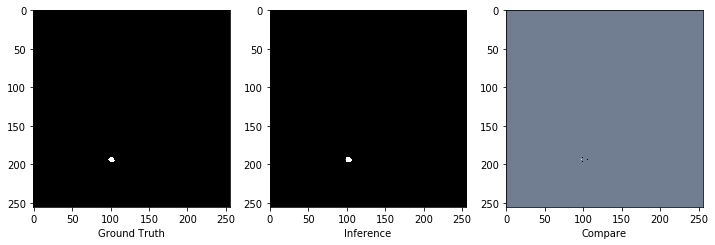

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


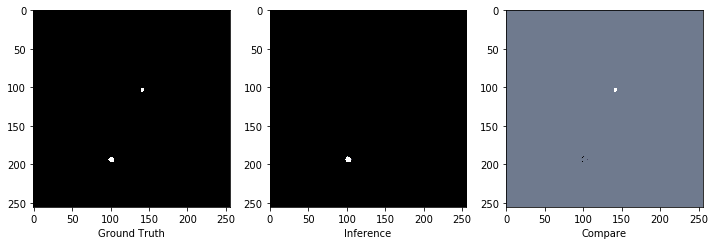

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


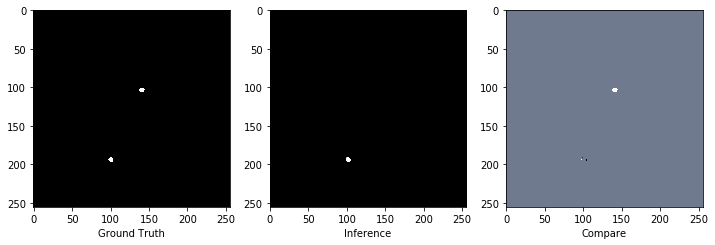

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


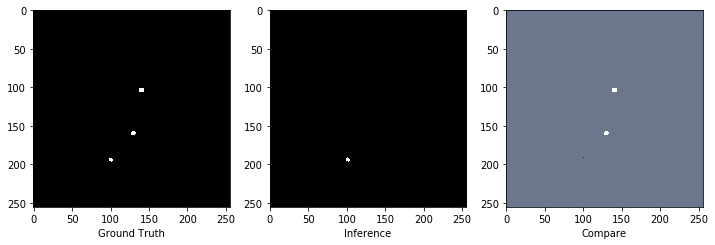

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


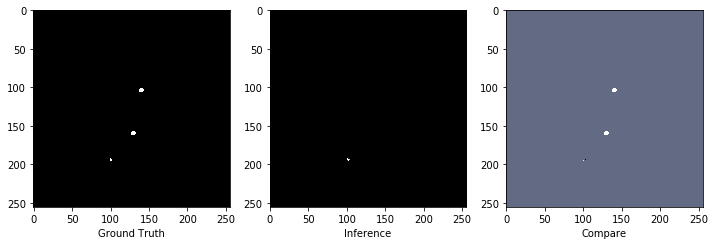

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


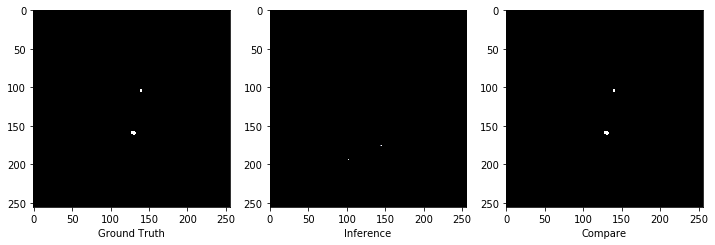

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


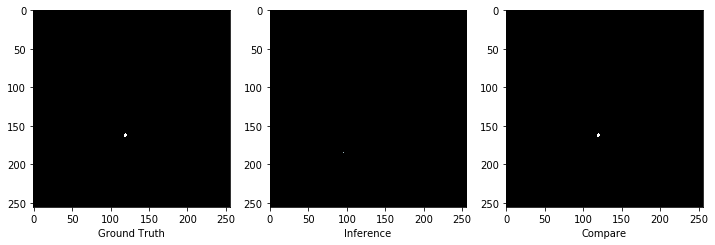

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


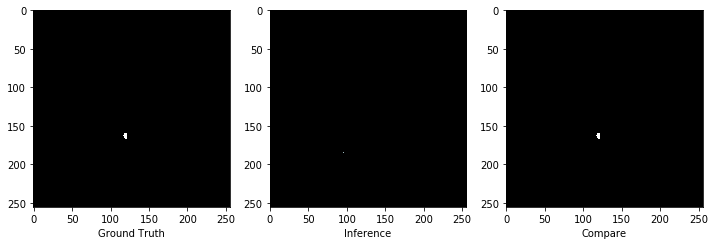

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


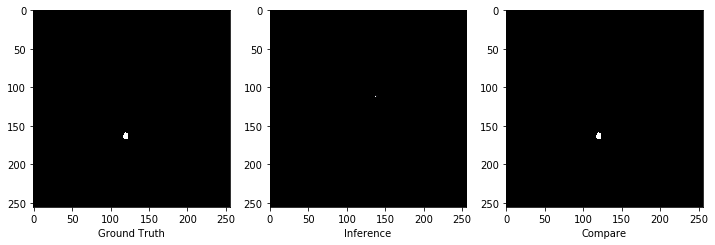

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


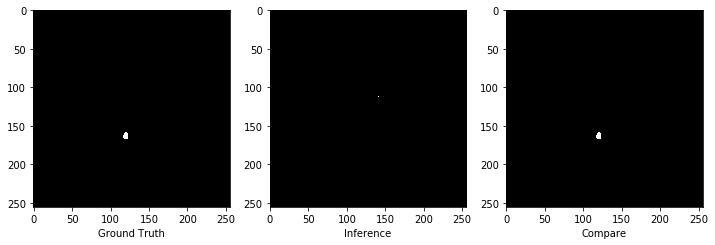

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


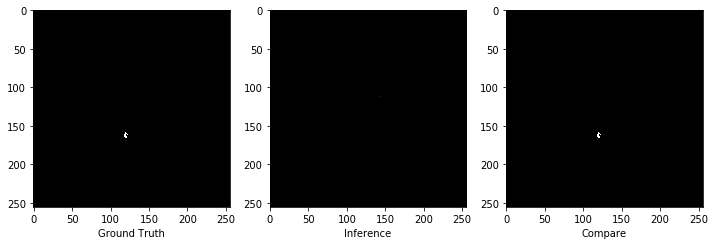

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


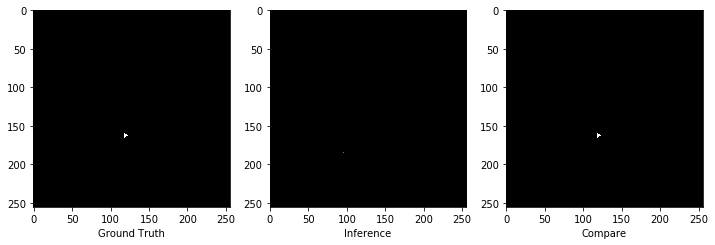

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


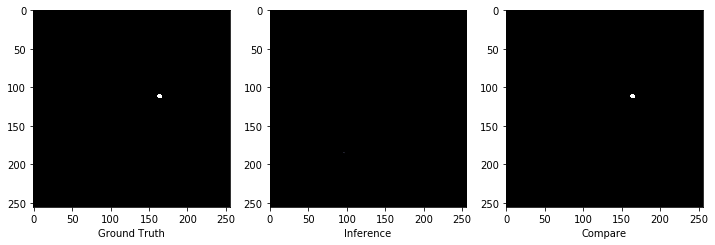

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


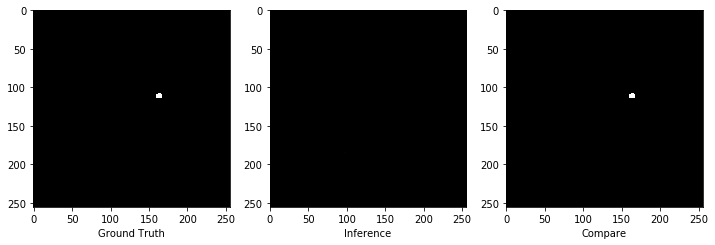

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


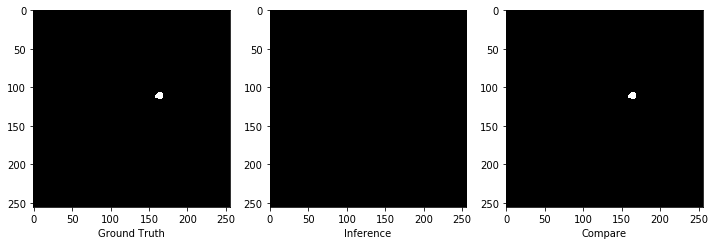

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


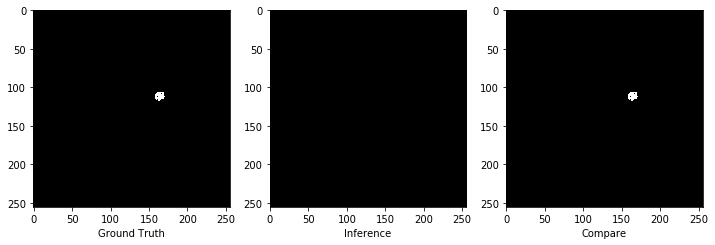

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


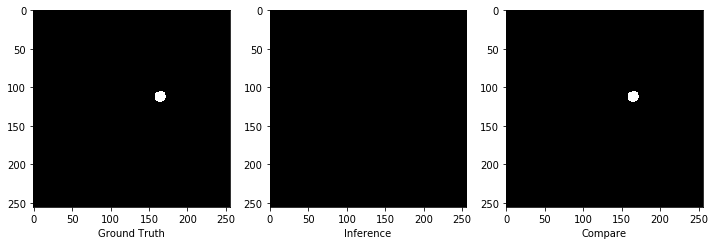

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


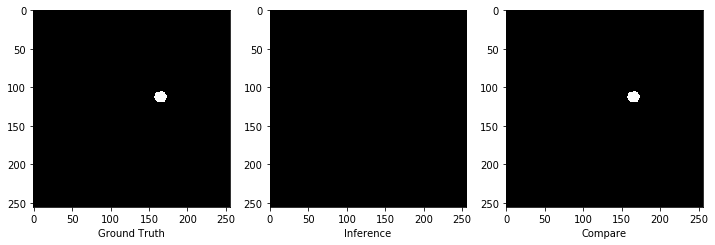

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


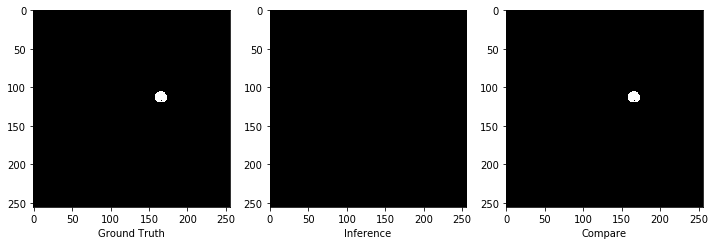

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


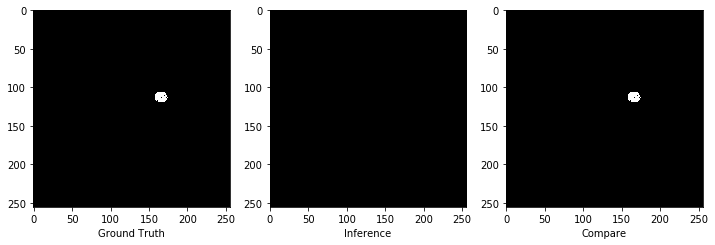

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


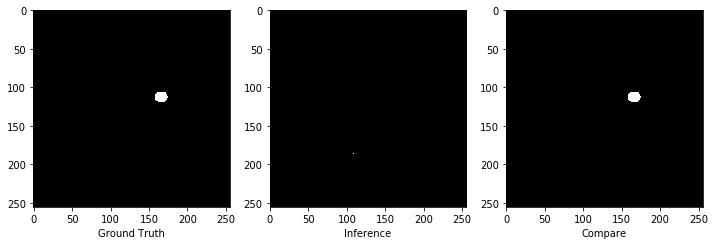

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


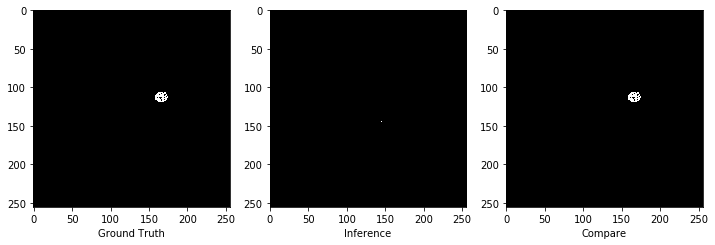

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


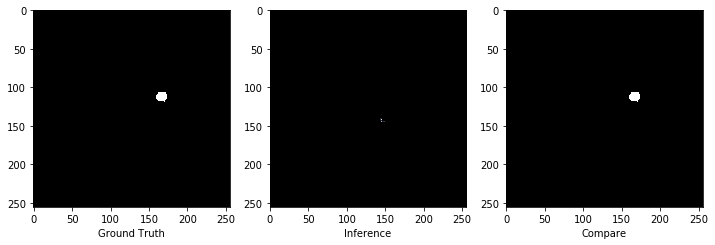

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


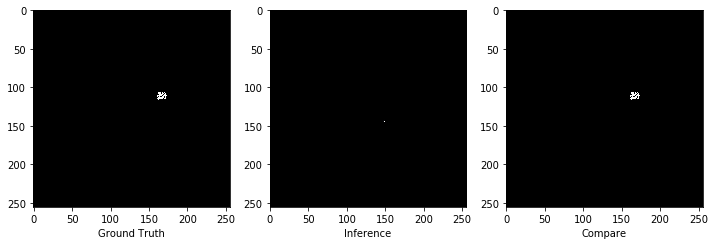

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


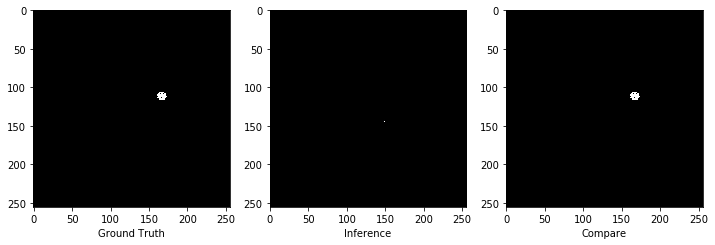

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


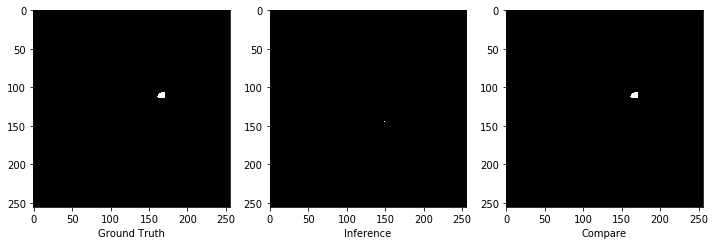

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


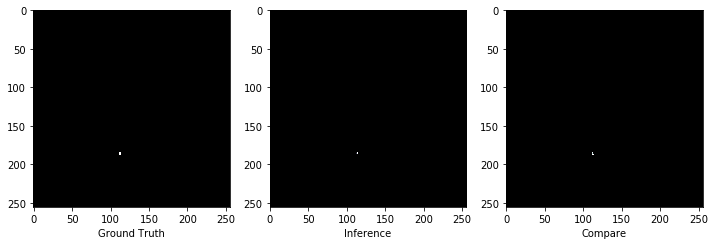

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


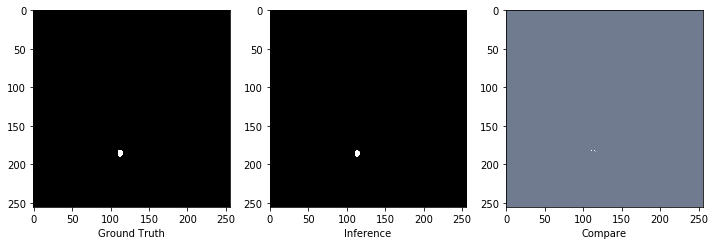

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


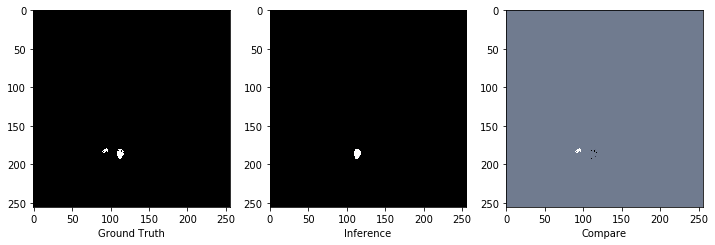

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


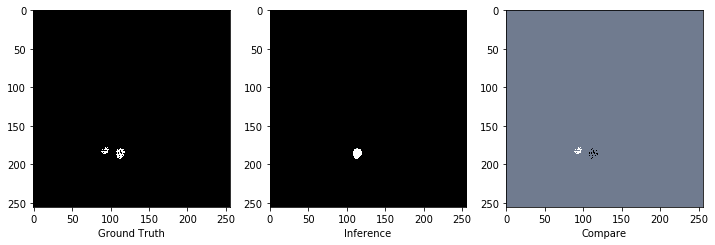

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


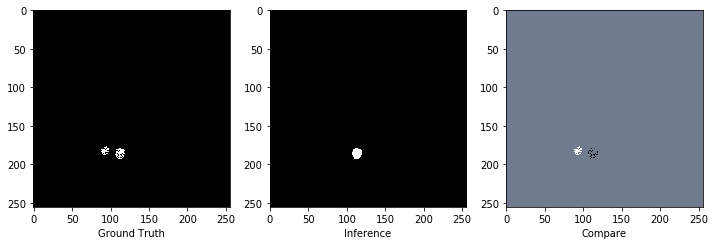

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


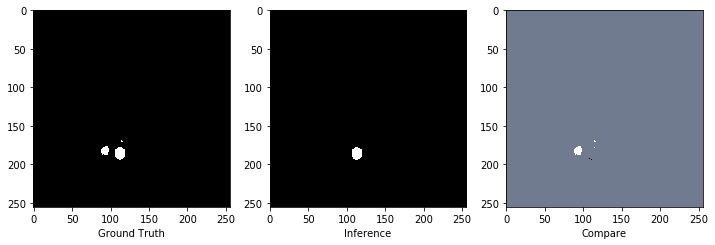

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


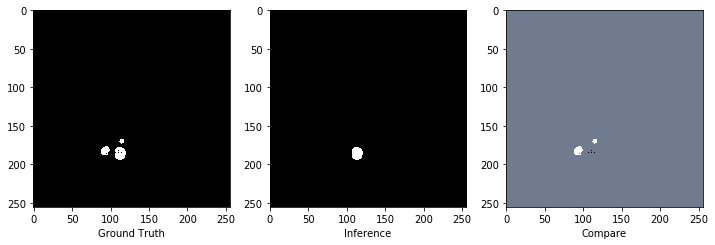

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


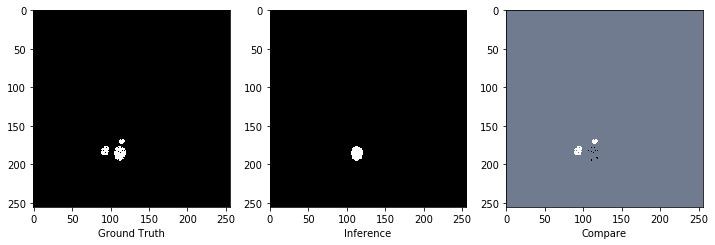

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


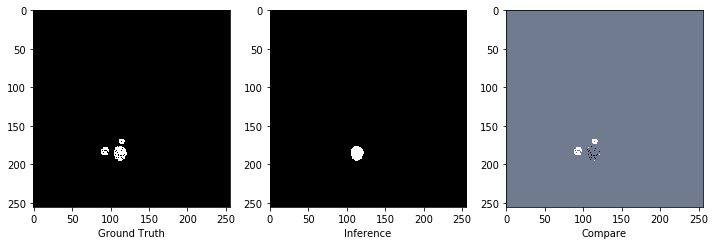

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


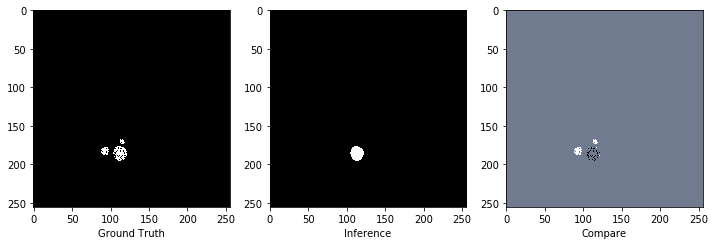

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


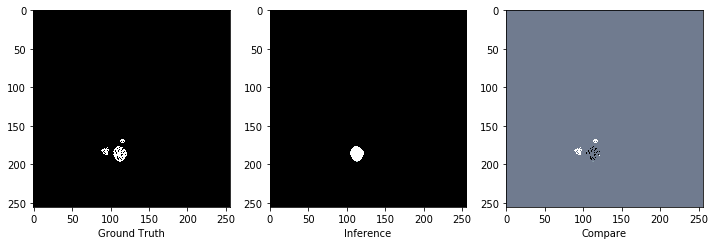

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


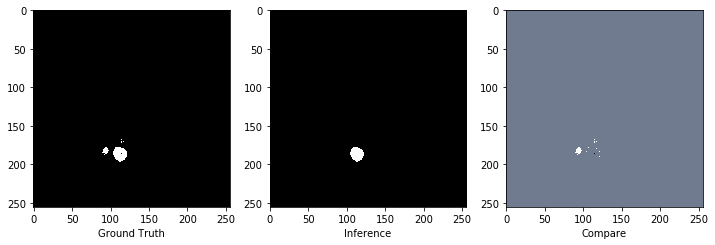

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


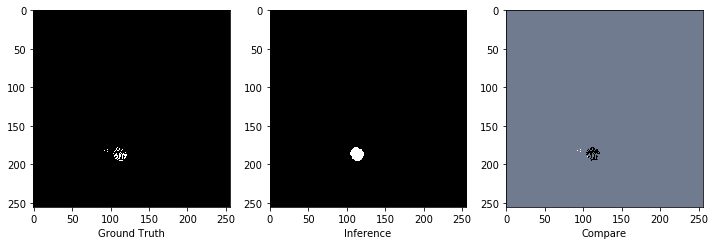

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


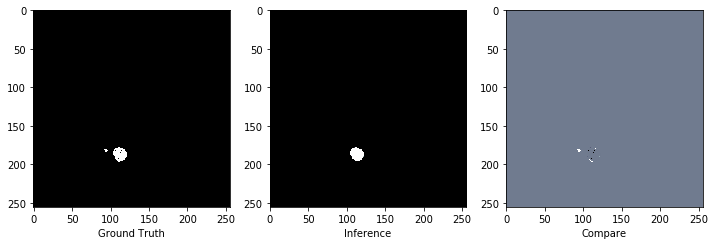

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


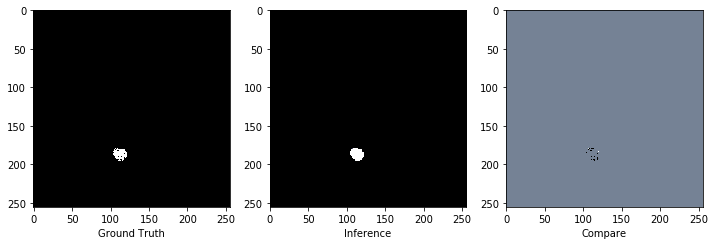

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


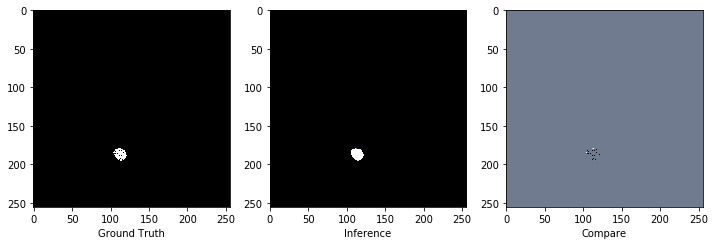

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


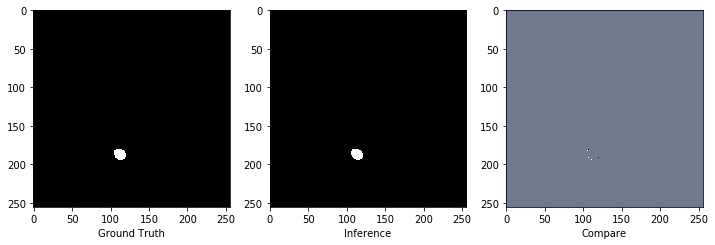

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


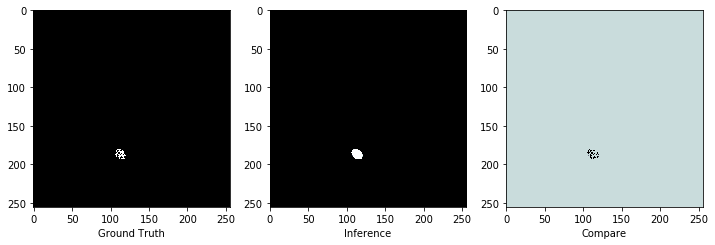

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


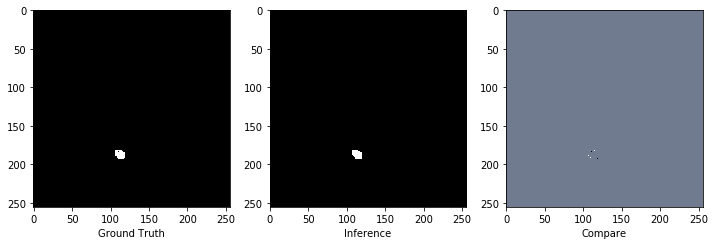

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


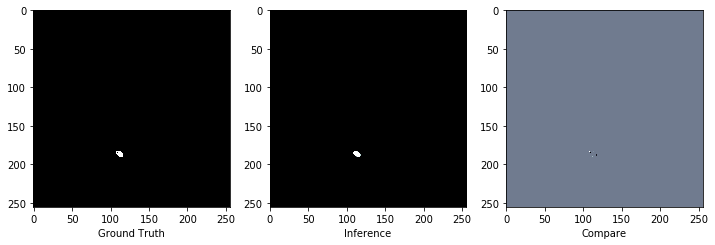

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


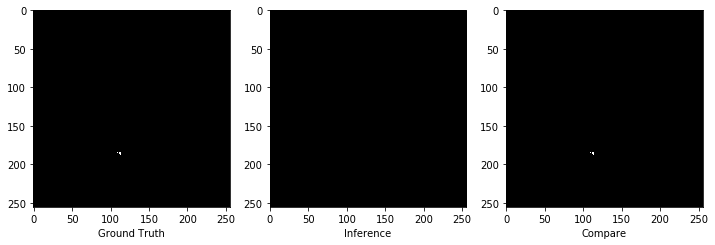

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


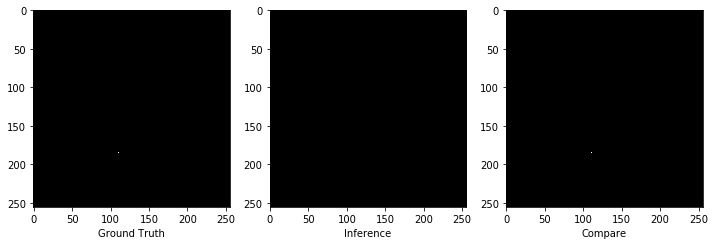

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


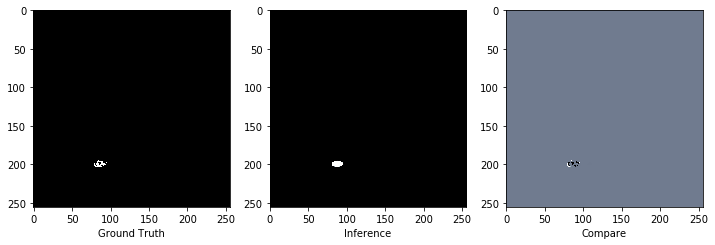

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


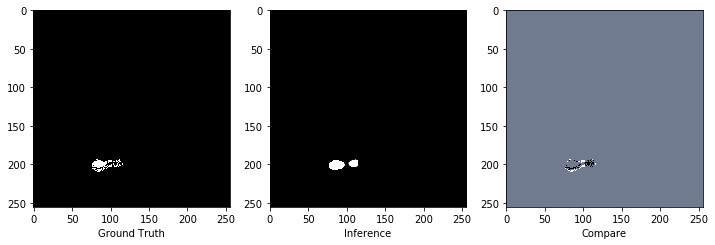

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


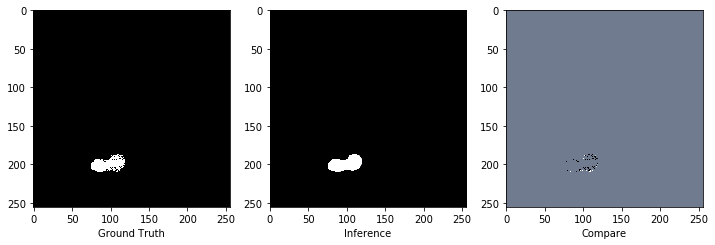

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


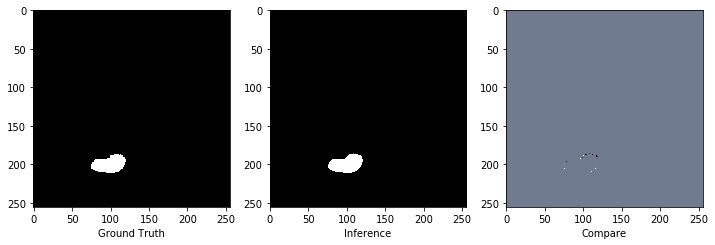

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


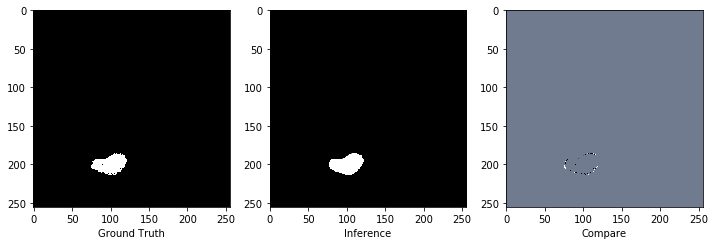

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


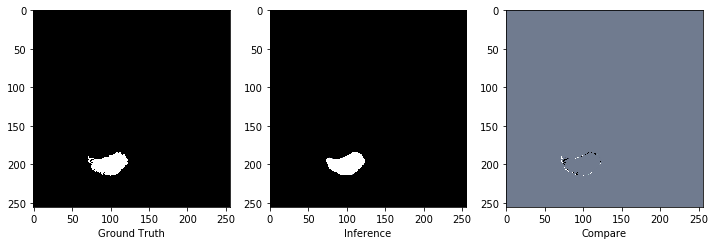

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


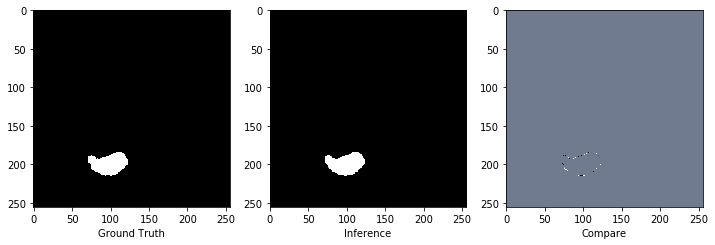

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


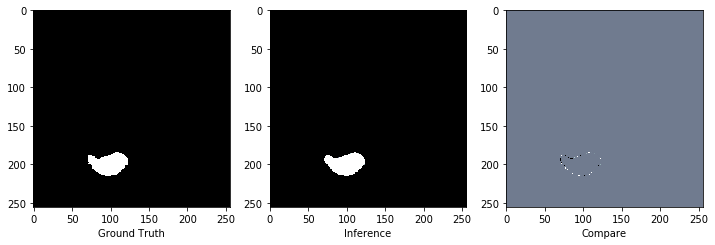

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


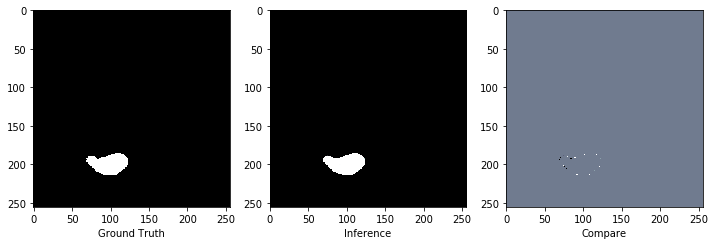

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


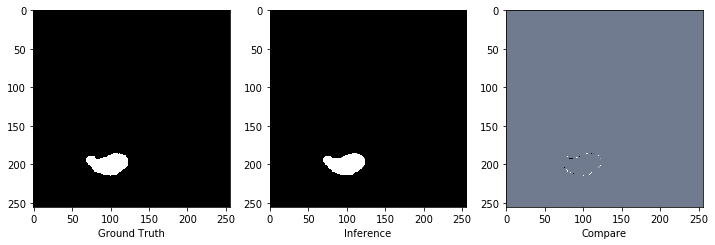

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


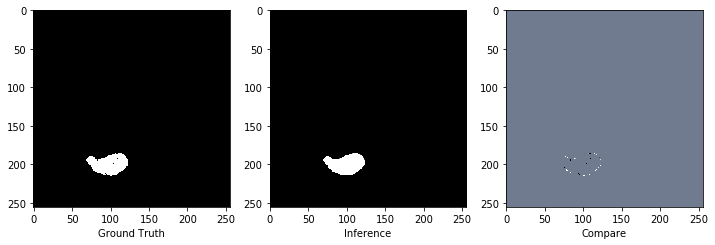

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


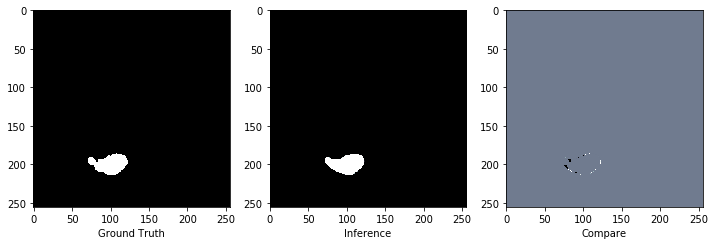

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


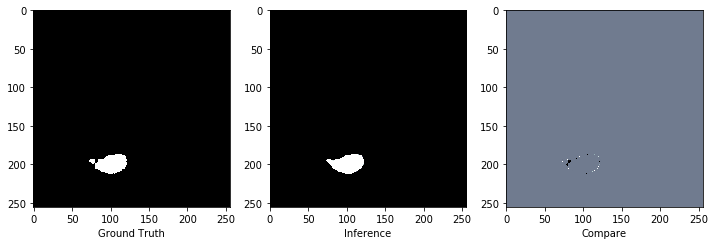

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


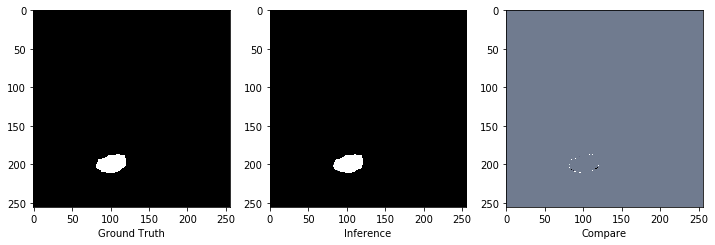

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


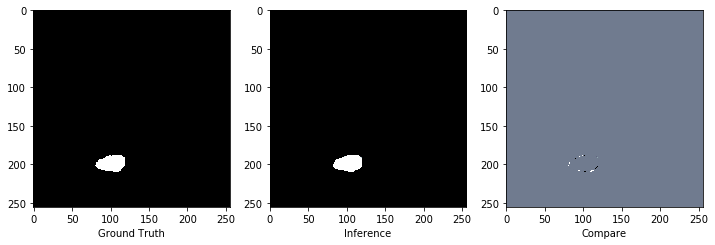

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


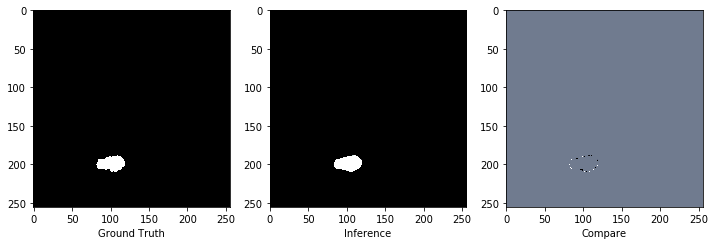

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


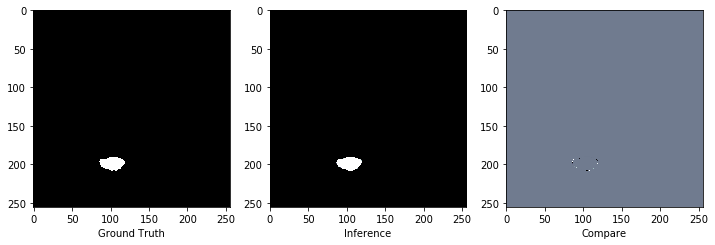

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


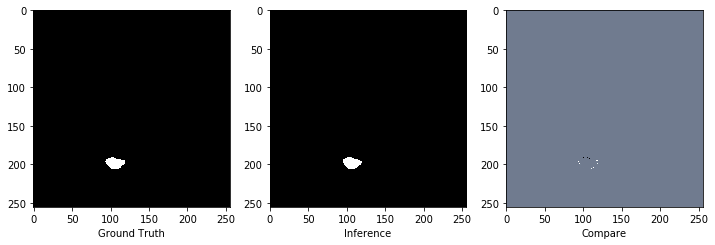

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


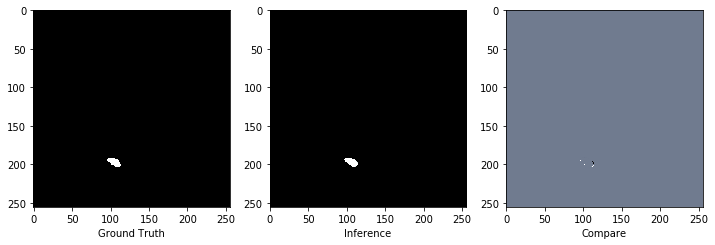

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


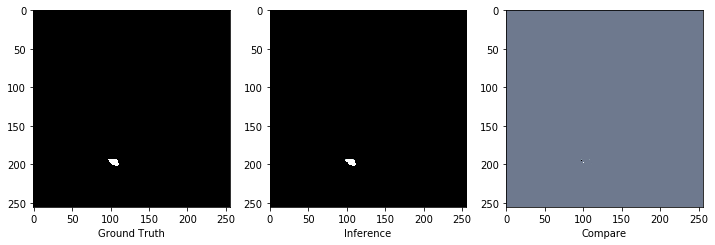

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


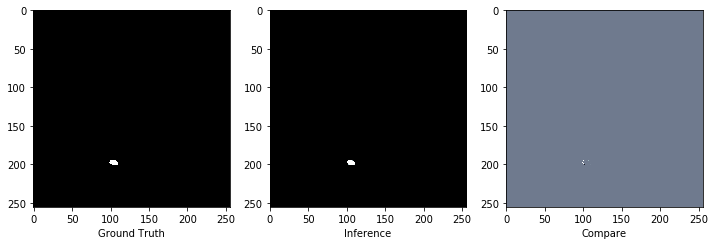

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


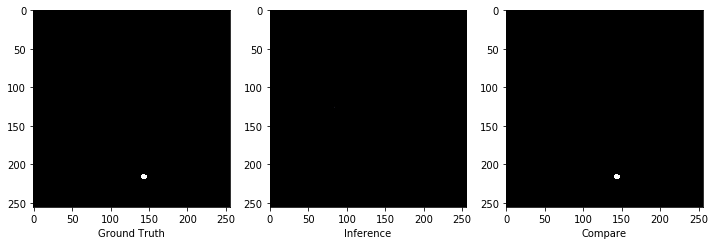

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


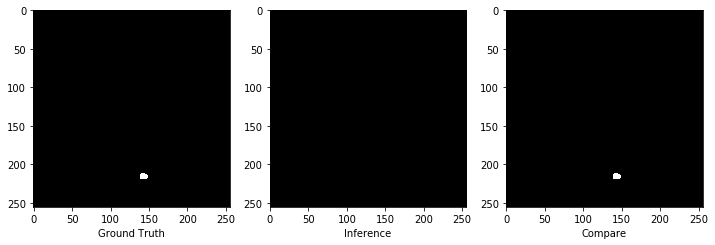

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


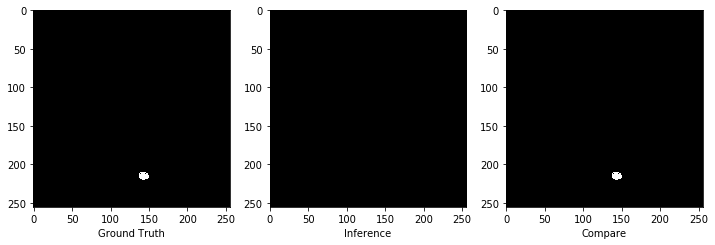

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


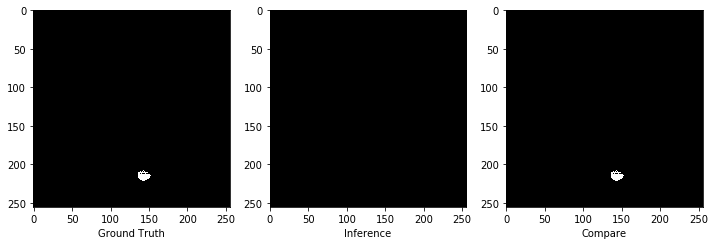

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


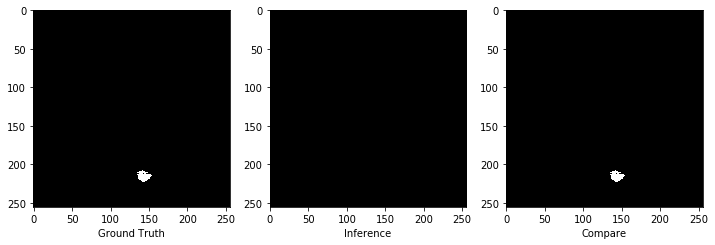

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


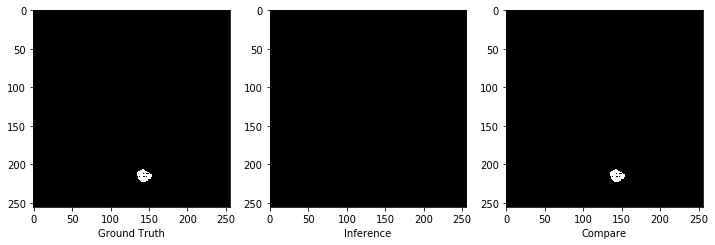

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


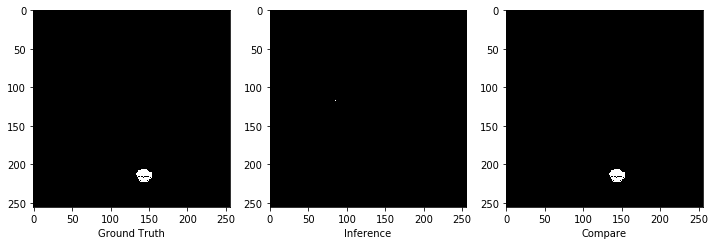

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


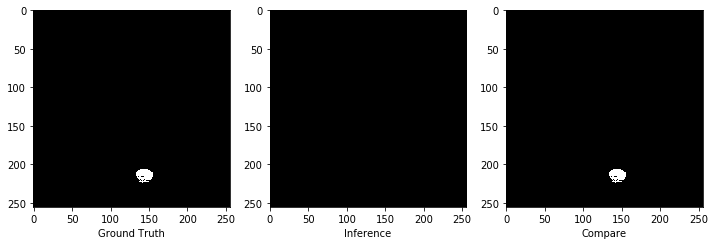

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


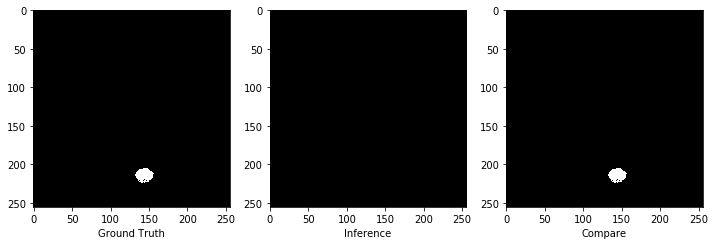

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


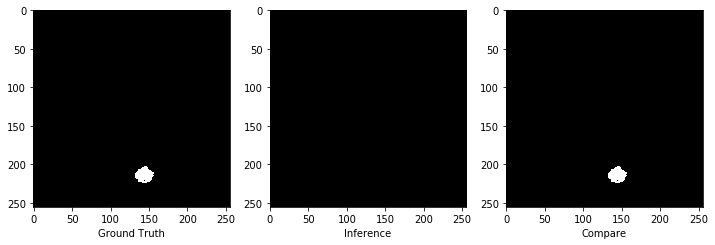

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


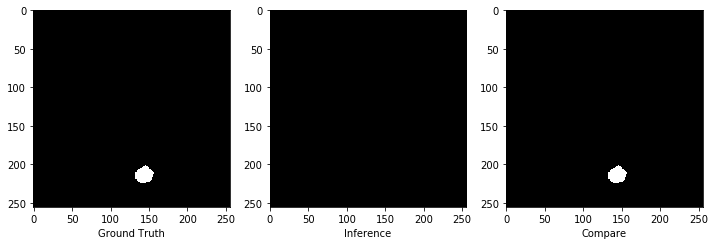

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


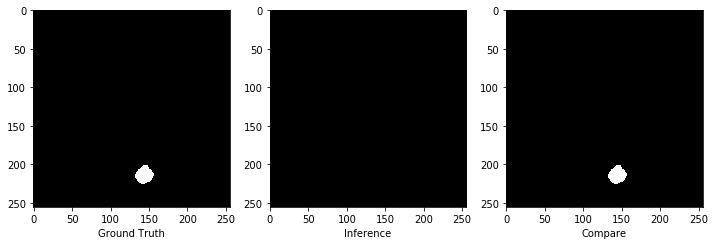

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


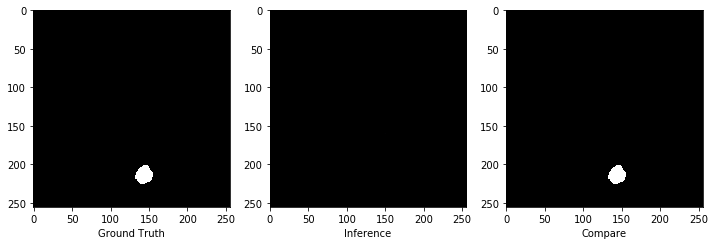

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


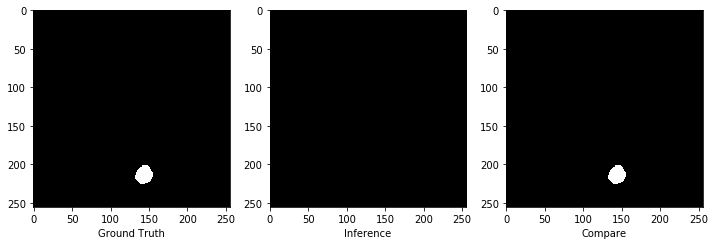

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


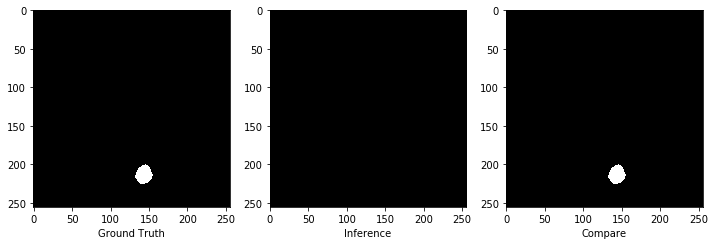

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


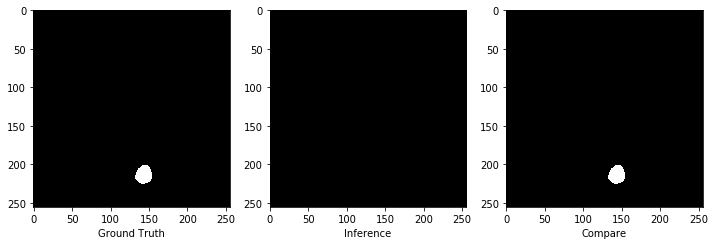

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


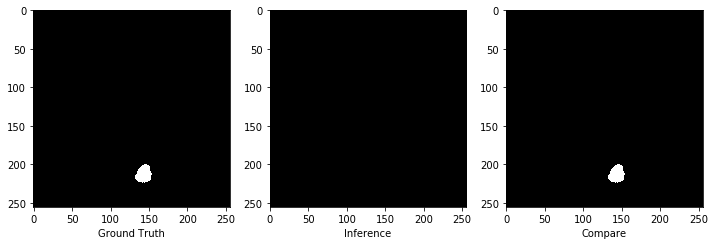

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


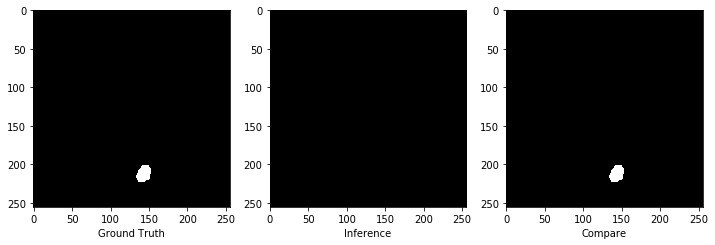

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


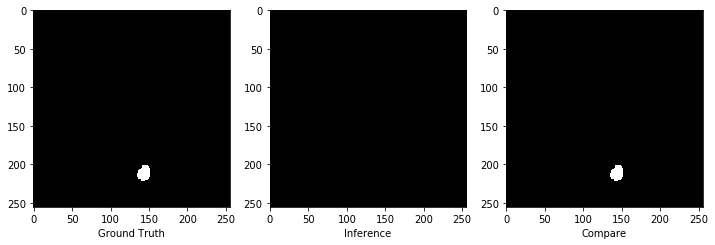

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


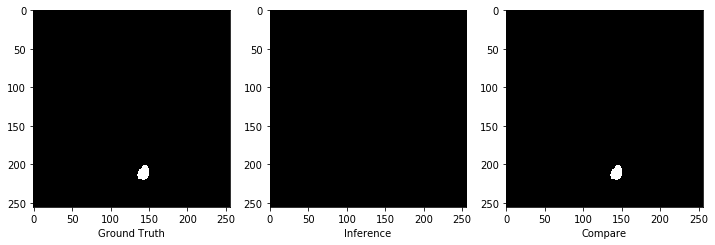

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


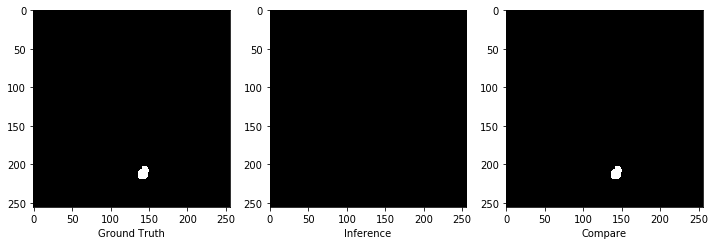

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


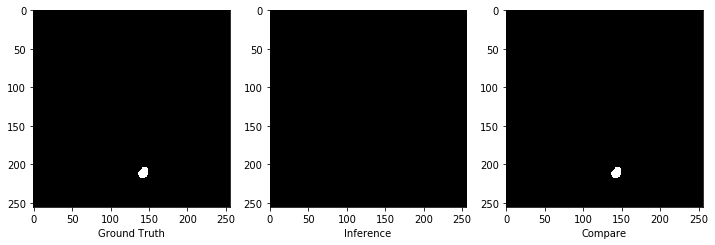

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


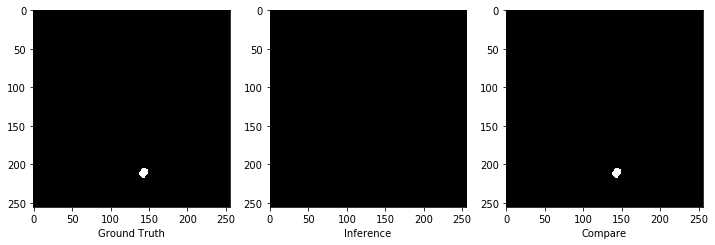

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


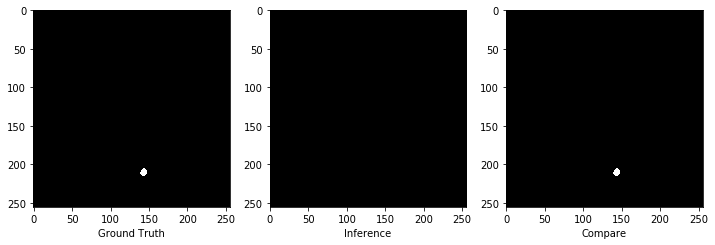

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


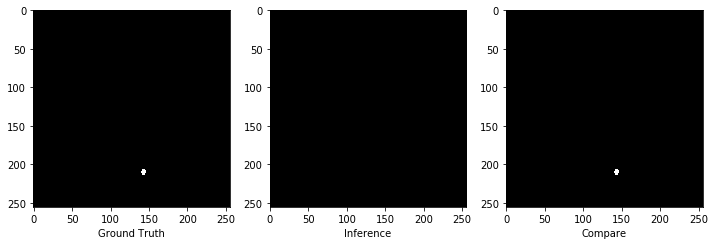

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


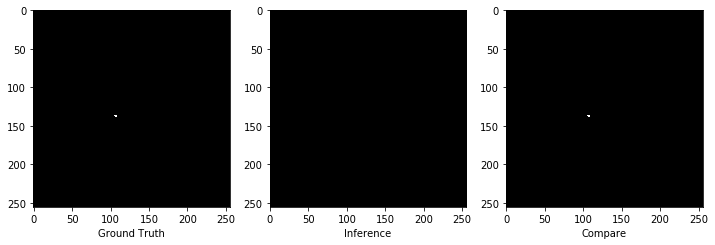

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


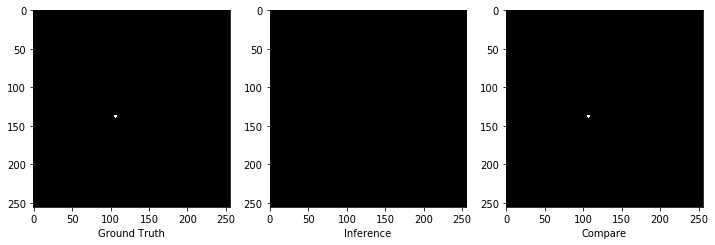

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


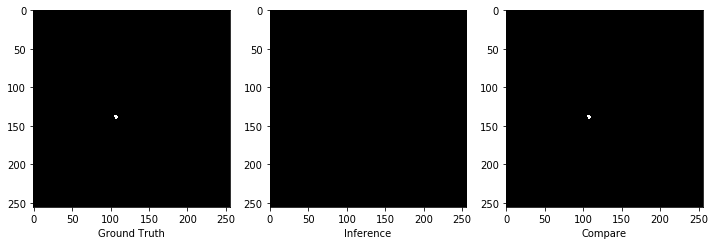

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


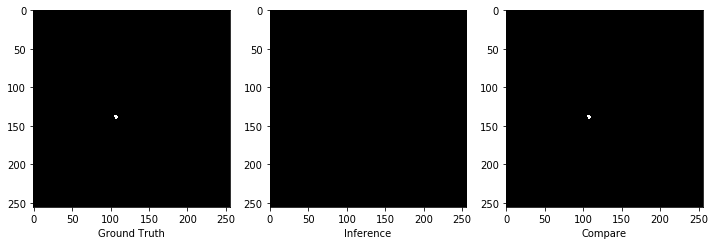

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


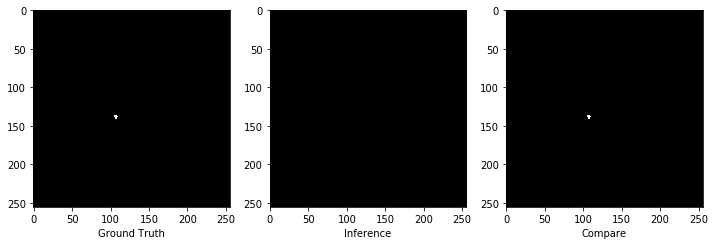

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


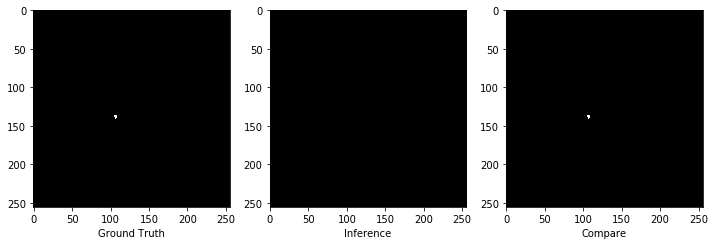

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


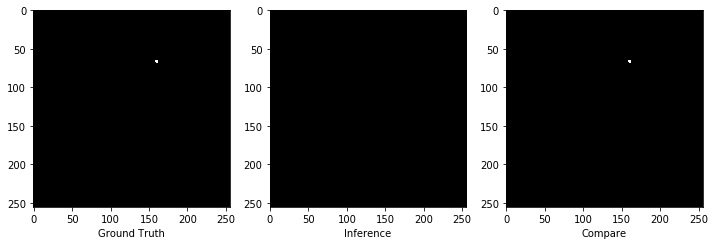

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


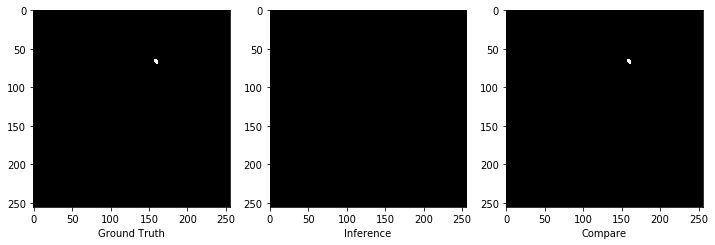

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


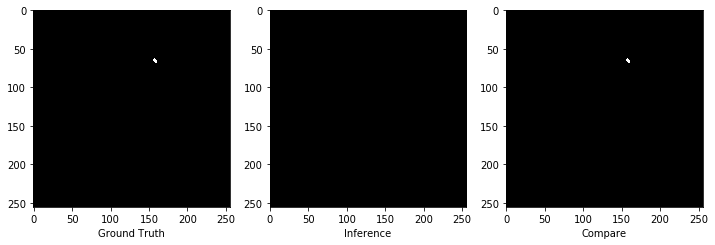

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


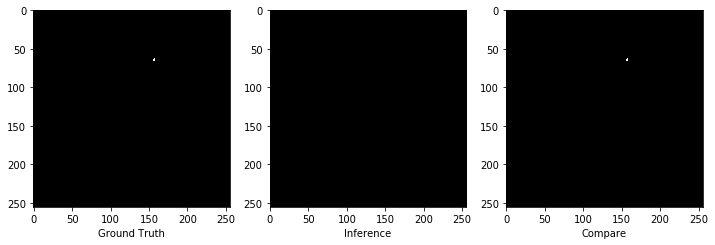

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


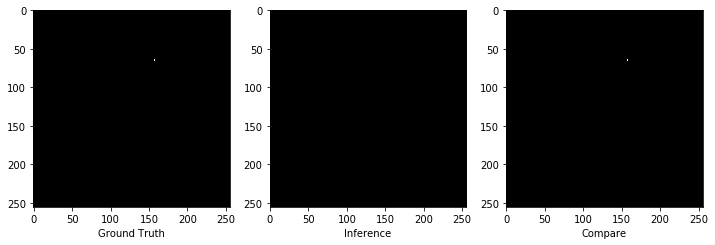

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


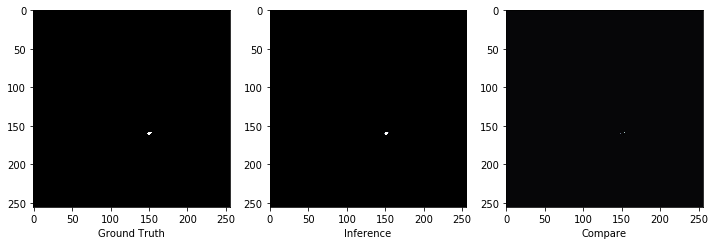

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


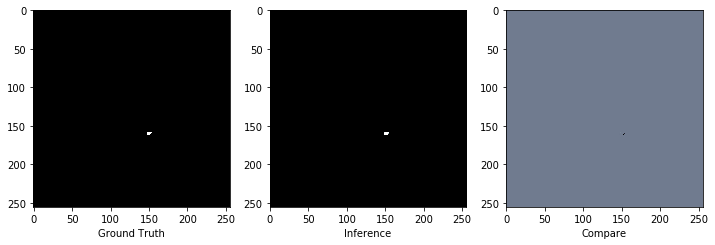

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


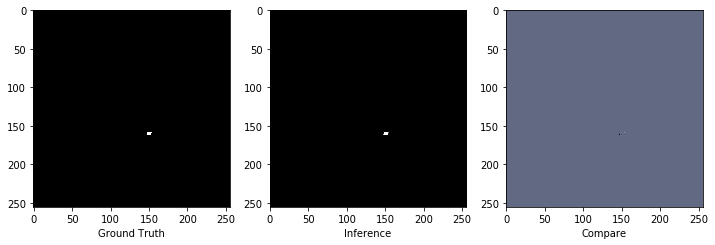

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


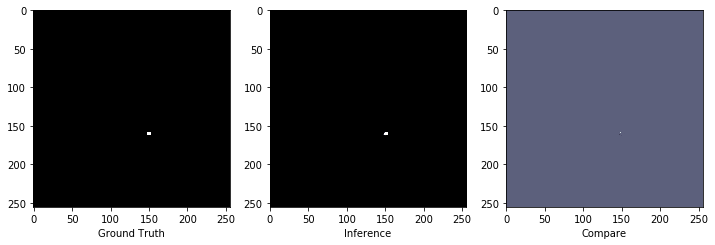

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


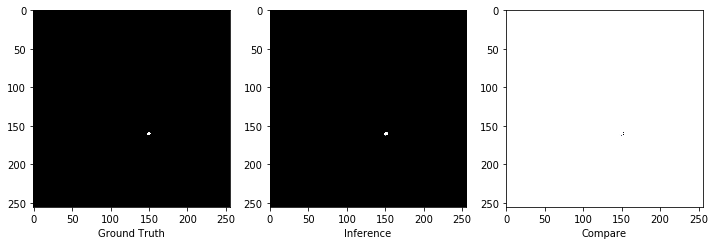

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


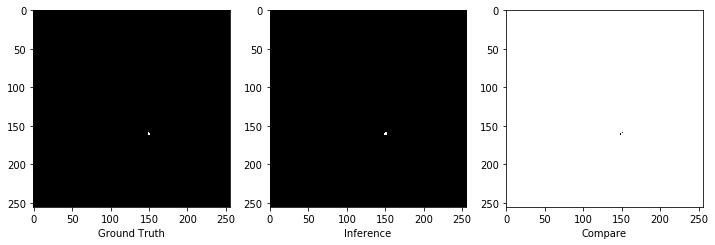

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


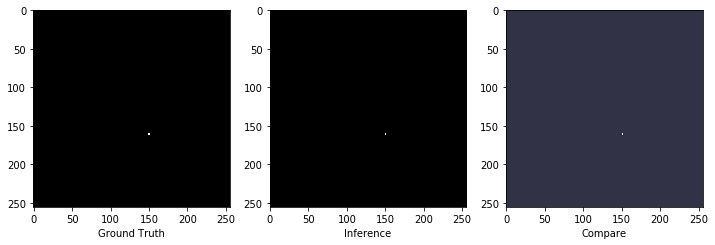

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


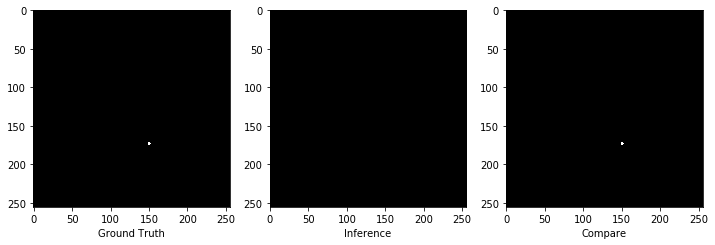

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


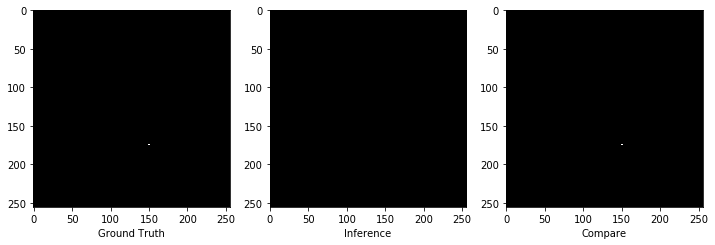

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


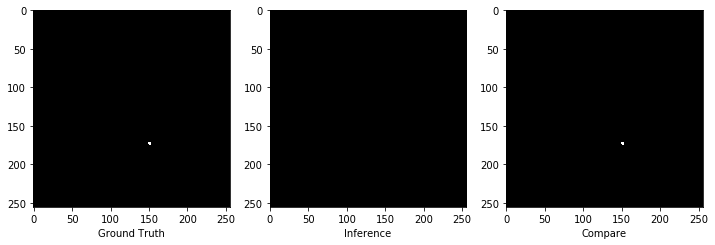

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


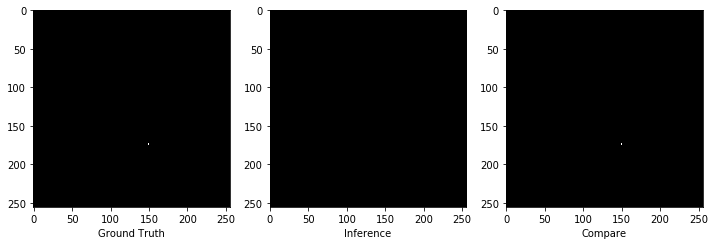

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


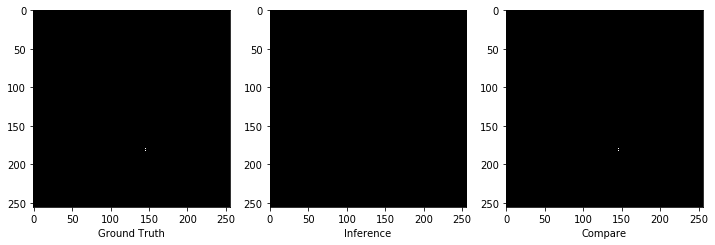

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


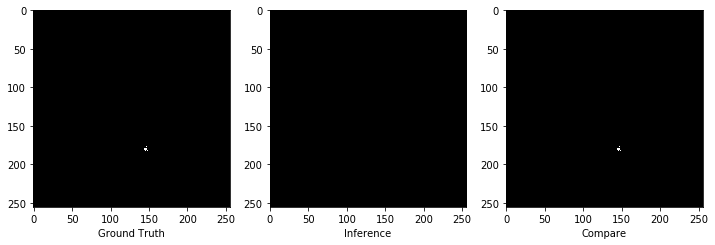

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


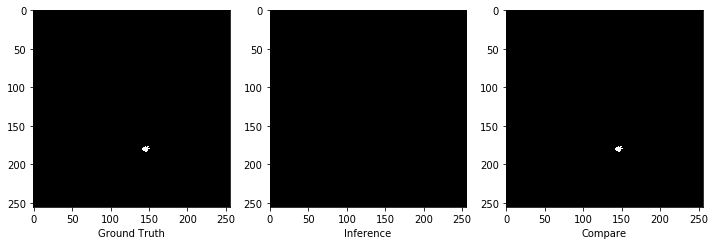

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


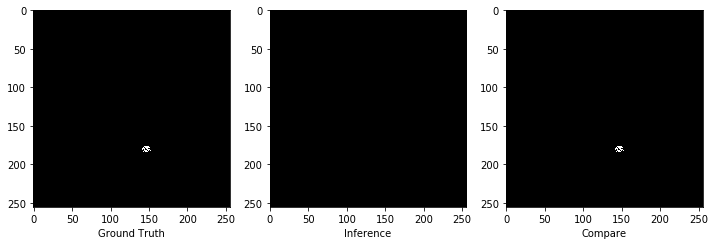

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


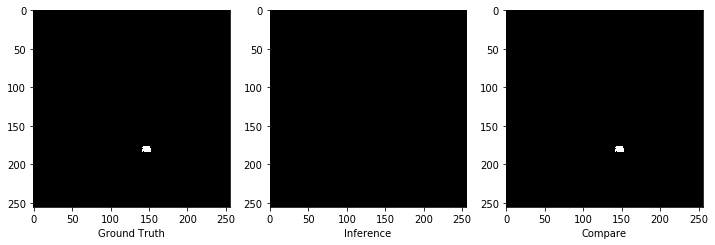

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


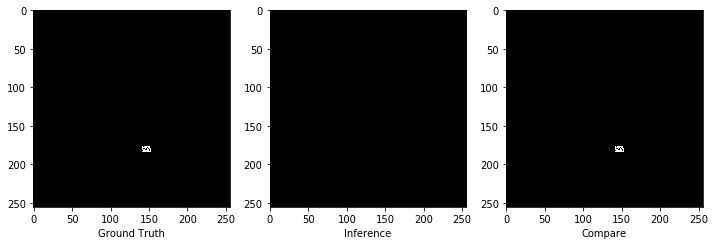

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


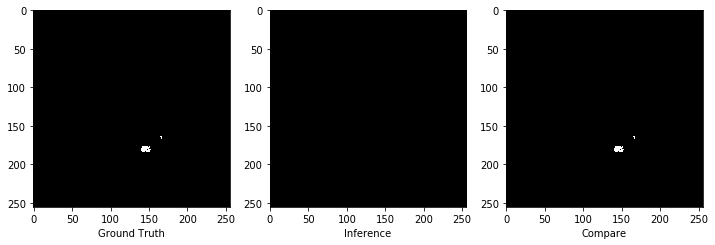

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


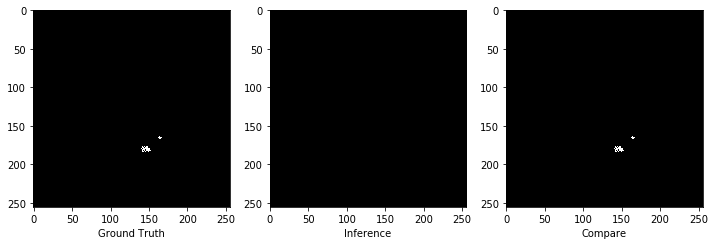

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


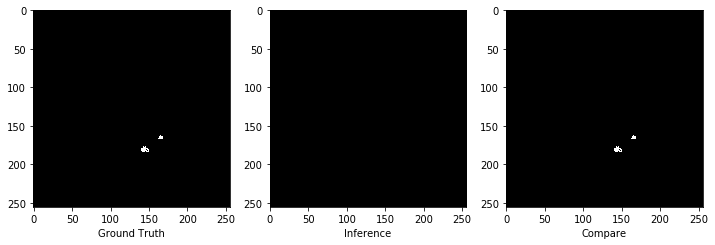

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


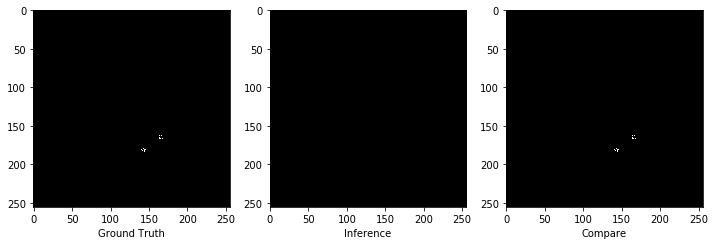

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


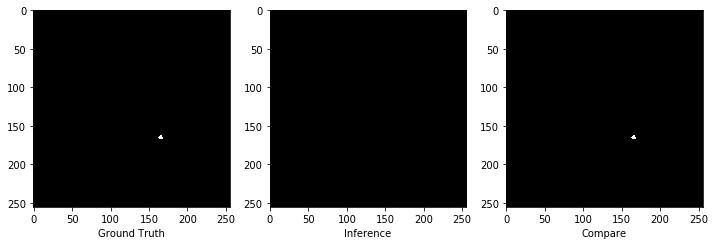

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


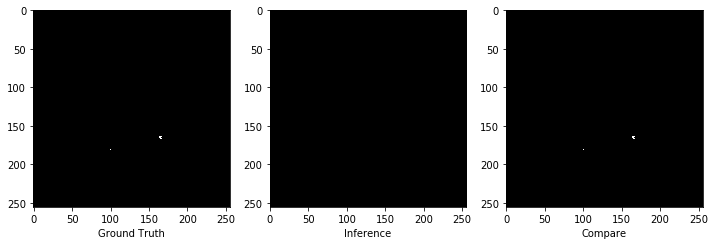

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


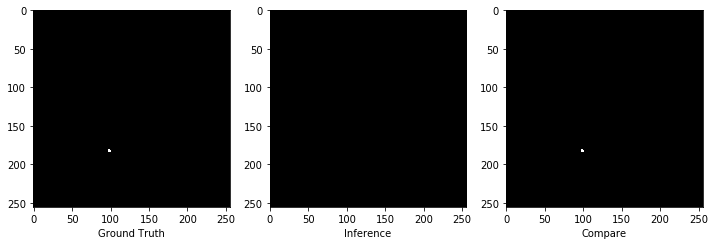

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


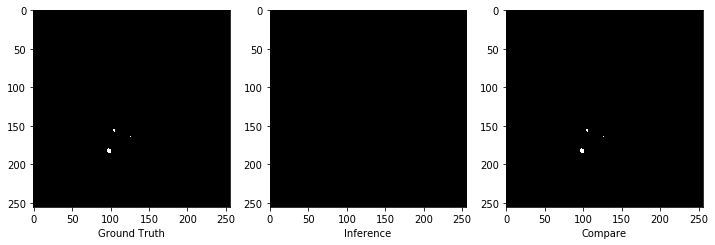

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


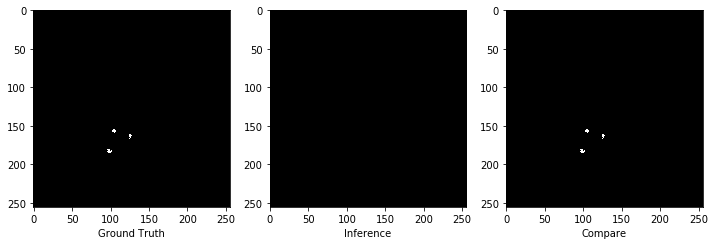

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


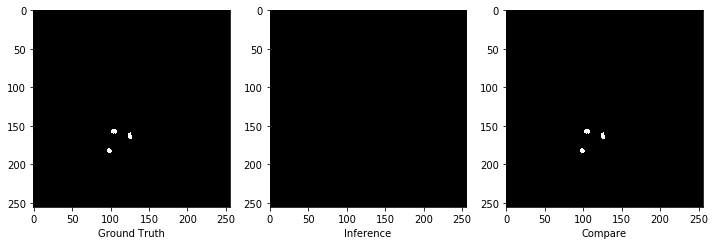

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


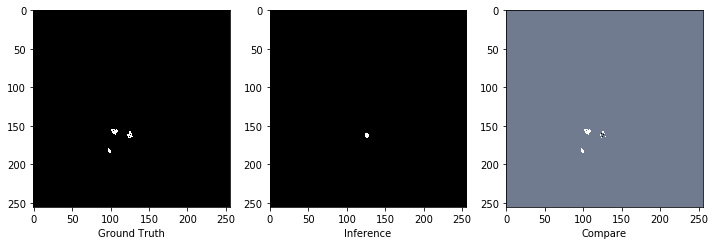

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


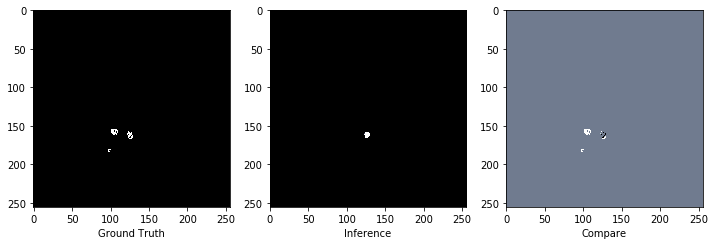

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


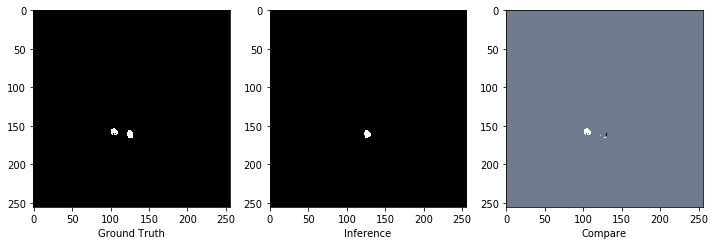

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


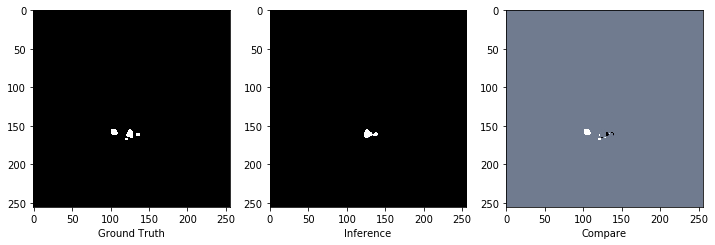

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


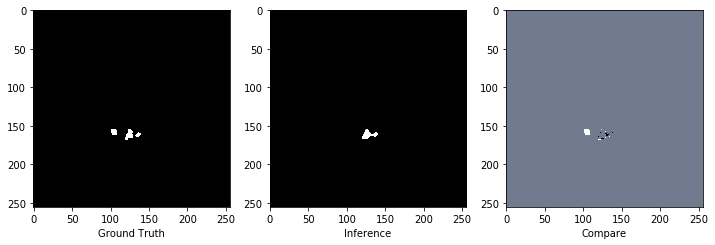

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


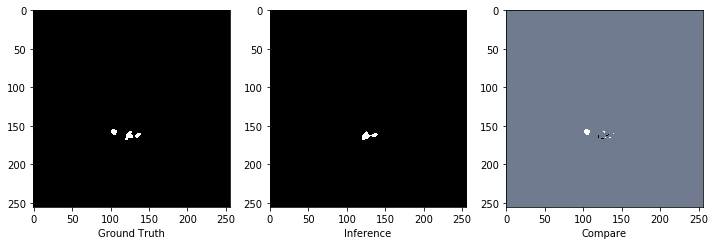

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


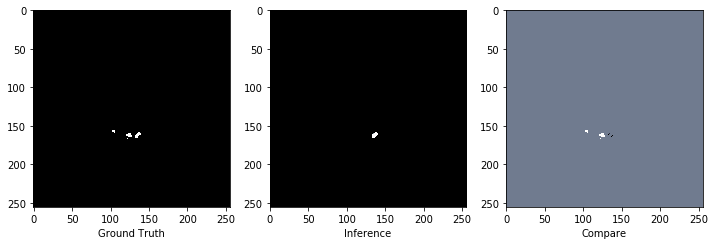

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


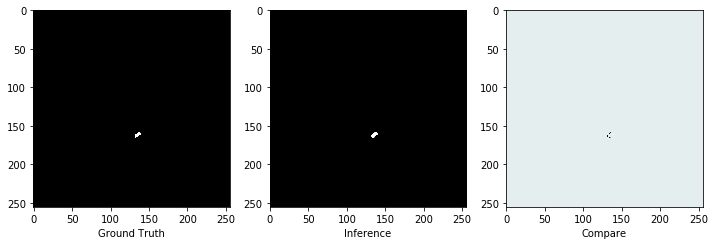

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


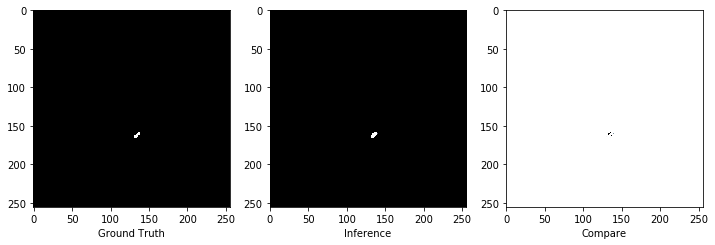

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


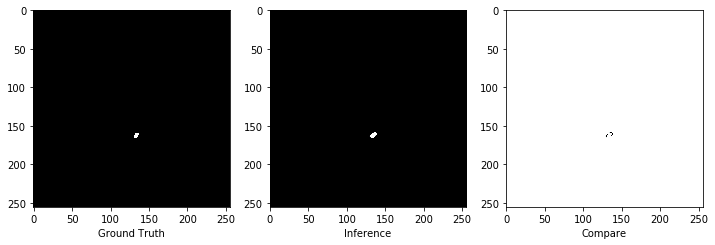

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


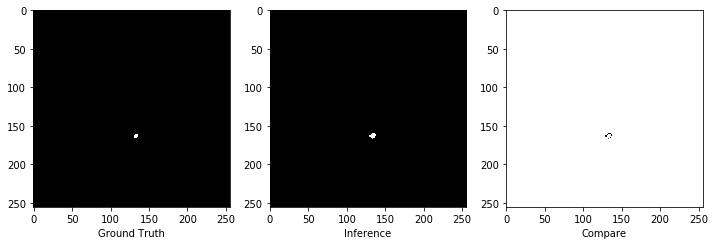

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


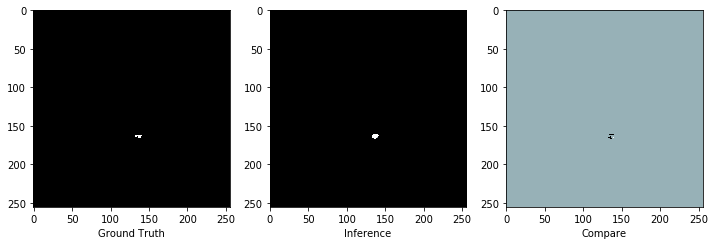

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


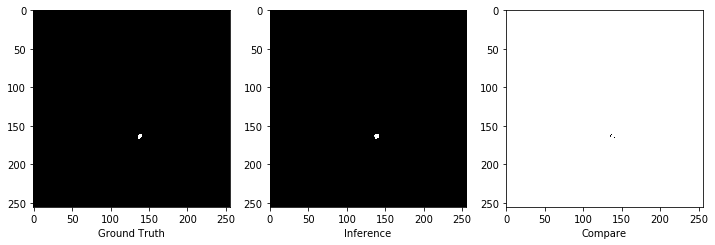

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


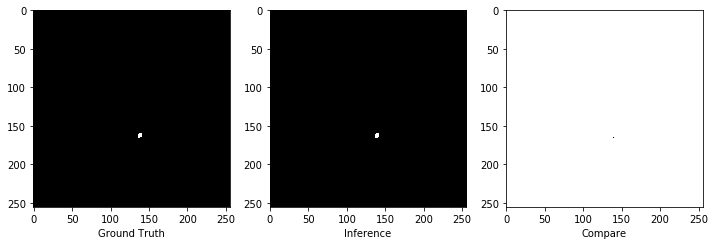

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


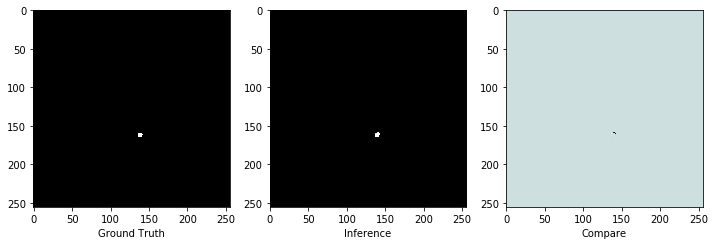

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


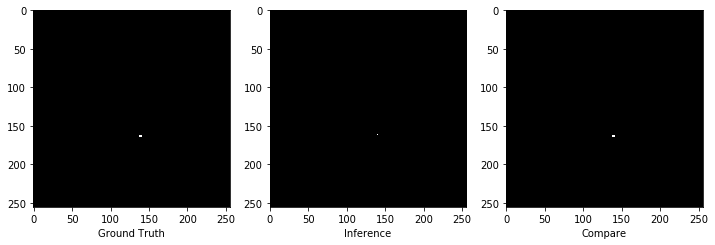

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


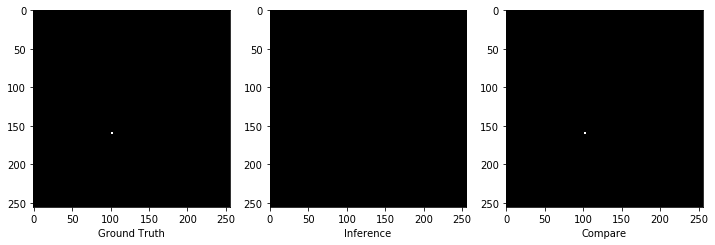

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


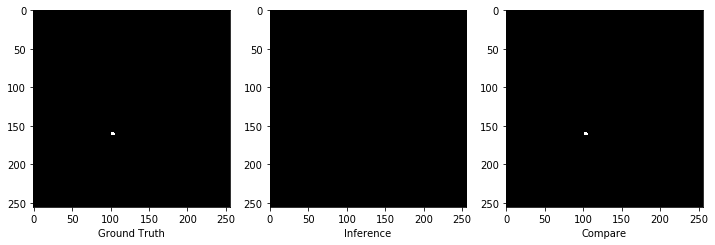

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


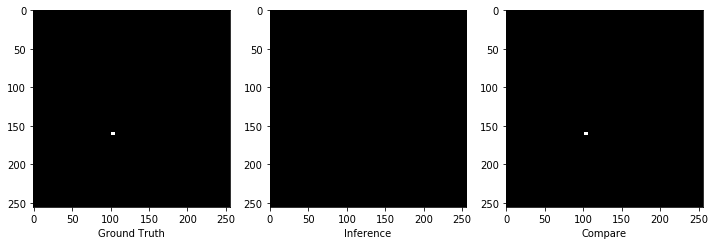

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


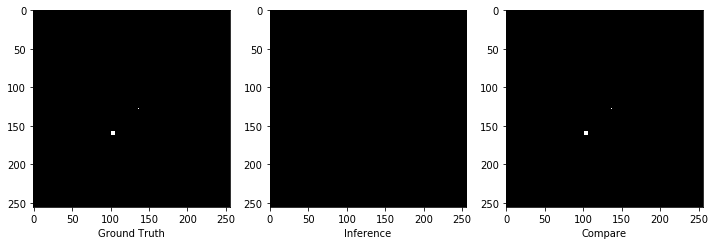

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


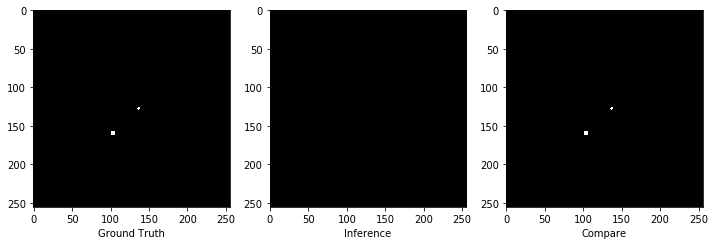

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


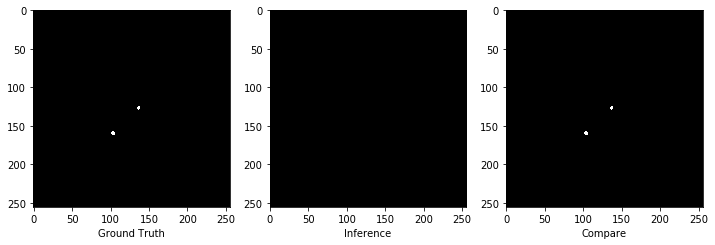

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


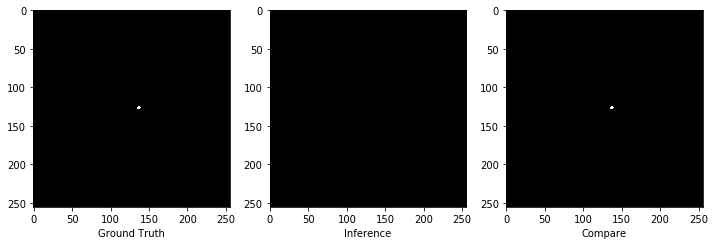

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


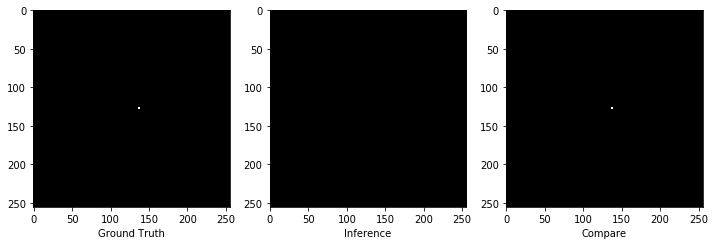

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


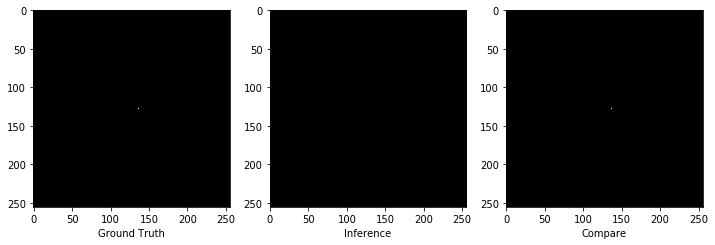

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


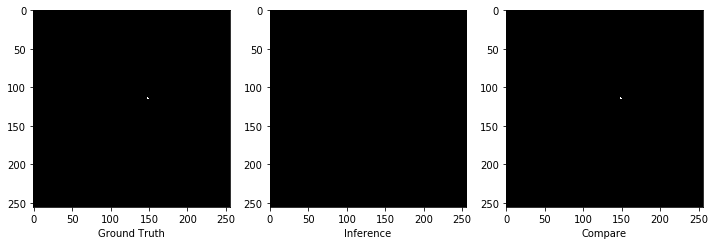

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


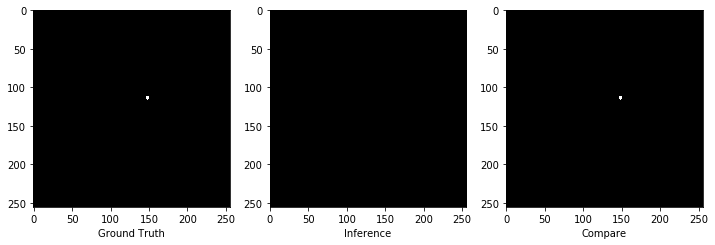

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


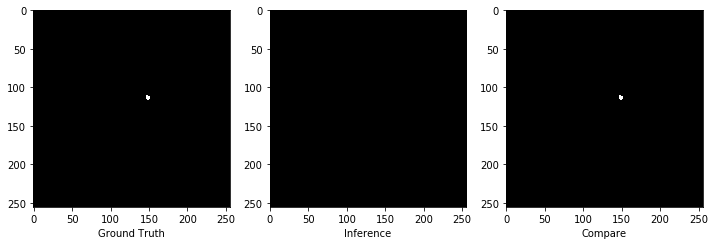

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


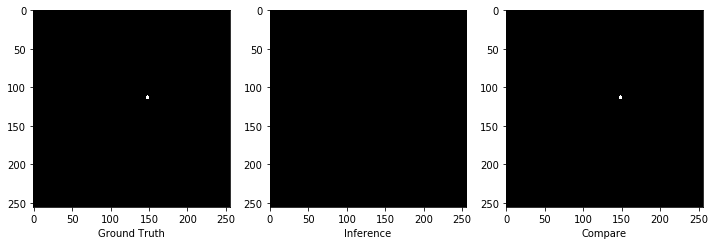

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


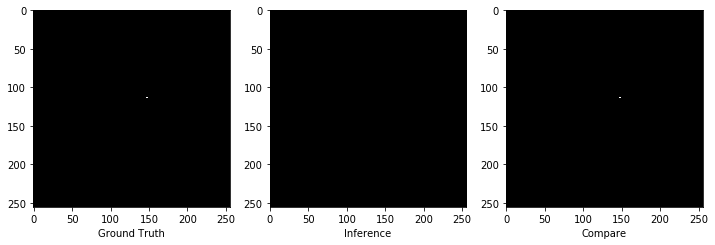

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


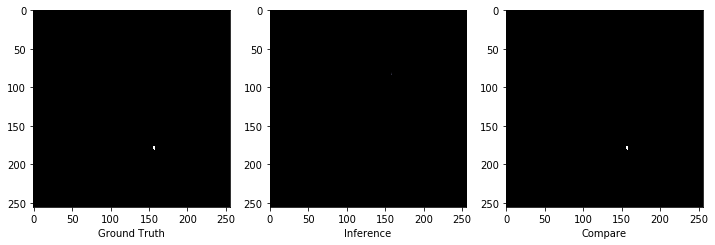

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


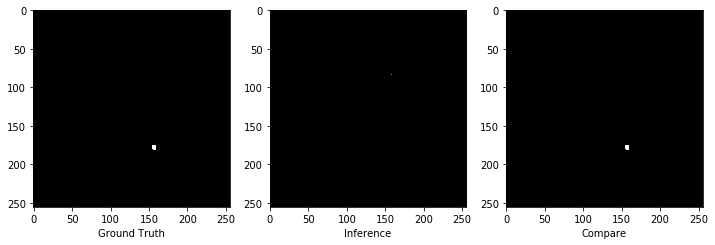

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


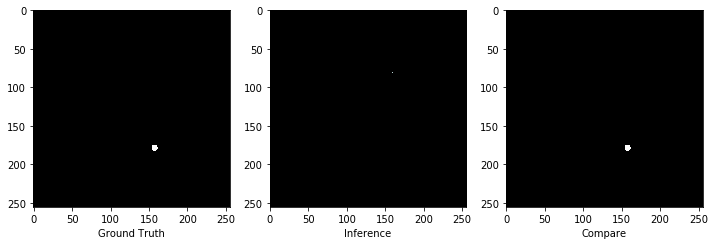

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


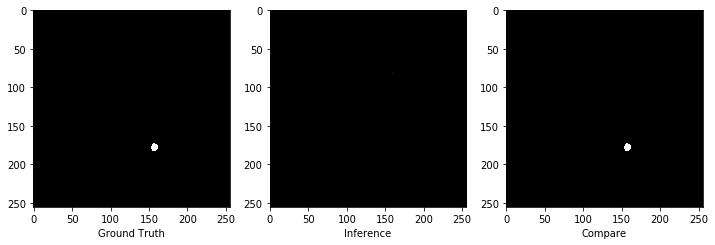

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


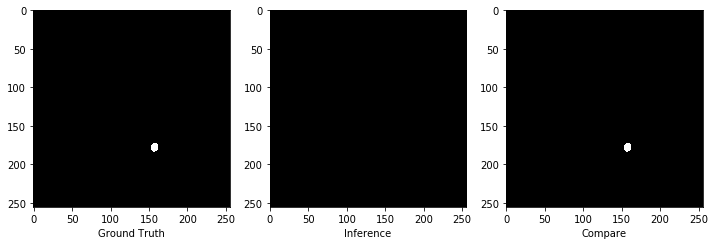

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


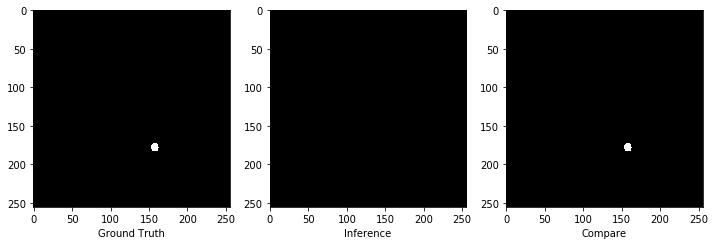

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


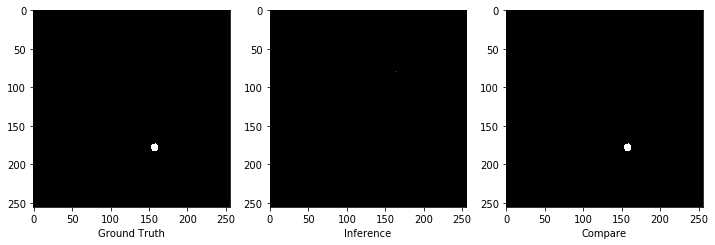

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


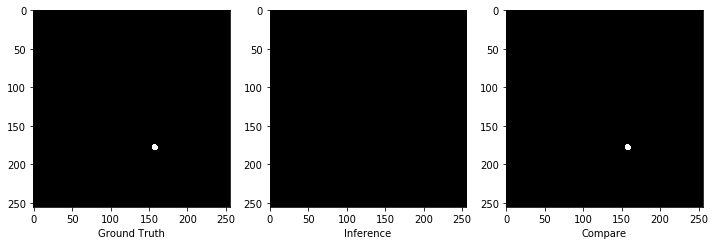

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


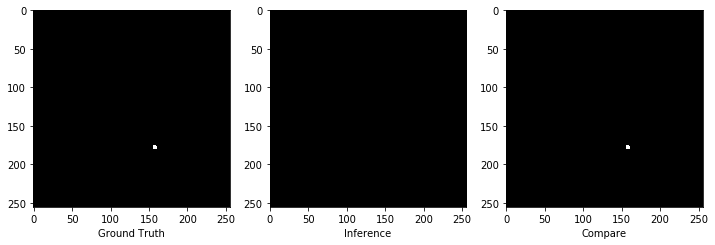

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


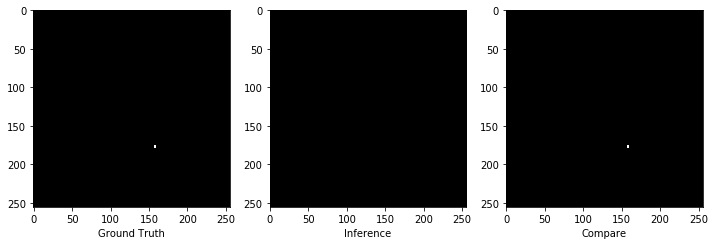

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


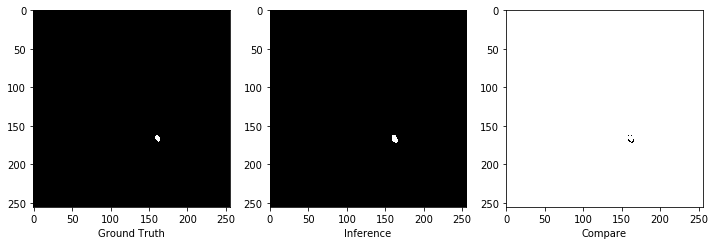

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


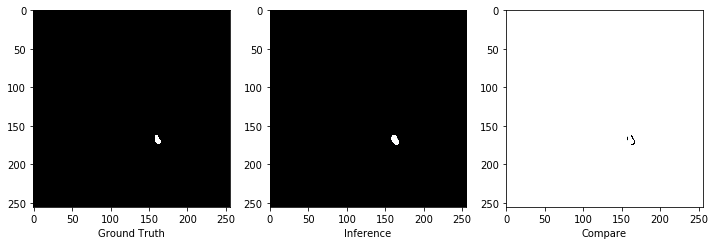

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


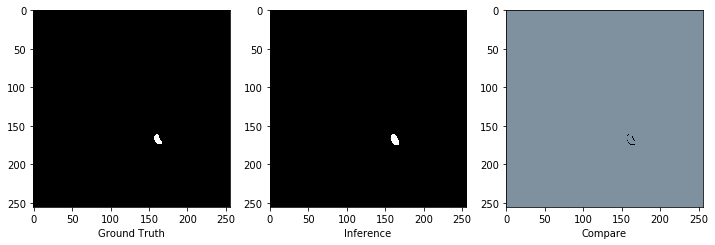

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


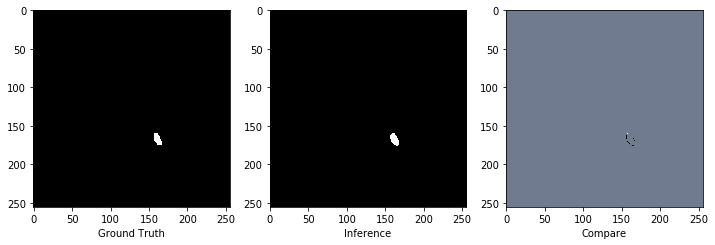

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


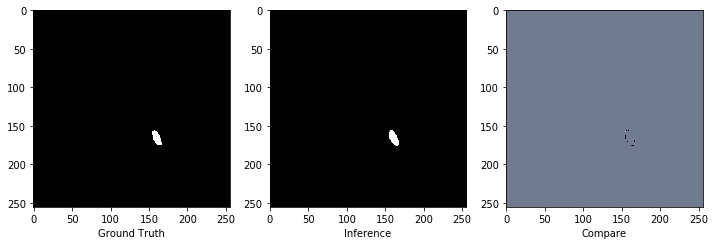

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


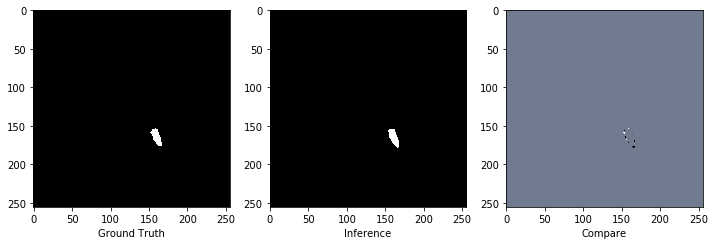

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


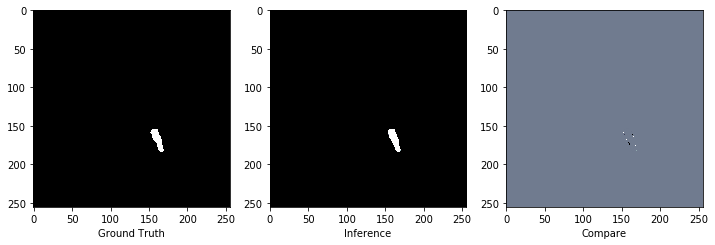

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


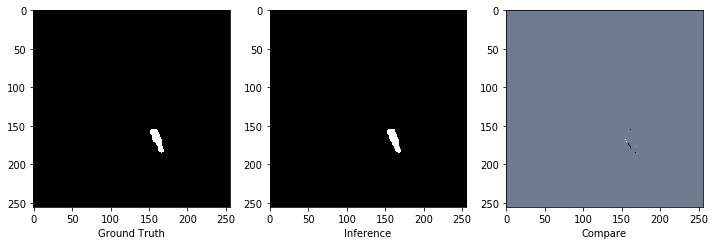

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


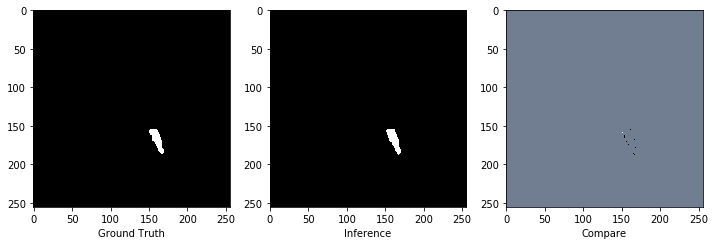

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


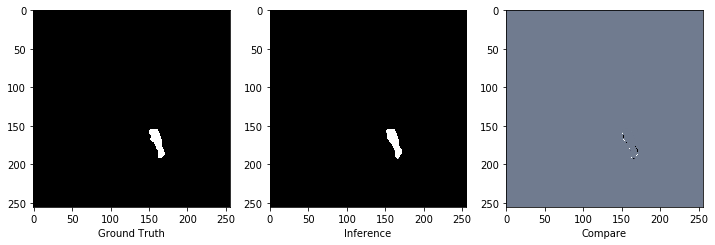

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


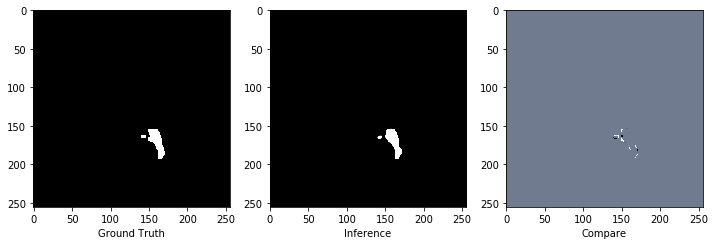

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


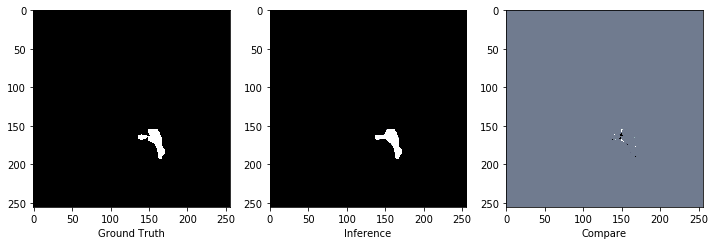

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


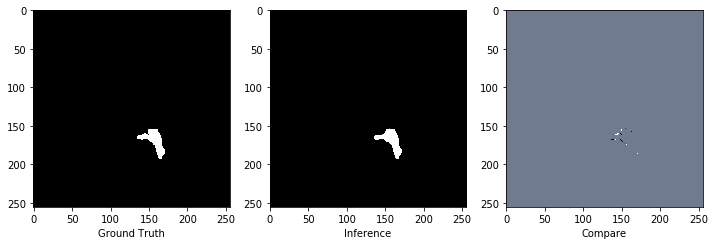

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


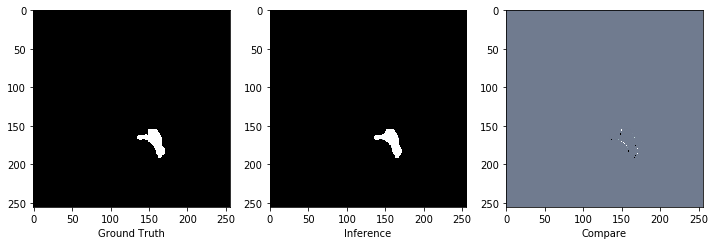

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


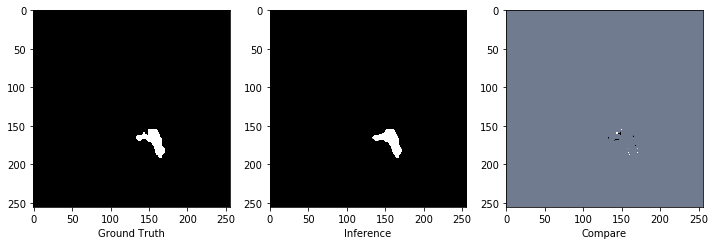

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


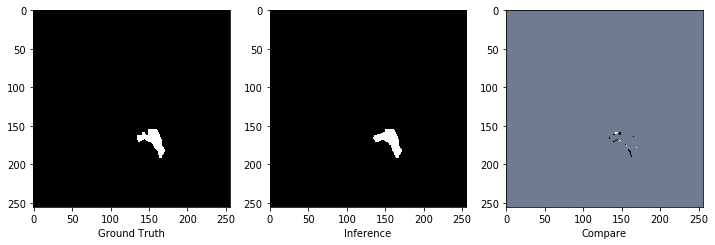

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


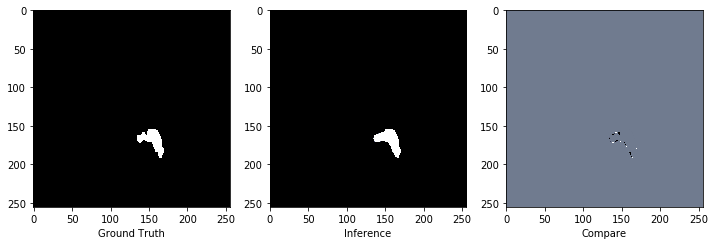

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


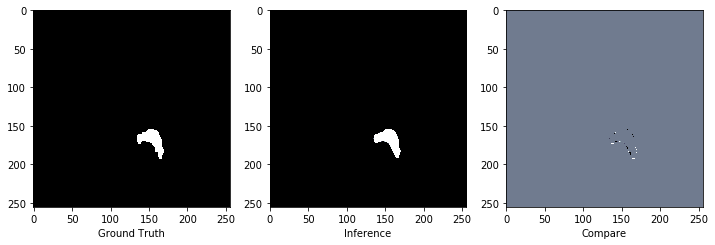

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


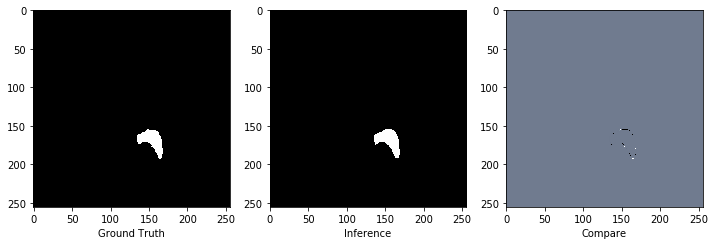

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


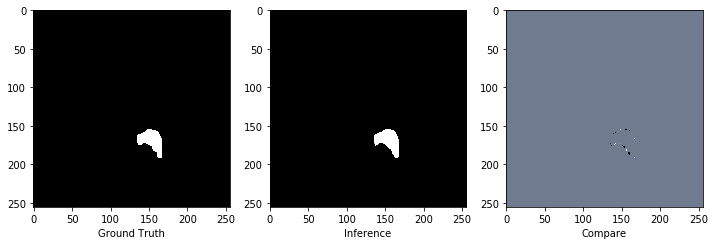

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


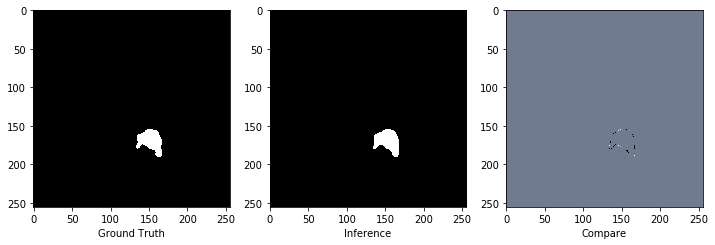

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


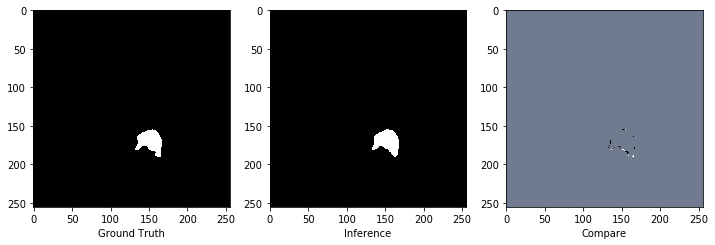

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


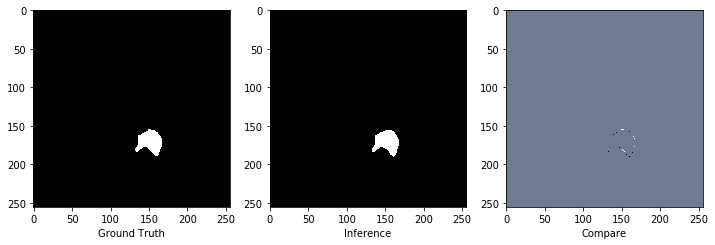

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


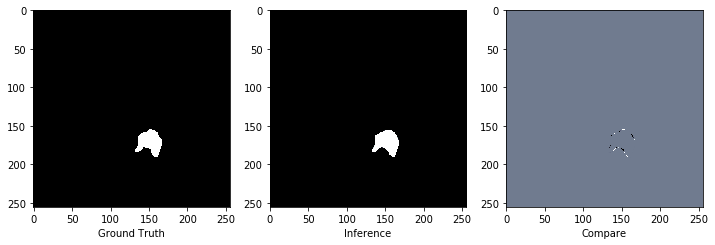

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


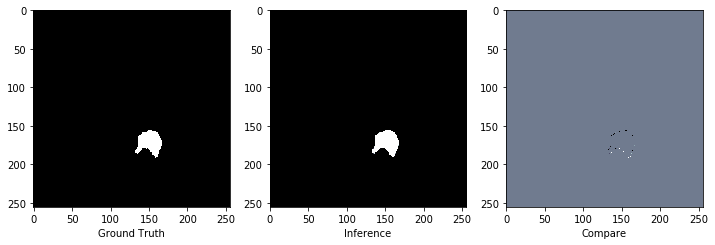

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


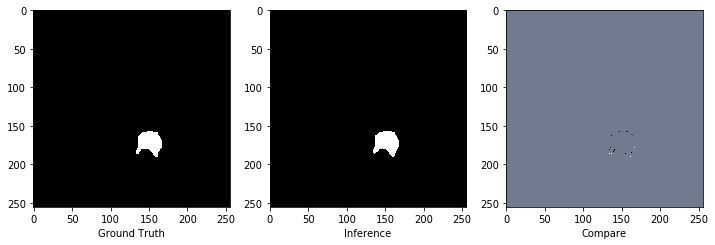

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


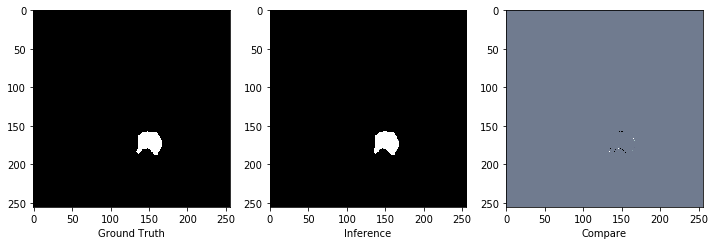

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


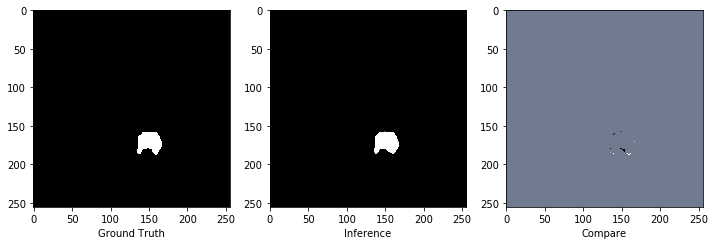

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


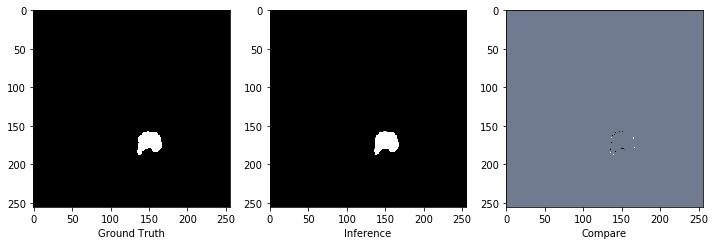

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


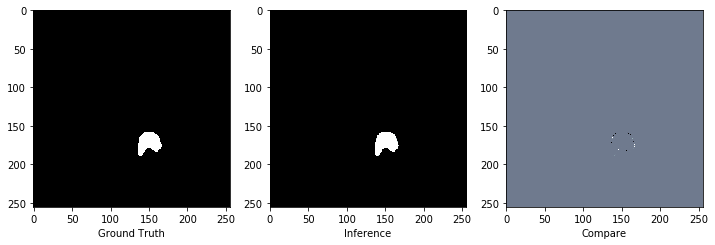

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


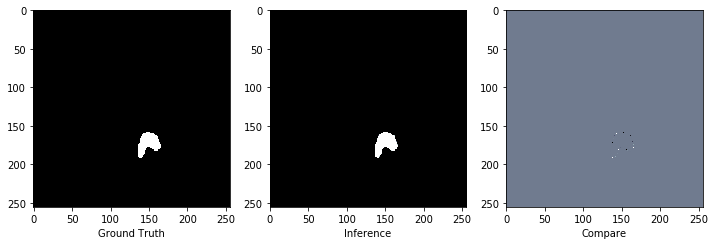

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


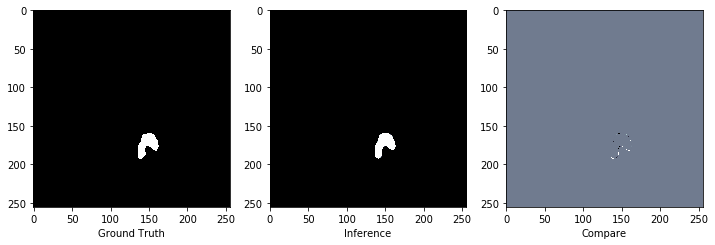

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


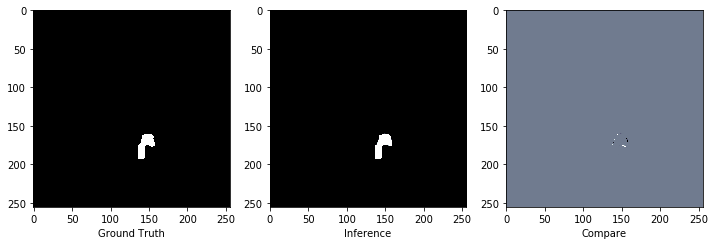

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


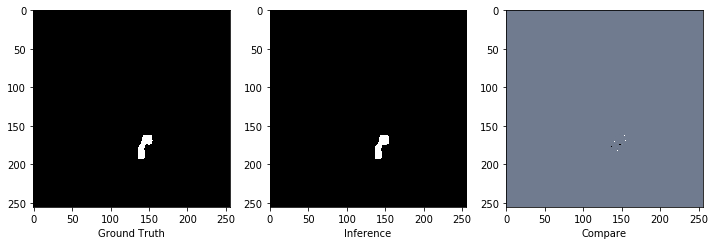

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


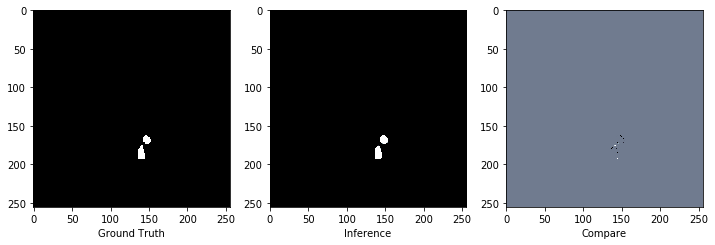

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


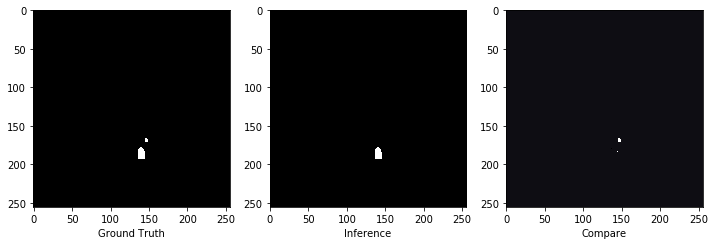

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


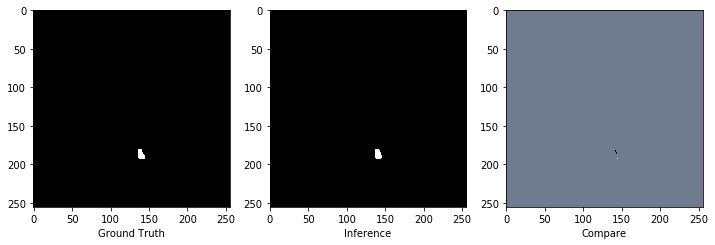

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


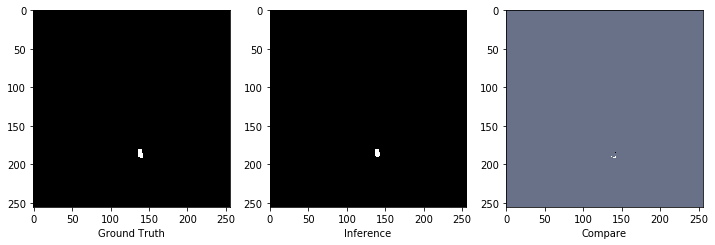

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


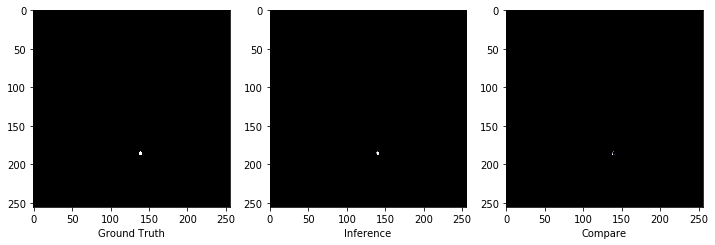

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


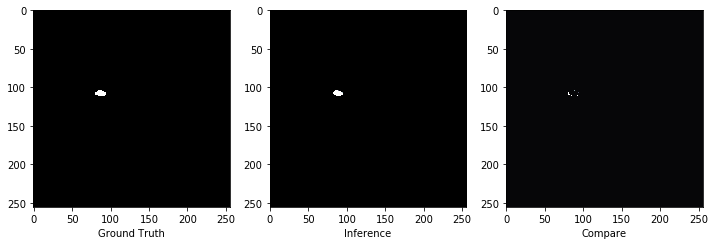

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


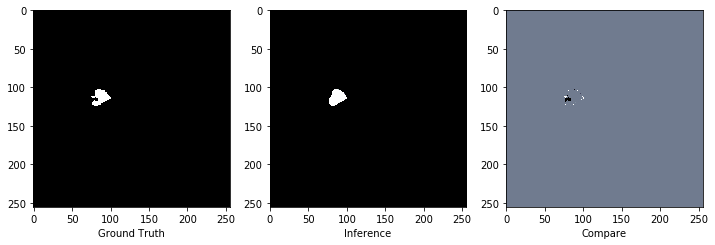

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


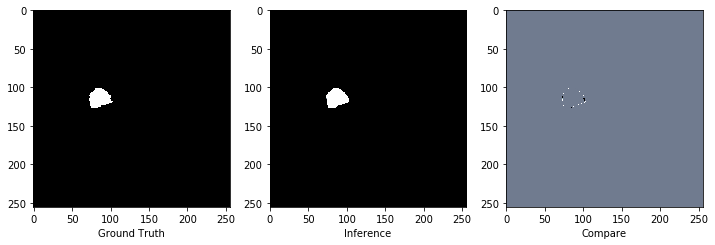

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


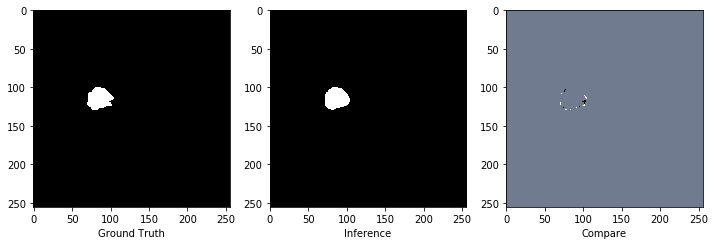

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


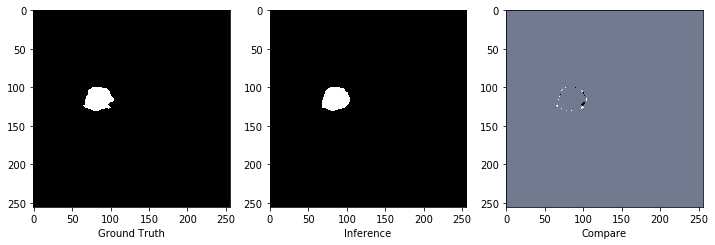

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


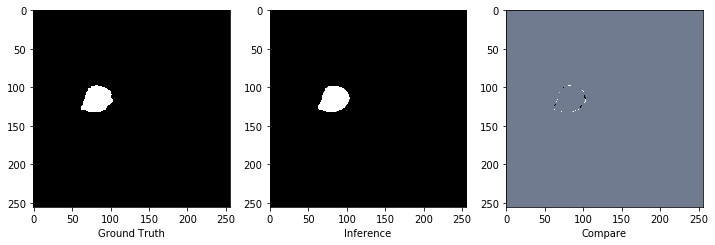

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


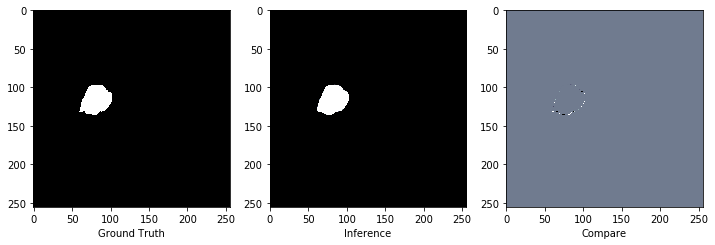

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


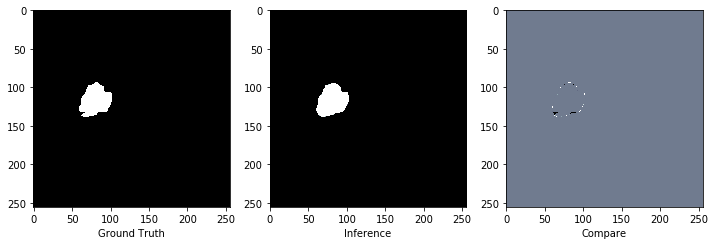

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


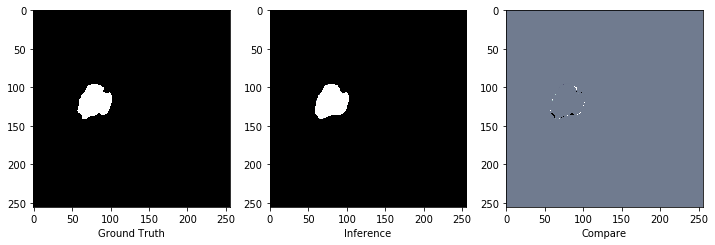

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


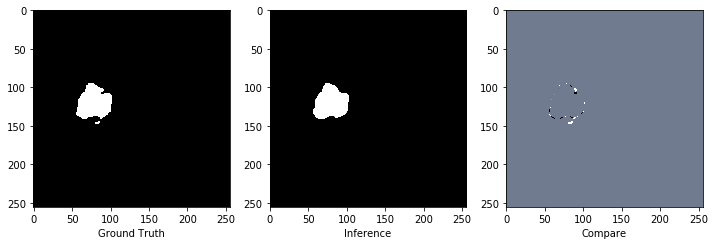

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


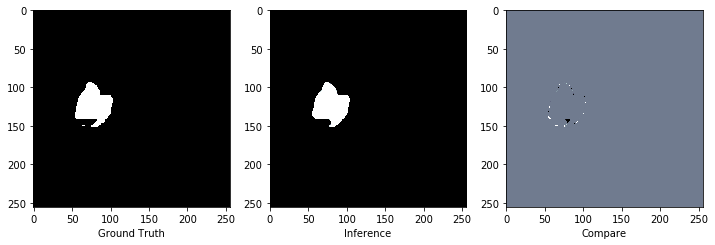

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


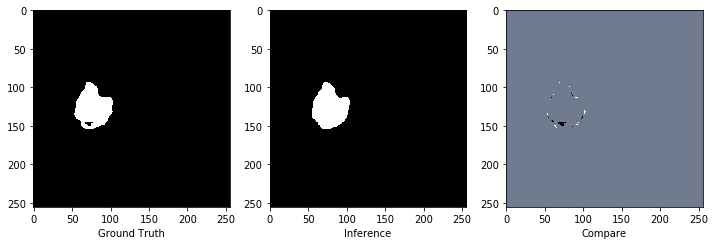

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


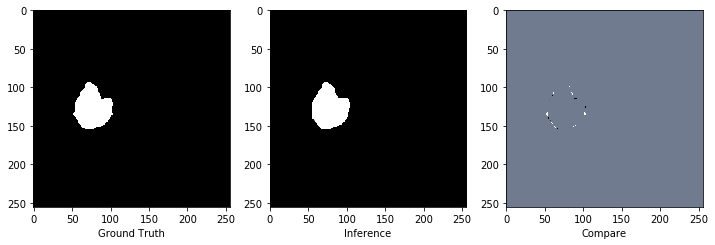

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


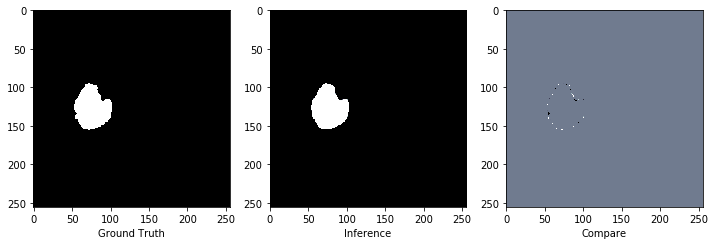

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


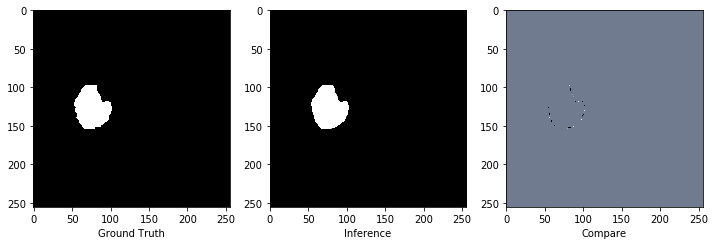

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


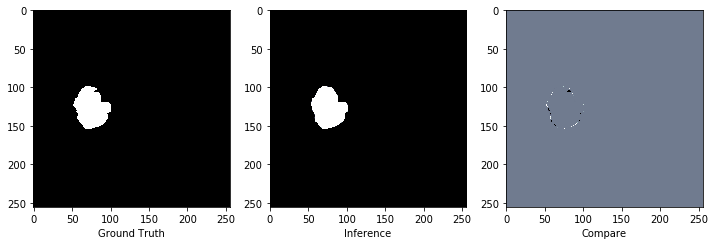

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


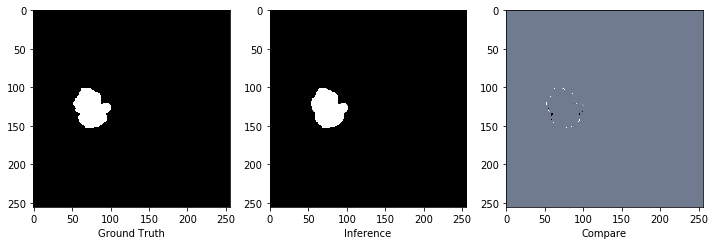

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


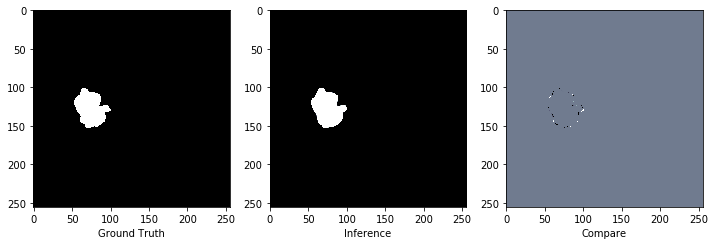

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


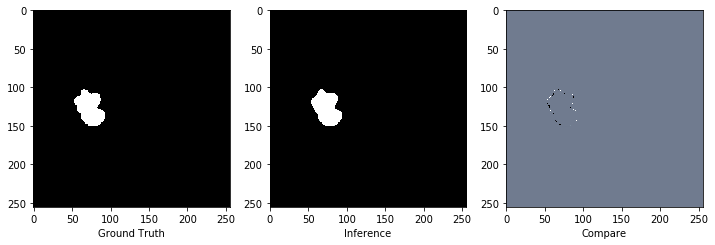

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


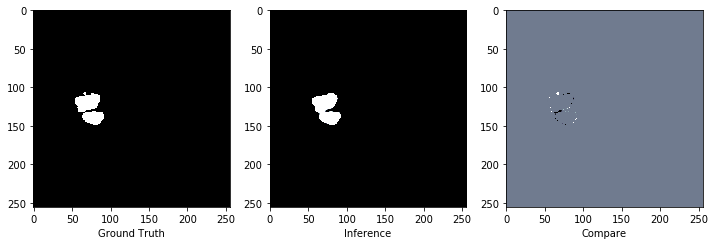

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


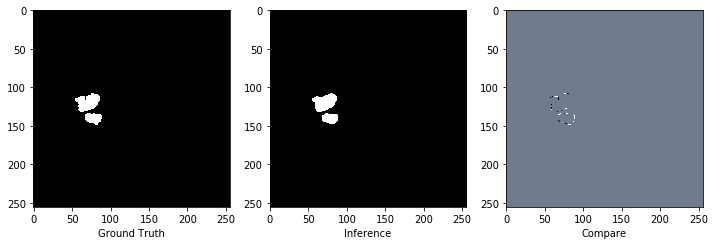

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


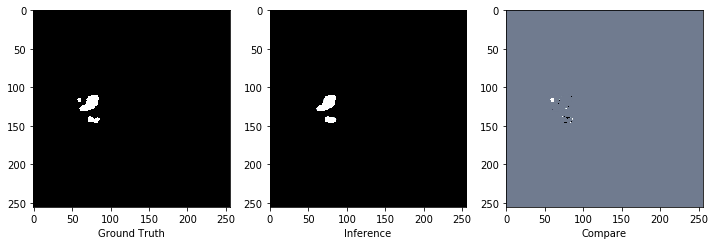

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


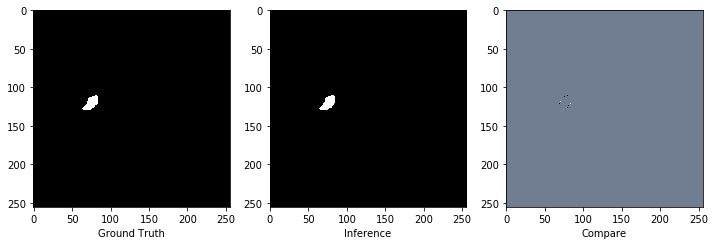

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


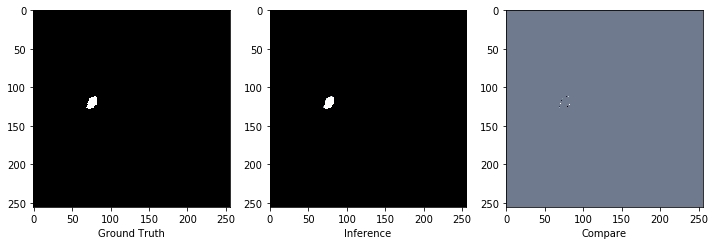

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


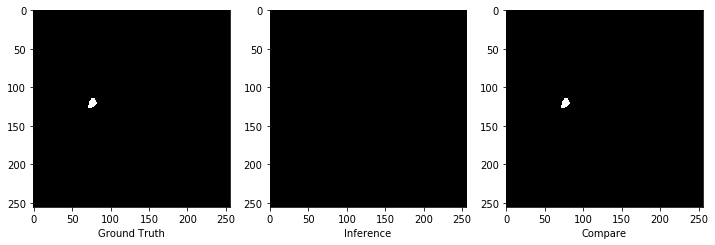

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


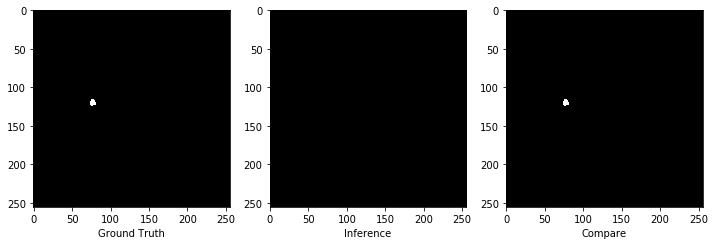

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


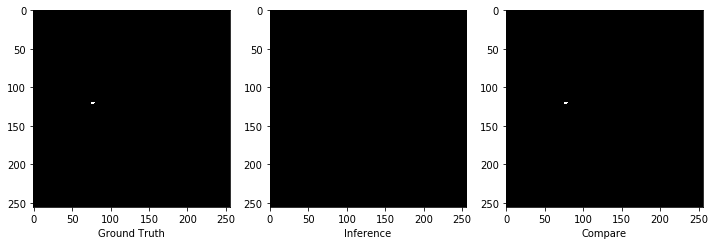

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


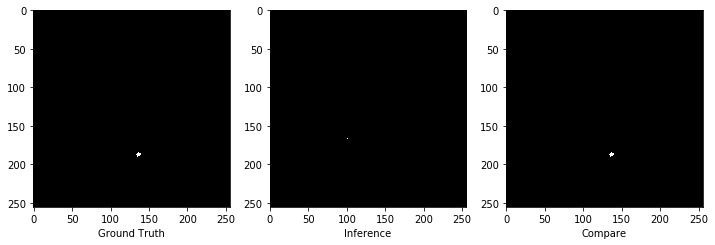

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


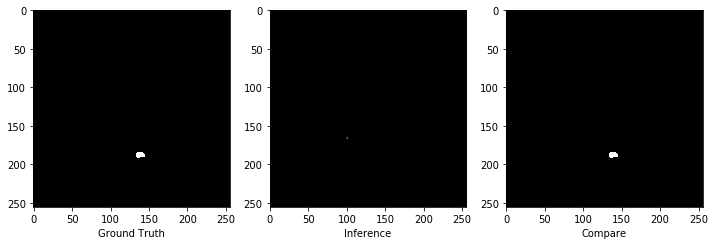

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


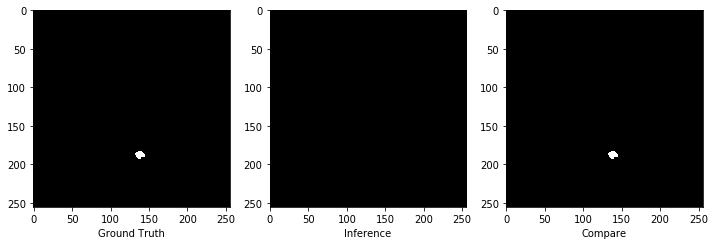

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


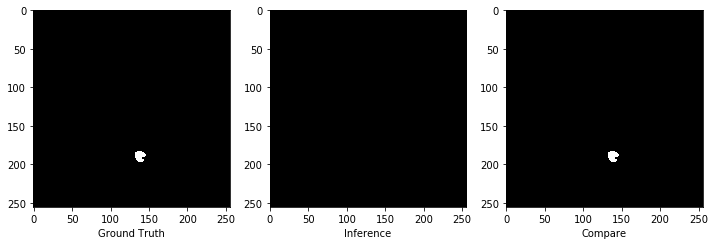

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


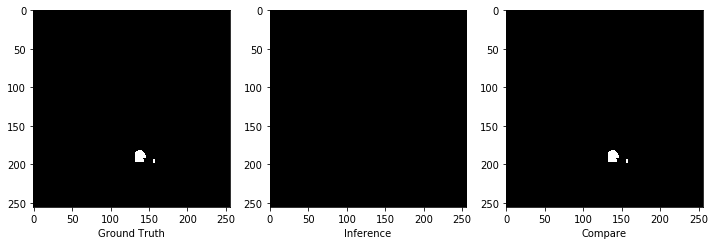

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


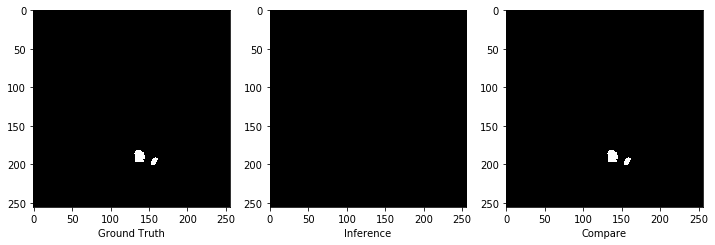

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


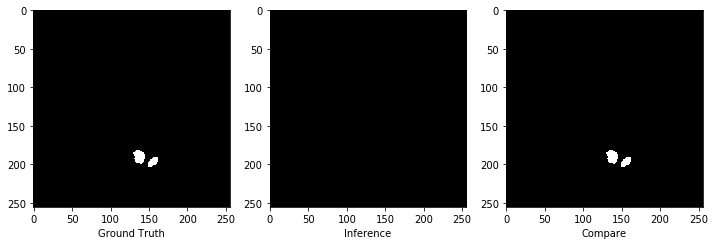

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


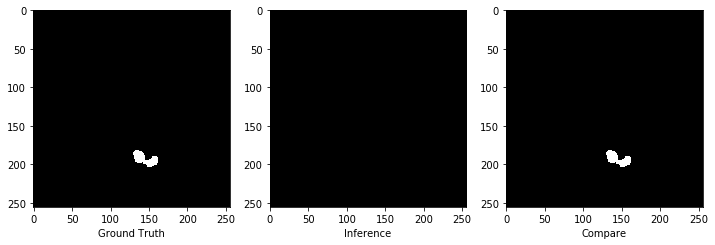

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


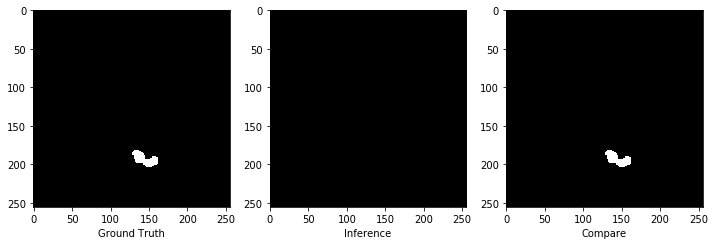

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


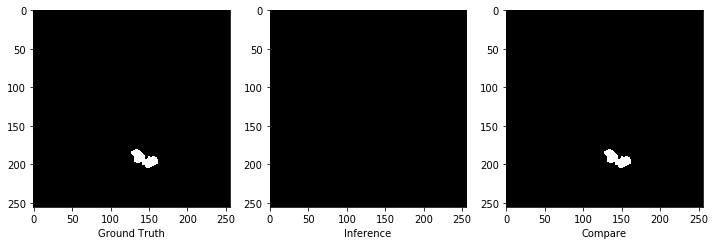

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


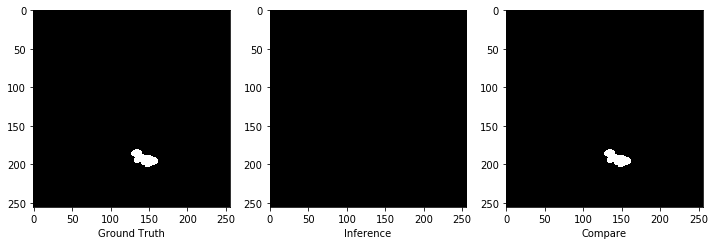

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


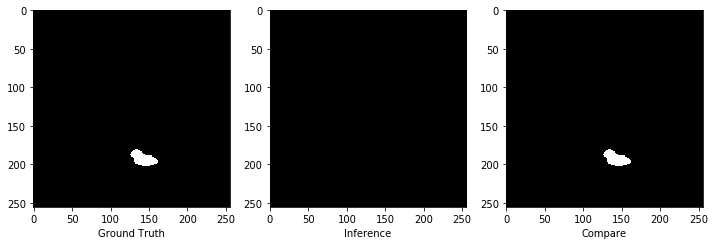

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


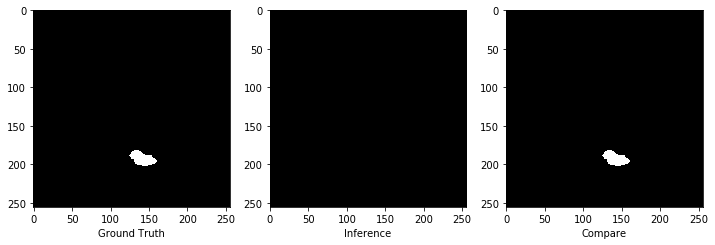

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


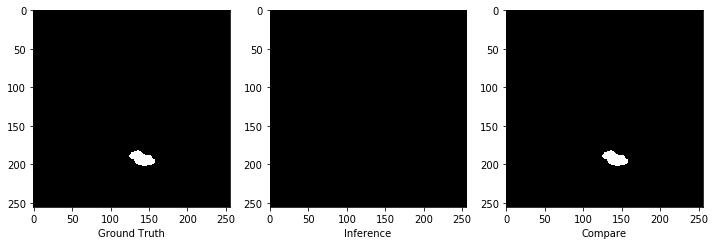

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


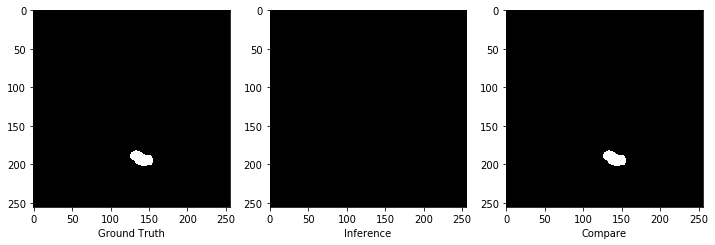

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


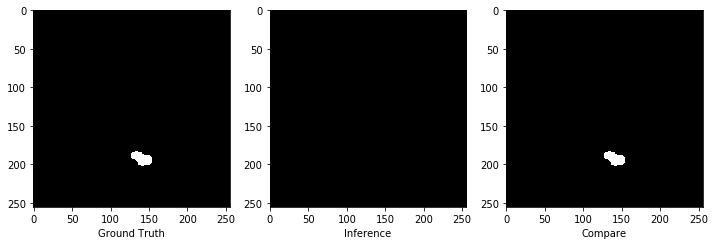

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


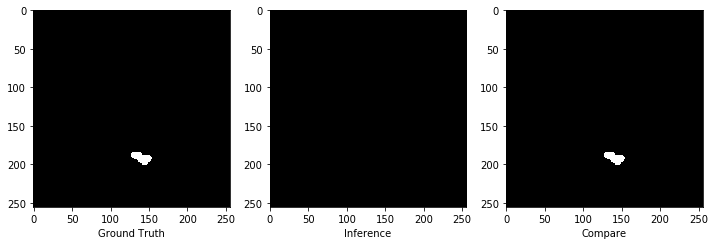

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


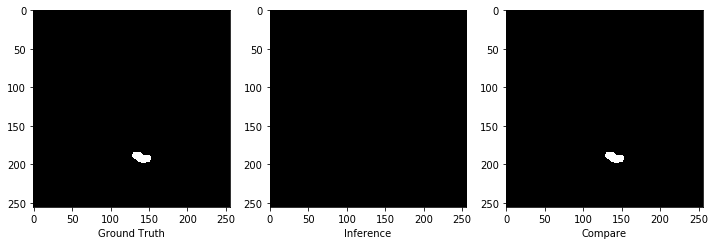

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


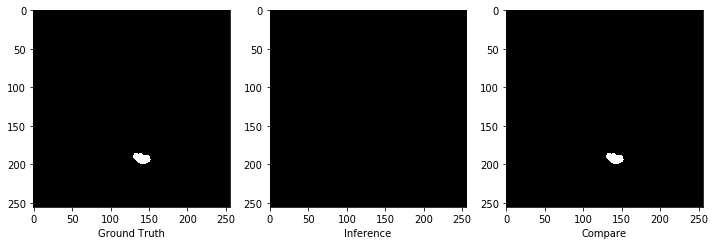

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


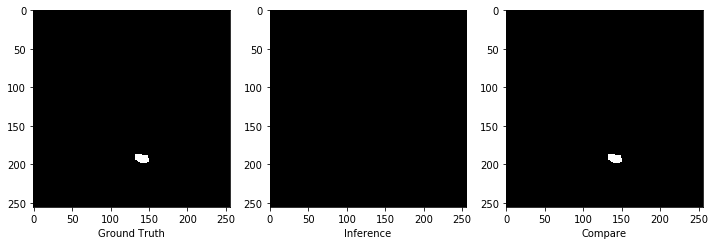

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


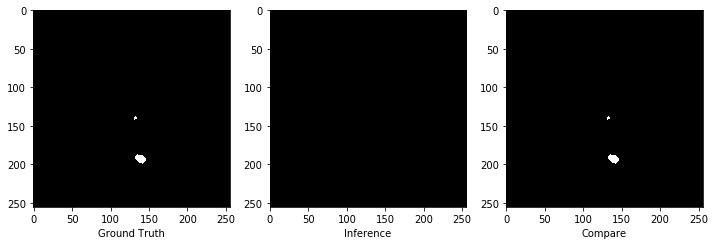

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


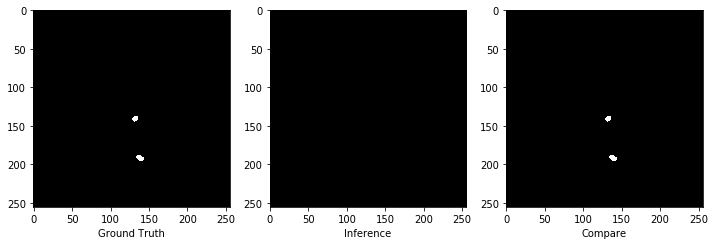

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


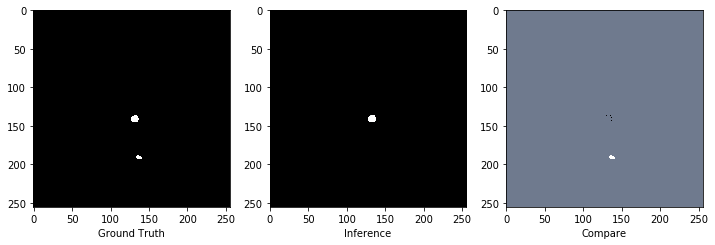

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


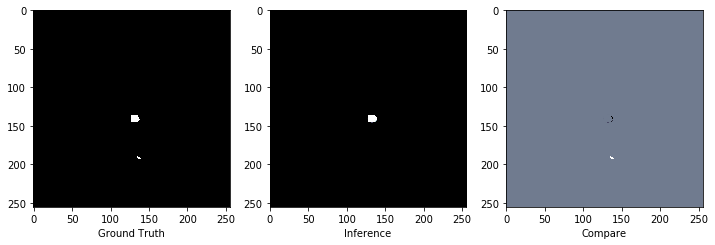

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


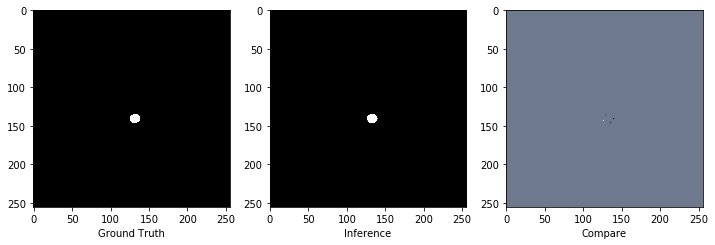

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


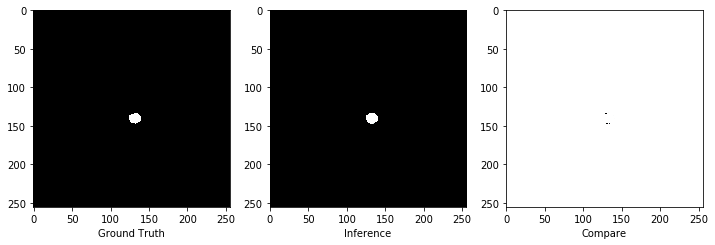

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


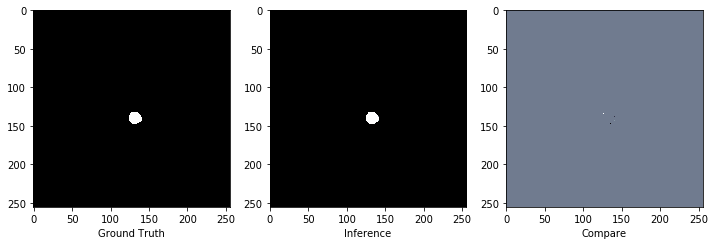

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


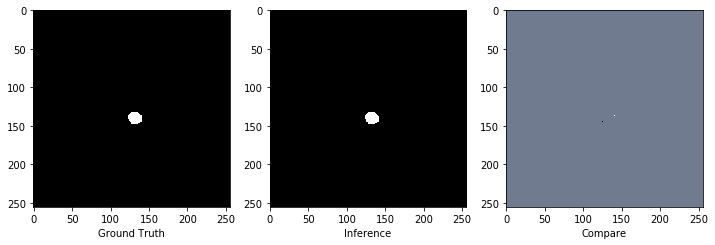

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


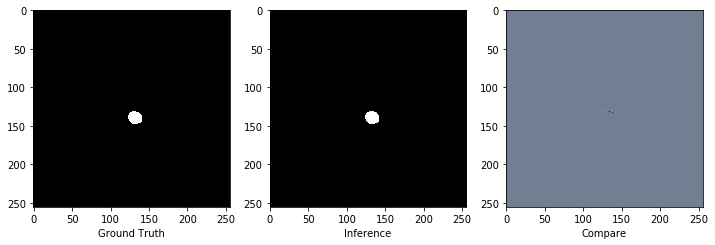

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


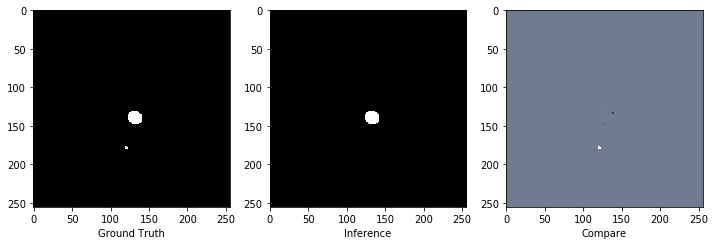

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


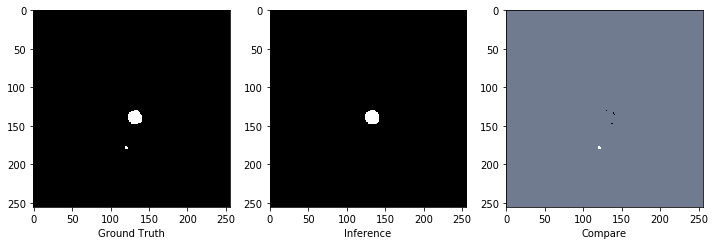

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


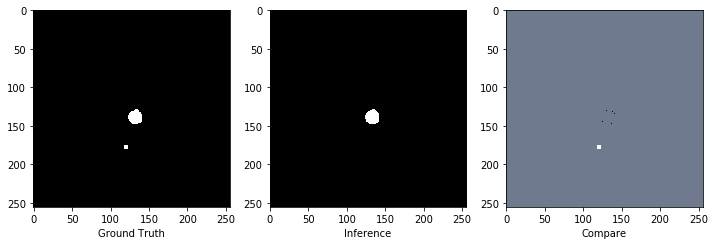

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


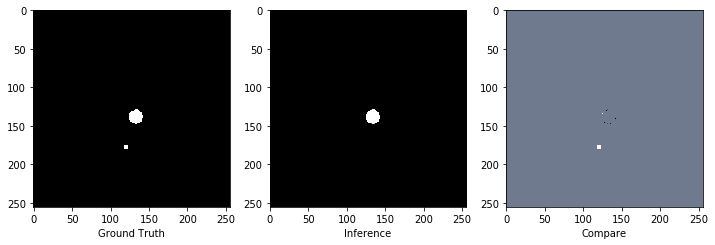

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


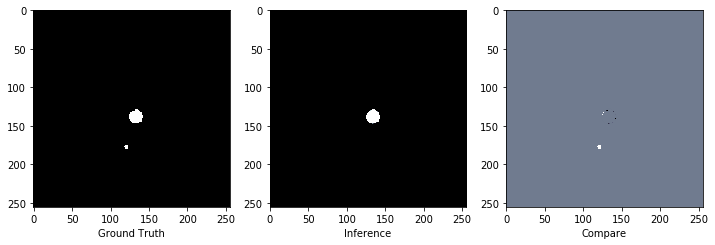

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


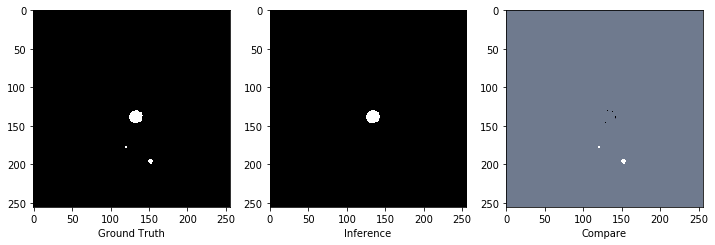

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


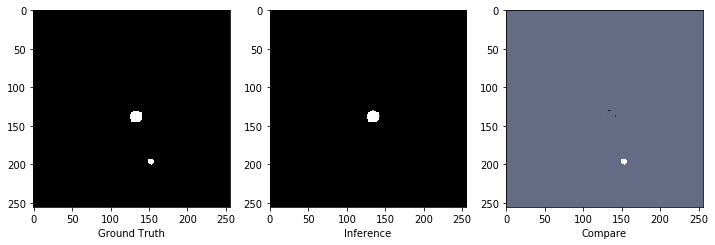

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


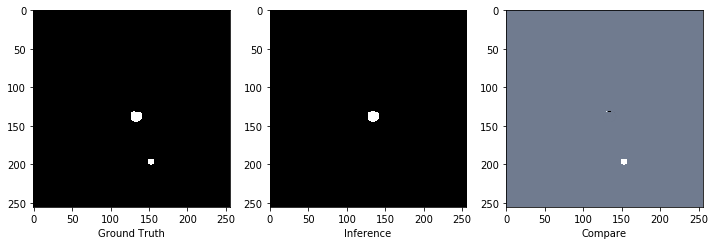

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


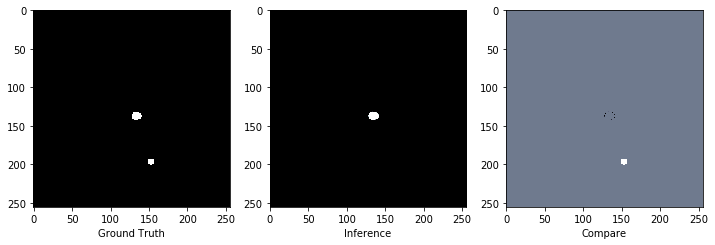

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


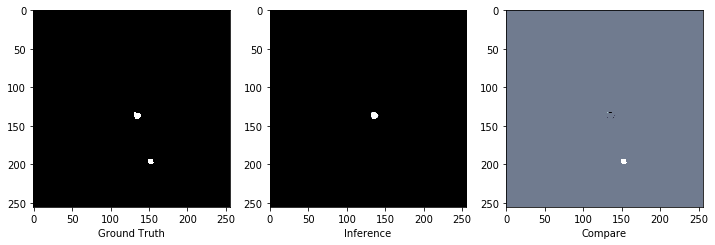

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


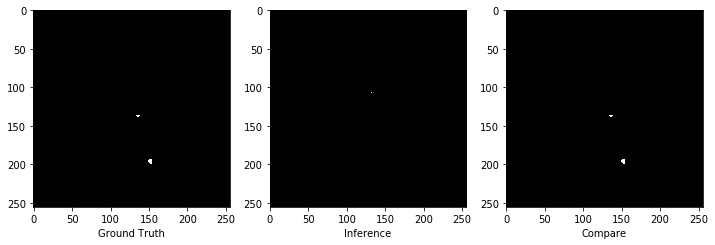

INFO:tensorflow:Restoring parameters from ./checkpoint/1000


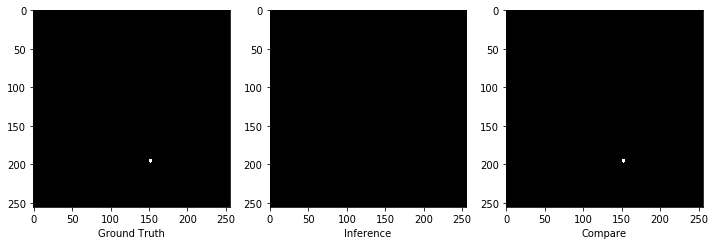

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
for i in range(len(tum_in_img)):
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, './checkpoint/1000')
        test = sess.run(tf.nn.sigmoid(pred['out']), feed_dict={X:np.reshape(tum_in_img[i], [1,256,256,1])})

        plt.figure(figsize=(12,12))
        plt.subplot(131)
        plt.xlabel("Ground Truth")
        plt.imshow(tum_in_lab[i, :, :, 0], cmap=plt.cm.bone)
        plt.subplot(132)
        plt.xlabel("Inference")
        plt.imshow(test[0,:,:,0], cmap=plt.cm.bone)
        plt.subplot(133)
        plt.xlabel("Compare")
        plt.imshow(tum_in_lab[i, :, :, 0]-test[0,:,:,0], cmap=plt.cm.bone)
        plt.show()